Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [52]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [350]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    data = pd.concat([
        data,
        year_csv
    ]).reset_index(drop=True)

# Preprocessing

In [520]:
## Rainfall -------------------------------------------------------------------

def process_rainfall(df): # Removes races with rain
    rain = df.groupby(['Year', 'RoundNumber', 'DriverNumber'])['Compound'].transform(lambda x: x[x.str.contains('INTERMEDIATE|WET')].count())
    return df[rain == 0].reset_index(drop=True)

## TrackName ------------------------------------------------------------------

def process_track_name(df):
    df['Track'] = df['Track'].str.replace(' ', '_')
    return df
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': -1,
        'GapToLeader': -1,
        'IntervalToPositionAhead': -1,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1].reset_index(drop=True)

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    #df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    #df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate', 'Year', 'RoundNumber'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

In [521]:
def preprocess_pre_split(df):
    df = df.copy()
    print('Preprocessing data...', df.shape)
    df = process_rainfall(df)
    print('Rainfall processed...', df.shape)
    df = process_track_name(df)
    print('TrackName processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    return df

def preprocess_post_split(df):
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_datatypes(df)
    print('Preprocessing data...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    return df

def preprocess_post_split_train(df):
    df = df.copy()
    df = process_target(df)
    print('Target processed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)

    df = preprocess_post_split(df)
    
    return df, encoder

def preprocess_post_split_test(df, encoder):
    df = df.copy()
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_feature_encoding_new(df, encoder)
    print('Features encoded...', df.shape)

    df = preprocess_post_split(df)

    return df

In [8]:
#%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [466]:
def get_races_grouped(df):
    return df.groupby(['Year', 'RoundNumber', 'DriverNumber'])

def get_train_test_split(df, test_size, random_state, return_groups=False):
    np.random.seed(random_state)
    groups = get_races_grouped(df).groups
    groups_keys = list(groups.keys())
    np.random.shuffle(groups_keys)
    test_groups = groups_keys[:int(len(groups_keys) * test_size)]
    train_groups = groups_keys[int(len(groups_keys) * test_size):]
    test = df[df.apply(lambda x: (x['Year'], x['RoundNumber'], x['DriverNumber']) in test_groups, axis=1)].reset_index(drop=True)
    train = df[df.apply(lambda x: (x['Year'], x['RoundNumber'], x['DriverNumber']) in train_groups, axis=1)].reset_index(drop=True)
    if return_groups:
        return train, test, train.groupby(['Year', 'RoundNumber', 'DriverNumber']).groups, test.groupby(['Year', 'RoundNumber', 'DriverNumber']).groups
    return train, test

In [522]:
df = data.copy()
df = preprocess_pre_split(df)

Preprocessing data... (89139, 29)
Rainfall processed... (78346, 29)
TrackName processed... (78346, 29)
Missing values processed... (75663, 29)


In [523]:
train_df, test_df, train_groups, test_groups = get_train_test_split(df.copy(), test_size=0.2, random_state=42, return_groups=True)

In [524]:
train_df, encoder = preprocess_post_split_train(train_df)
test_df = preprocess_post_split_test(test_df, encoder)

Target processed... (60505, 30)
One hot :  (60505, 32)
Data :  (60505, 30)
Features encoded... (60505, 60)
TrackStatus processed... (60505, 65)
Preprocessing data... (60505, 65)
Features removed... (60505, 50)
Target processed... (15158, 30)
Features encoded... (15158, 60)
TrackStatus processed... (15158, 65)
Preprocessing data... (15158, 65)
Features removed... (15158, 50)


In [528]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop(['is_pitting'], axis=1)
y_train = train_df['is_pitting']

X_test = test_df.drop(['is_pitting'], axis=1)
y_test = test_df['is_pitting']

In [529]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60505, 49) (15158, 49) (60505,) (15158,)


In [530]:
for group, laps in test_groups.items():
    print(group, laps)
    print(X_test2[laps])
    print(X_test.iloc[laps])
    break

(2019.0, 2.0, '18') Index([3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 136, 141, 145, 148, 152, 156, 160, 164, 168, 172, 176, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 220], dtype='int64')
[[  2.    127.111   1.    ...   0.      0.      0.   ]
 [  3.     97.816   2.    ...   0.      0.      0.   ]
 [  4.     98.329   3.    ...   0.      0.      0.   ]
 ...
 [ 54.    131.191  31.    ...   0.      0.      0.   ]
 [ 55.    134.128  32.    ...   0.      0.      0.   ]
 [ 56.    107.007  33.    ...   0.      0.      0.   ]]
     LapNumber     LapTime  TyreLife  Stint  DistanceToDriverAhead  NumberOfPitStops  Position  GapToLeader  IntervalToPositionAhead  LapsToLeader  TotalLaps  Compound_HARD  Compound_MEDIUM  Compound_SOFT  Track_Austin  Track_Baku  Track_Barcelona  Track_Budapest  Track_Imola  Track_Jeddah  Track_Le_Castellet  Track_Lusail  Track_Melbourne  Track_Mexico_City  Track_Miam

# Modelisation

In [540]:
def calculate_distance_to_next_true(series):
    # Find the indices of True values
    true_indices = np.where(series)[0]
    true_indices = np.concatenate((true_indices, [len(series)]))

    distance_to_next_true = np.zeros(len(series))
    for i in range(len(series)):
        sorted_indices = np.searchsorted(true_indices, i)
        if sorted_indices == len(true_indices) - 1:
            distance_to_next_true[i] = len(series)
        else:
            distance_to_next_true[i] = true_indices[sorted_indices] - i

    # Replace the True values by the distance to the next True value
    result_series = pd.Series(distance_to_next_true)
    
    return result_series

def calculate_weight(proba, distance_to_pit, threshold=0.5, penalty=1):
    if distance_to_pit <= 0:
        return proba
    elif proba >= threshold:
        #return distance_to_pit * (1 - (1 + penalty) * proba)
        return distance_to_pit * penalty * -(-proba + threshold)**2
    else:
        return 0
    
def calculate_weights(preds):
    distances = calculate_distance_to_next_true(preds['y'])
    weights = []
    for i in range(len(preds['y'])):
        weights.append(calculate_weight(preds['proba'][i], distances[i], penalty=0.5))
    return weights

def plot_remove_duplicate_legends(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), **kwargs)
    return ax

def plot_weights(ax, weights):
    ax.grid(True)
    weights_cumsum = np.cumsum(weights)
    ax.plot(weights_cumsum)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [538]:
from tensorflow import keras
class RacePerformanceMetricCallback(keras.callbacks.Callback):
    def __init__(self, x_val, y_val, groups, threshold=0.5, penalty=0.5):
        super(RacePerformanceMetricCallback, self).__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.threshold = threshold
        self.penalty = penalty
        self.groups = groups
        self.score_history = []
    def on_epoch_end(self, epoch, logs=None):
        average_score = 0
        for group, laps in self.groups.items(): # Make preds for each race separately
            preds = self.model.predict(self.x_val[laps])
            preds = pd.DataFrame(preds, columns=['proba'])
            preds['y'] = self.y_val[laps]
            weights = calculate_weights(preds)
            average_score += np.sum(weights)
        average_score /= len(self.groups)
        self.score_history.append(average_score)
    def on_train_end(self, logs=None):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        plot_score_history(ax, self.score_history)
        plt.show()

def plot_score_history(ax, score_history):
    ax.grid(True)
    ax.plot(score_history)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [498]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix

import tensorflow.keras.backend as K

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

def balanced_accuracy_loss(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp / (tp + fn + K.epsilon())
    return (specificity + sensitivity) / 2

In [542]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [510]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.5146295823764566, 1: 17.588662790697676}

In [534]:
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train.shape[1]
# Create model
model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='complexe_big_batch_size_lr05_drop2',)

from keras.optimizers import Adam

optimizer = Adam(
    learning_rate=0.0005
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[balanced_accuracy_loss],
    )

model.summary()

Model: "complexe_big_batch_size_lr05_drop2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 1024)              51200     
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_37 (Dense)            (None, 512)               524800    
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 256)               131328    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (No

Epoch 1/10
3/3 [==============================] - 0s 2ms/step


C:\Users\nelso\AppData\Local\Temp\ipykernel_8980\1982037551.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


60/60 [==============================] - 19s 319ms/step - loss: 0.5805 - balanced_accuracy_loss: 0.6167 - val_loss: 0.4845 - val_balanced_accuracy_loss: 0.6070
Epoch 2/10
2/2 [==============================] - 0s 2ms/step


KeyboardInterrupt: 

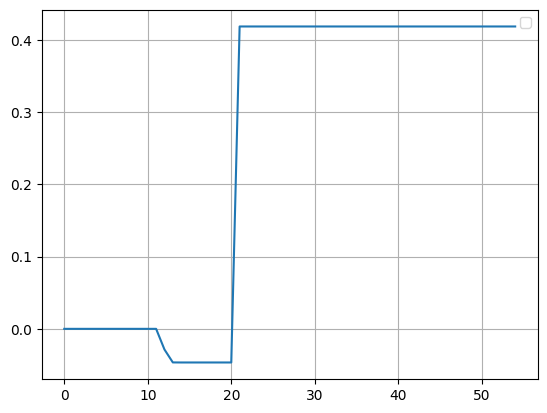

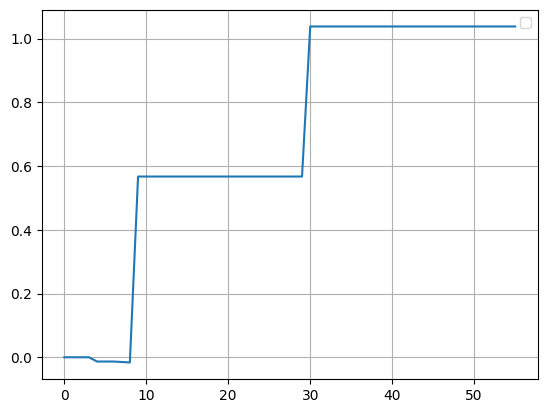

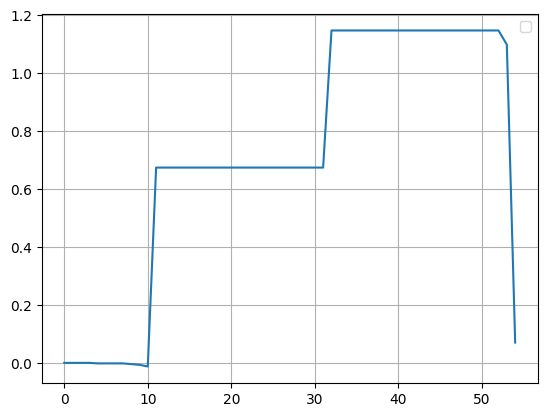

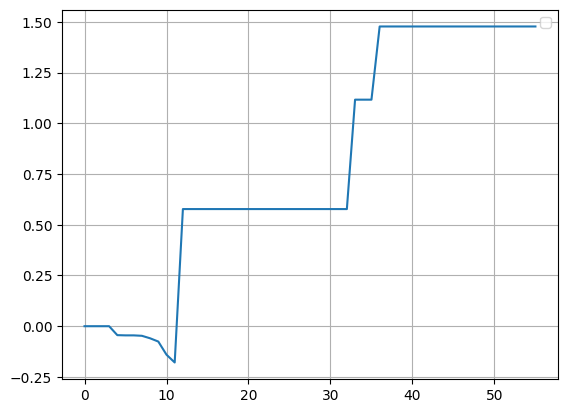

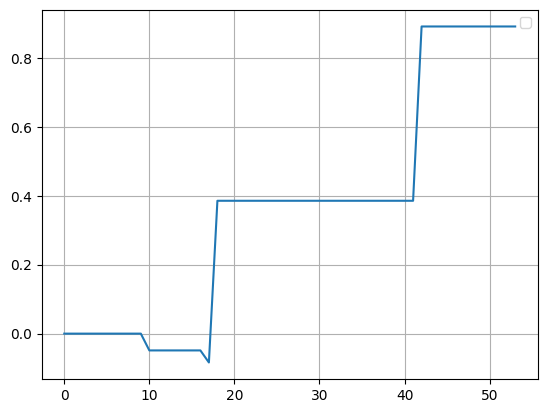

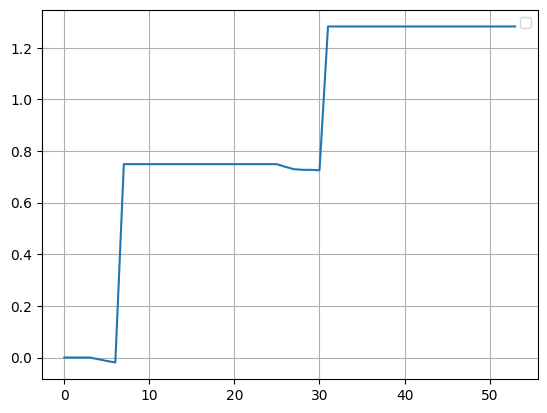

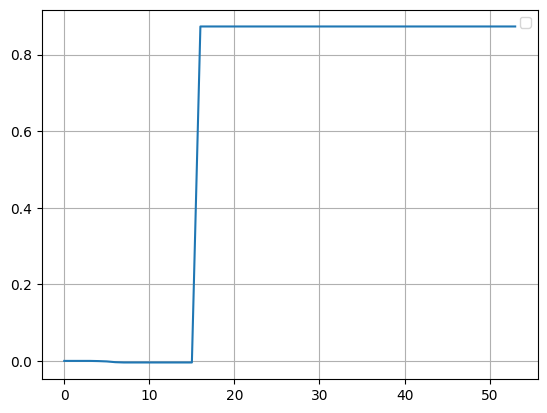

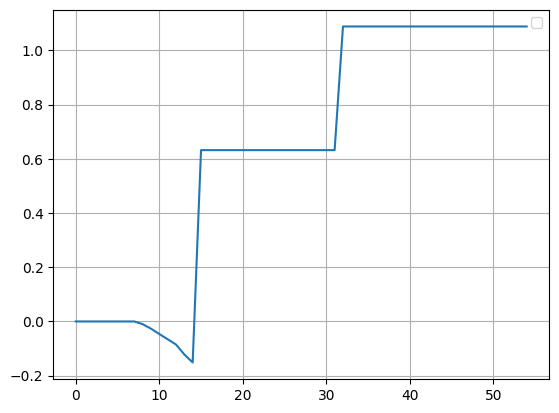

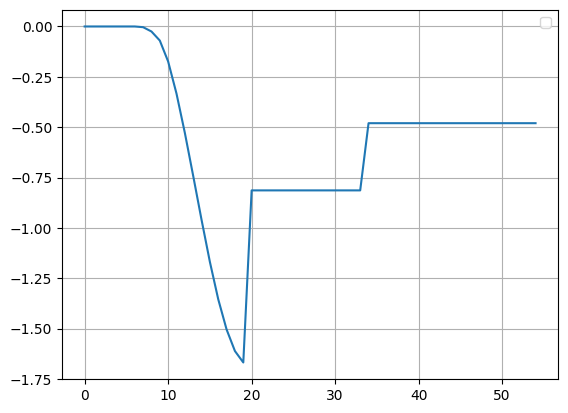

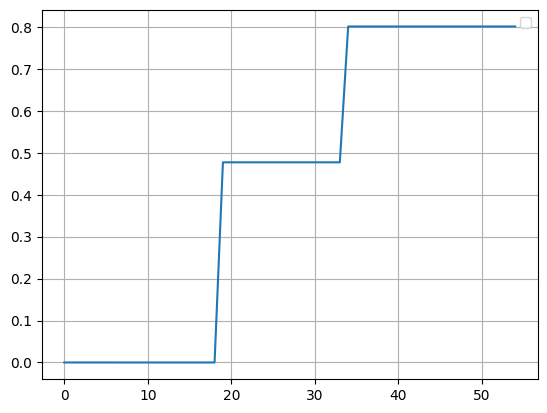

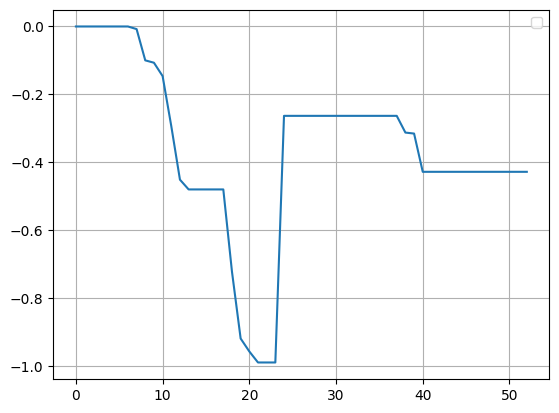

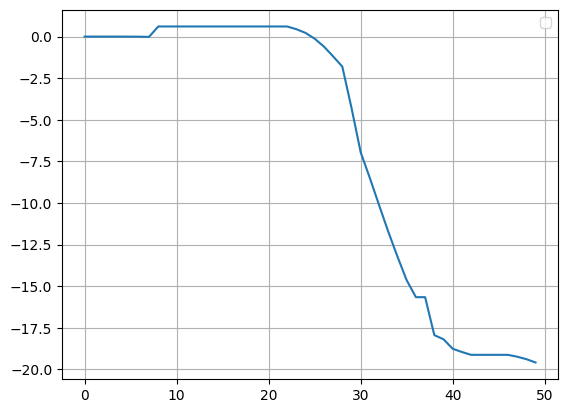

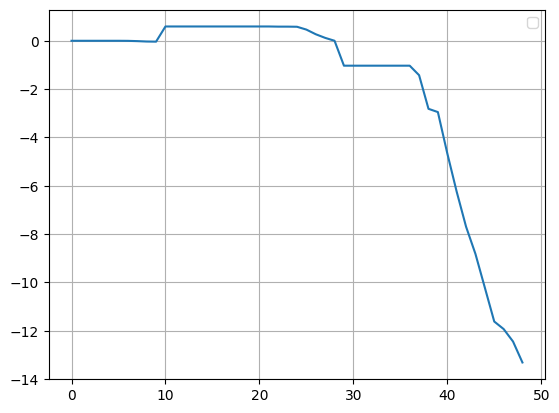

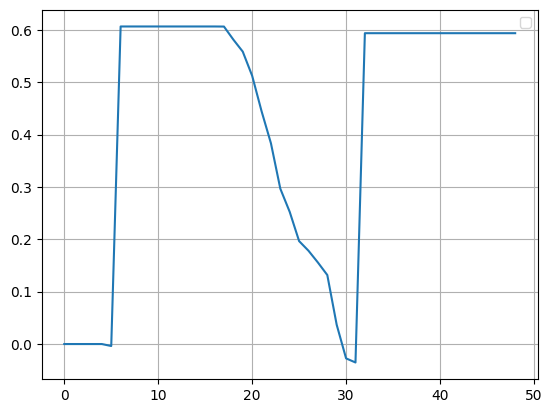

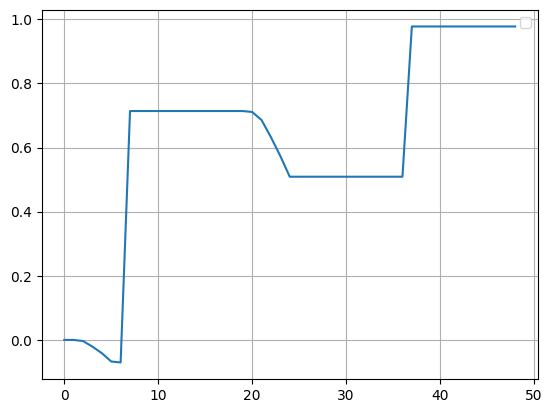

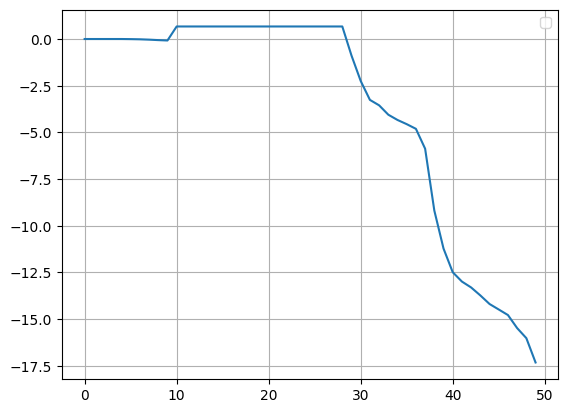

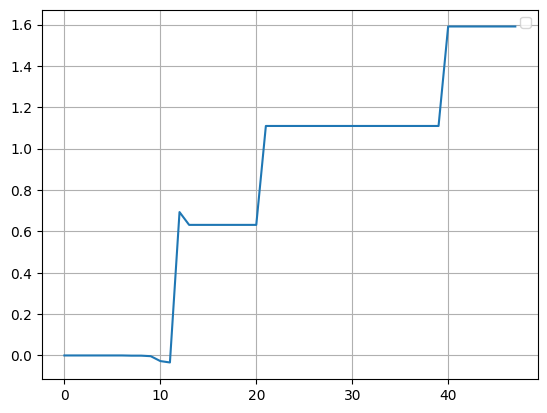

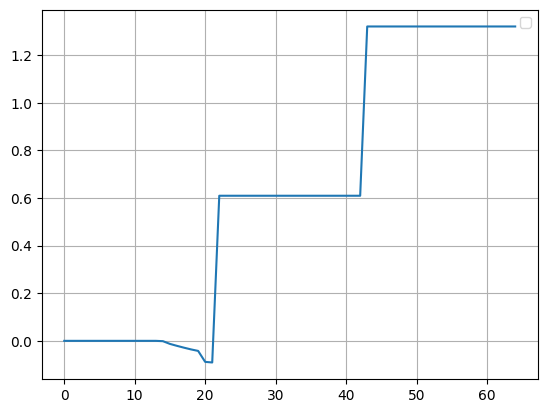

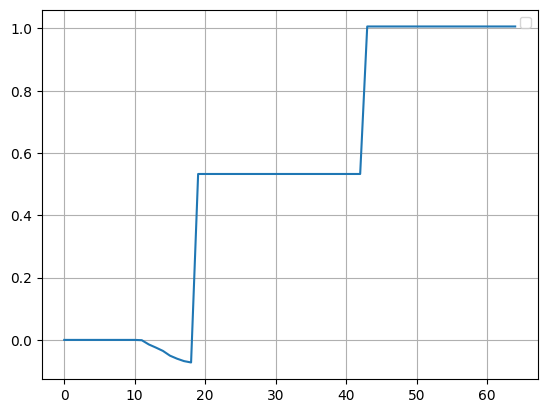

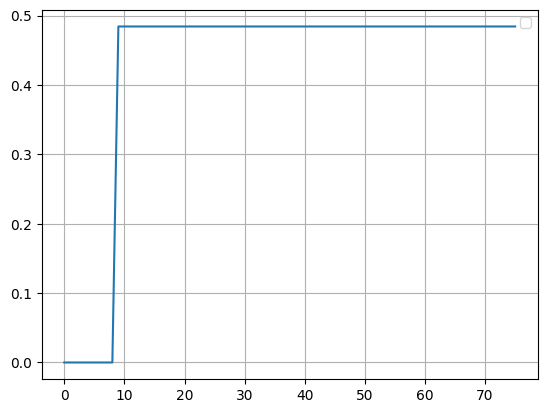

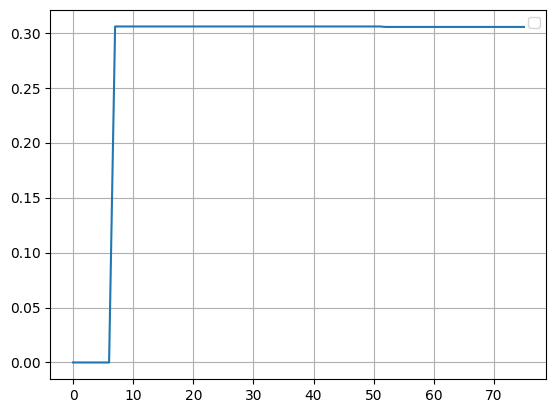

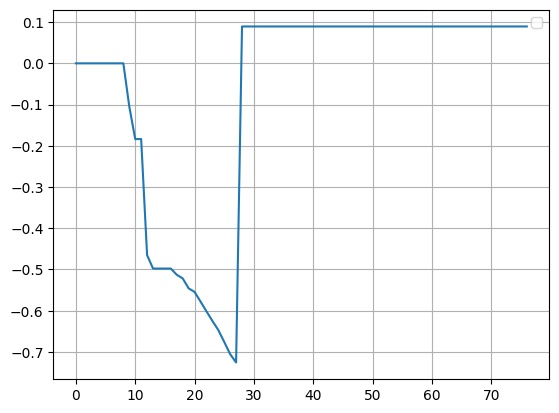

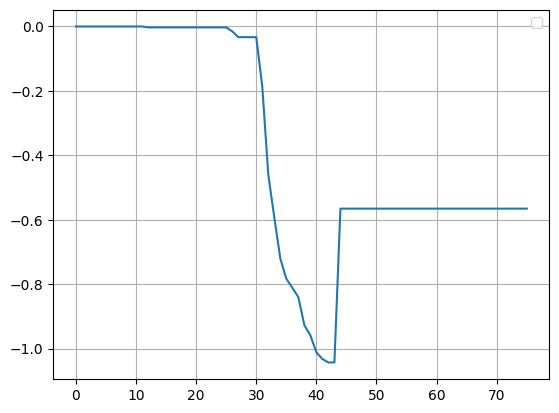

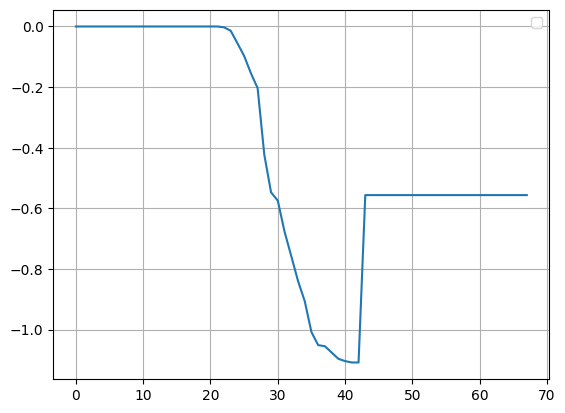

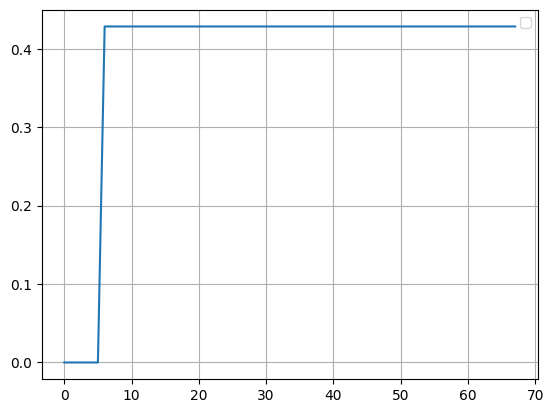

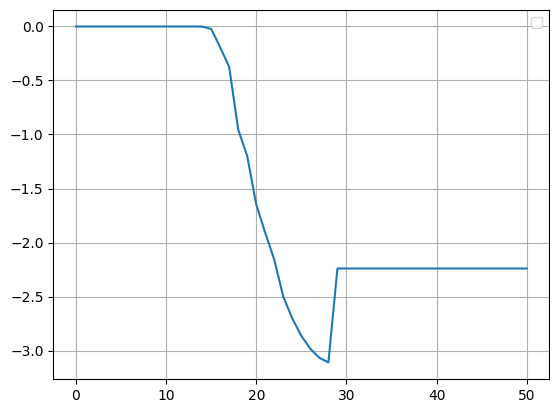

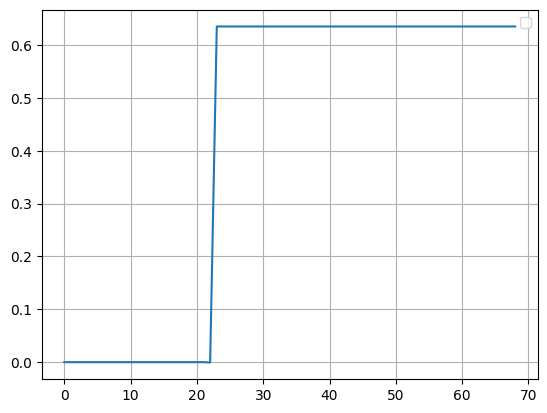

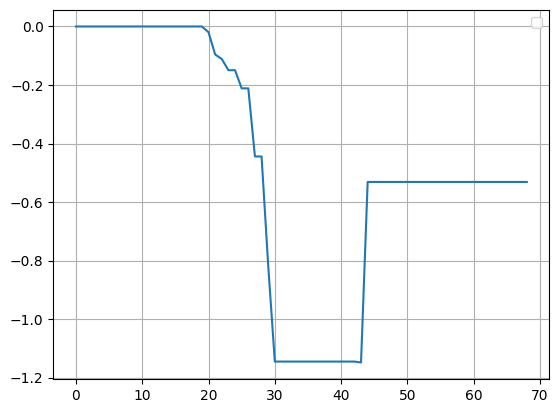

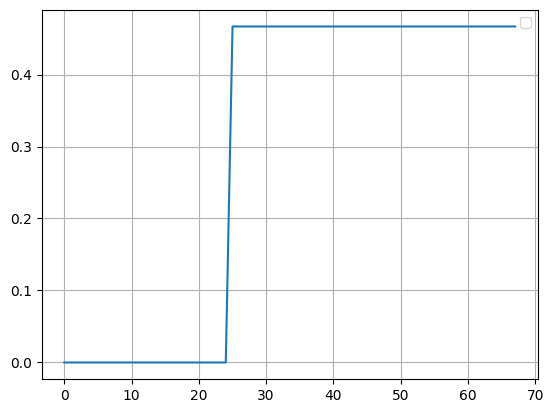

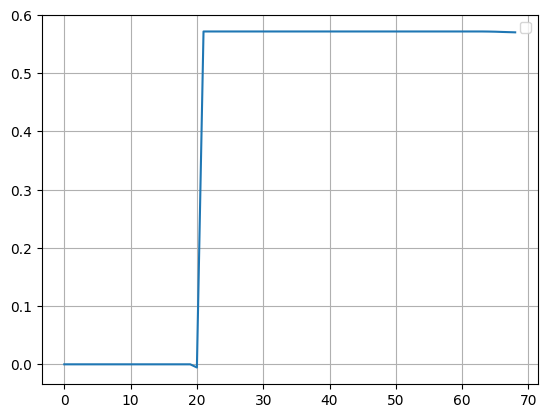

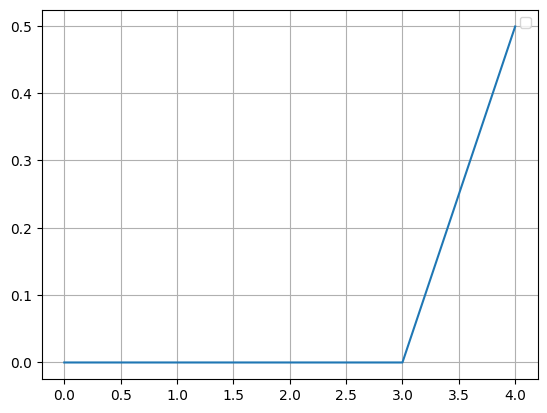

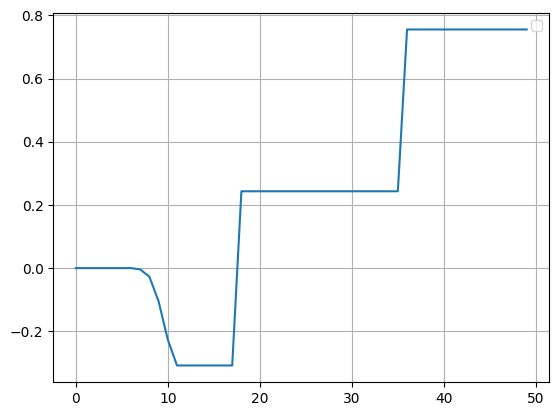

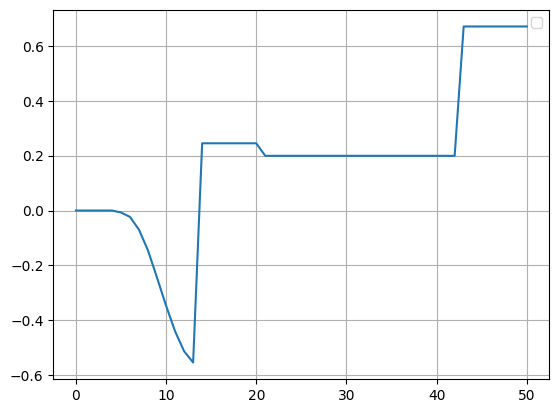

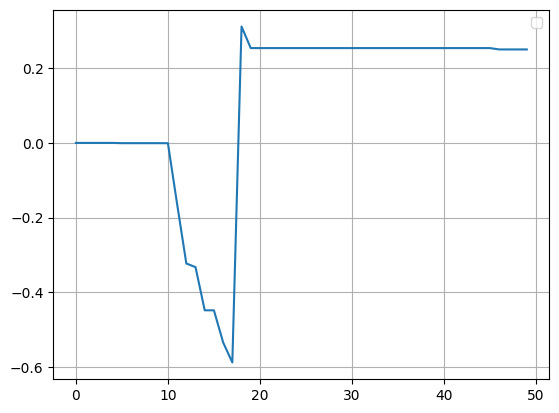

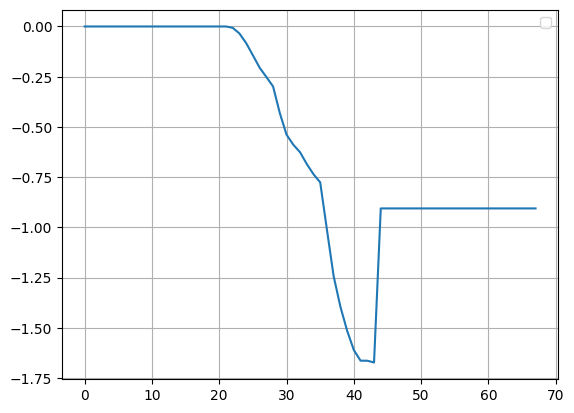

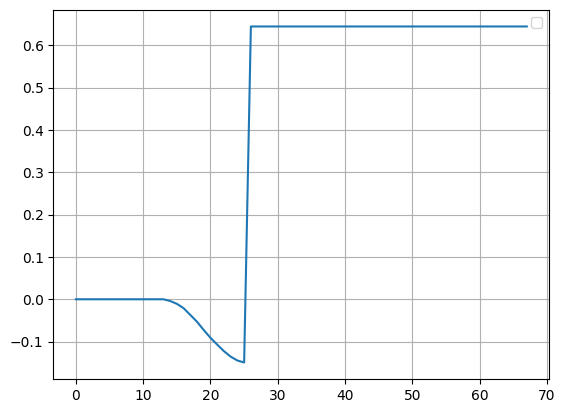

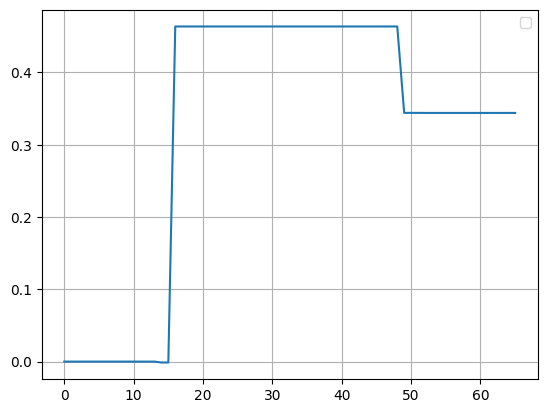

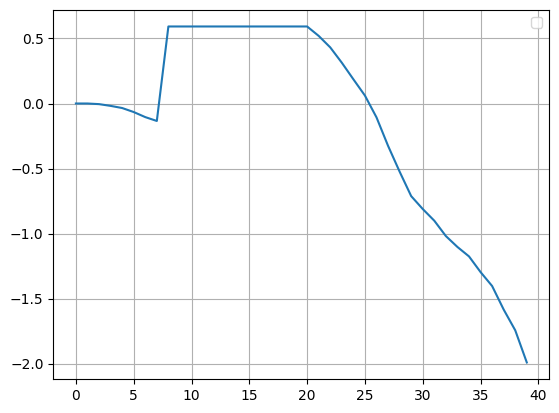

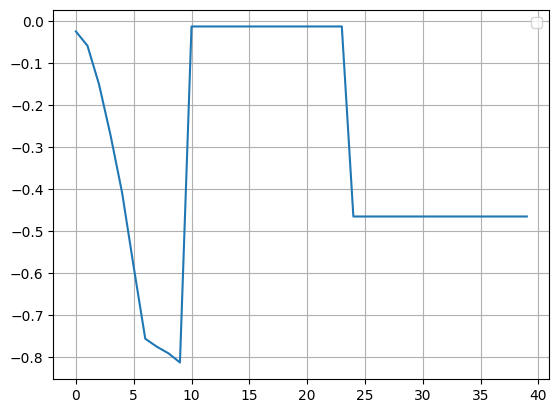

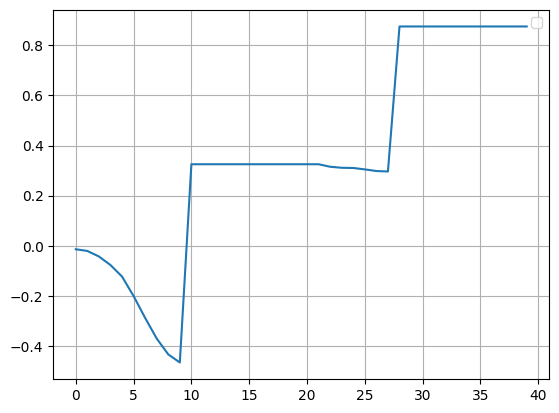

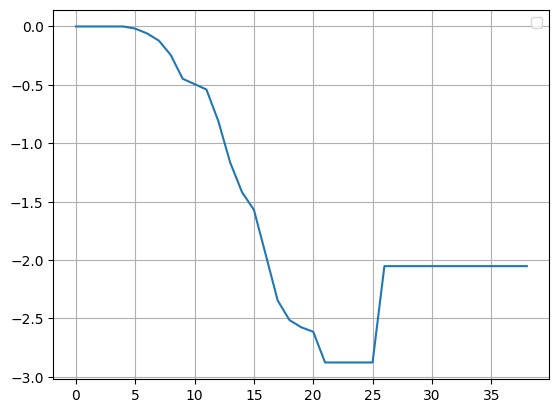

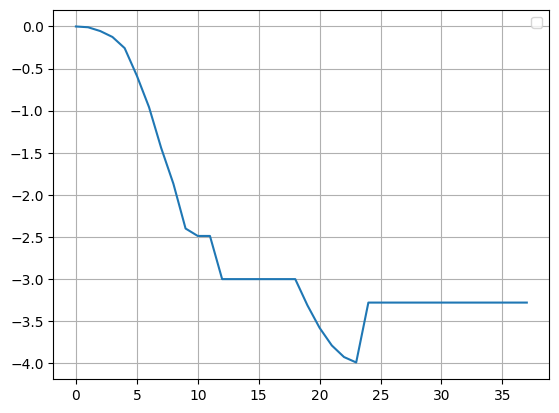

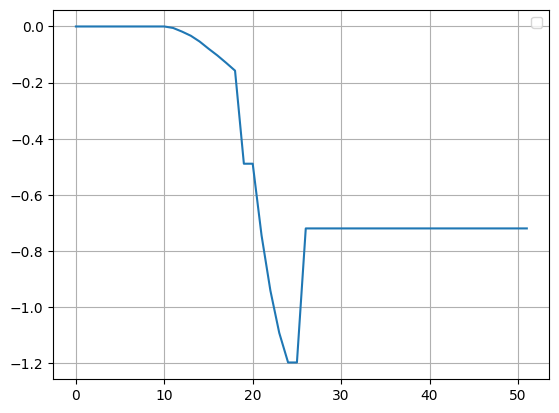

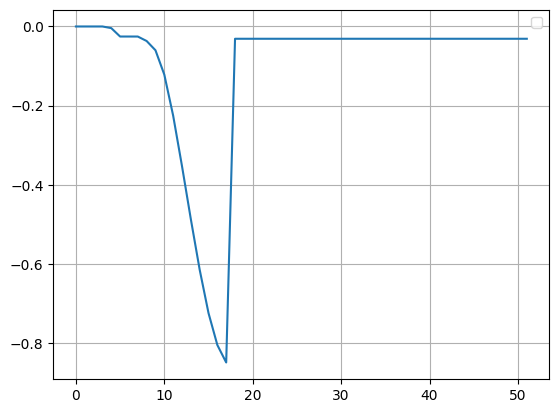

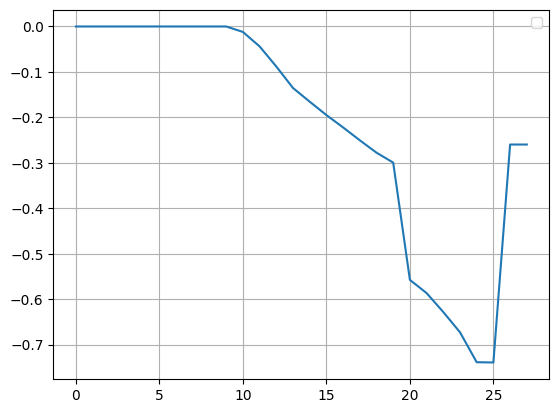

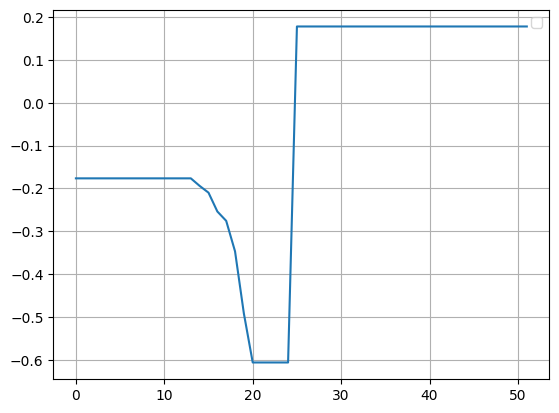

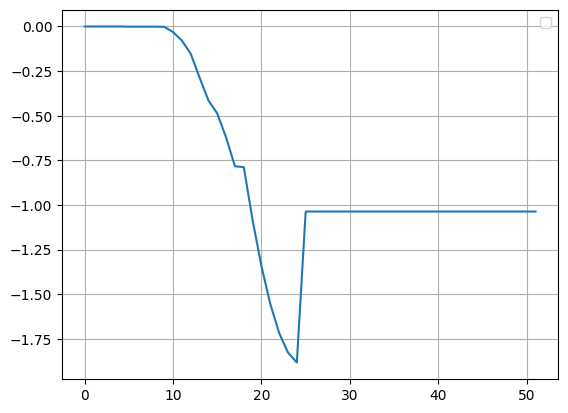

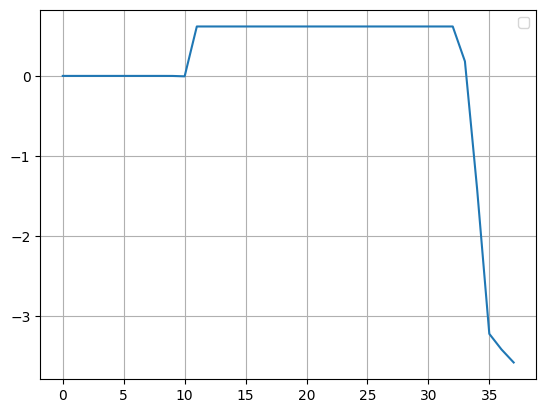

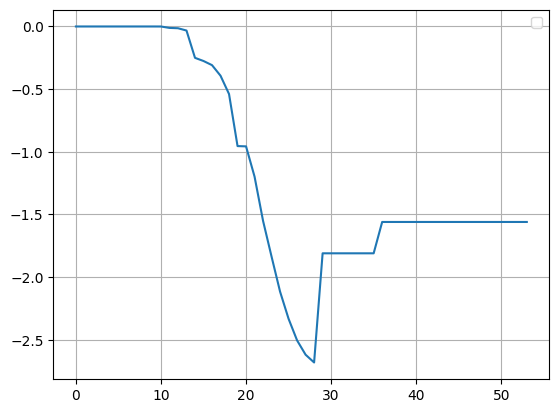

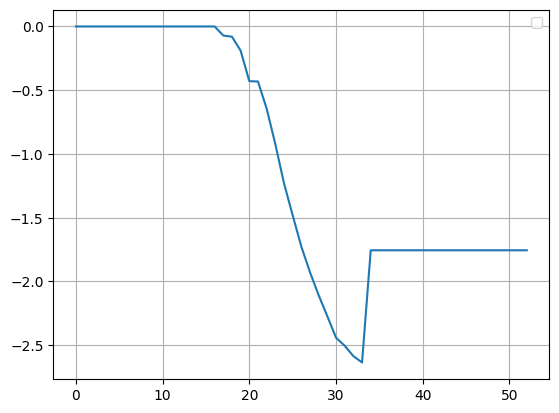

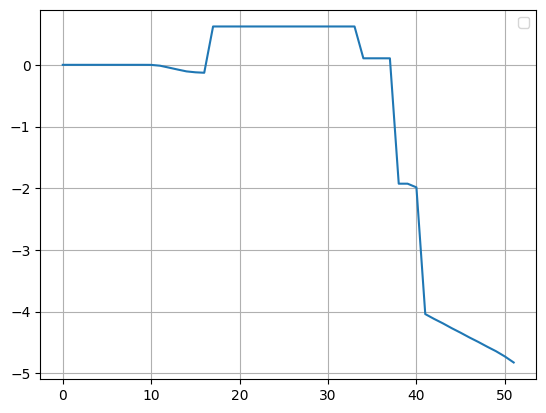

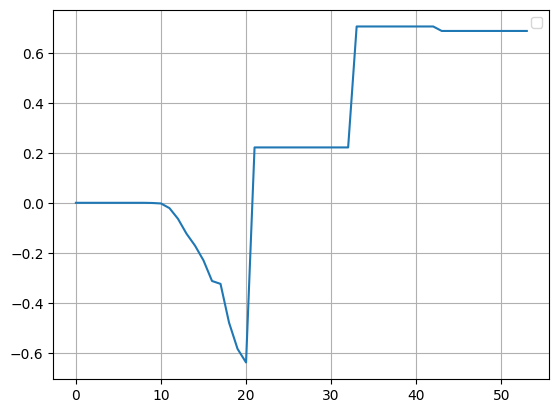

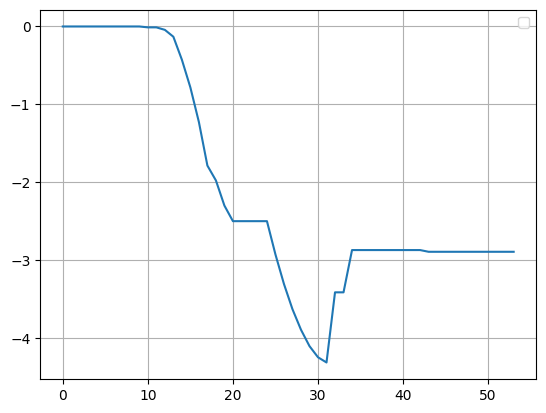

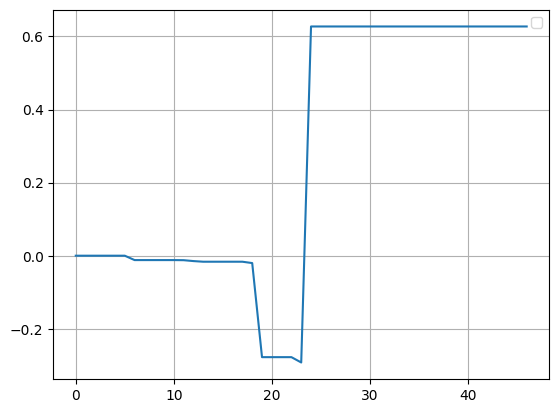

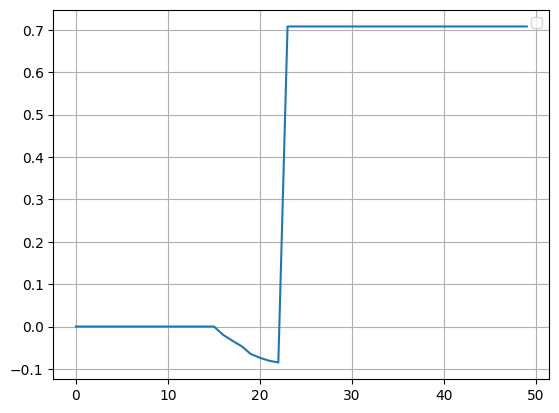

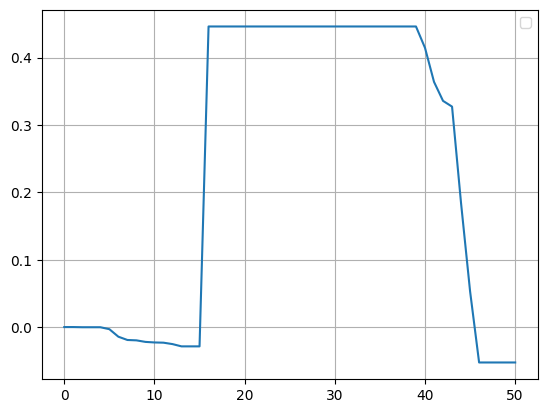

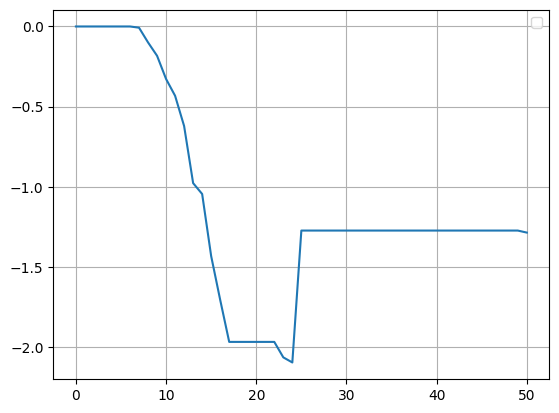

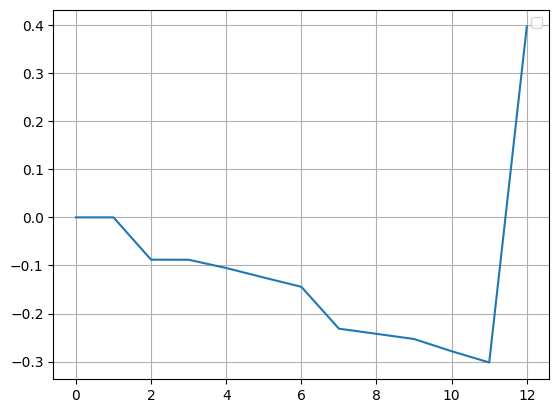

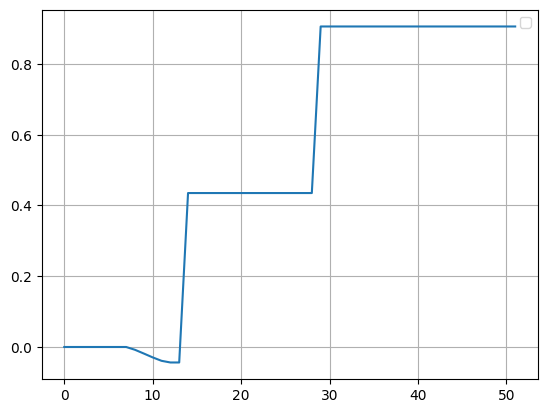

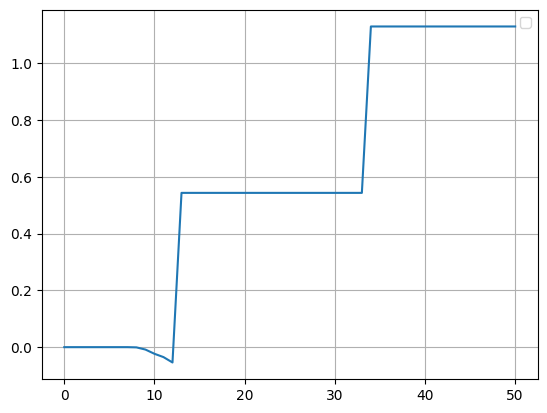

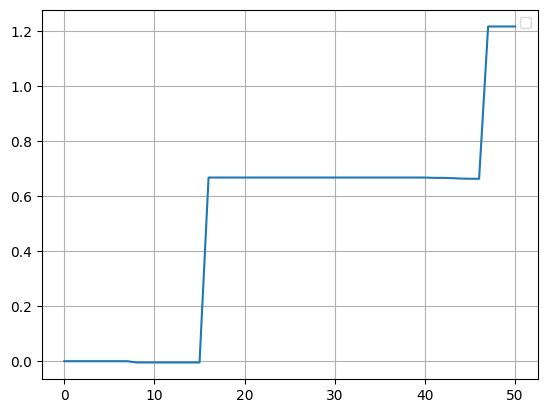

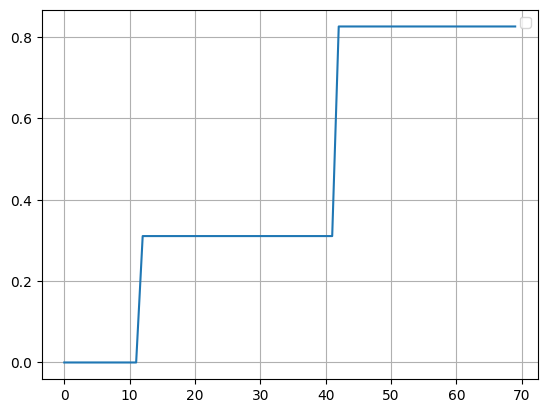

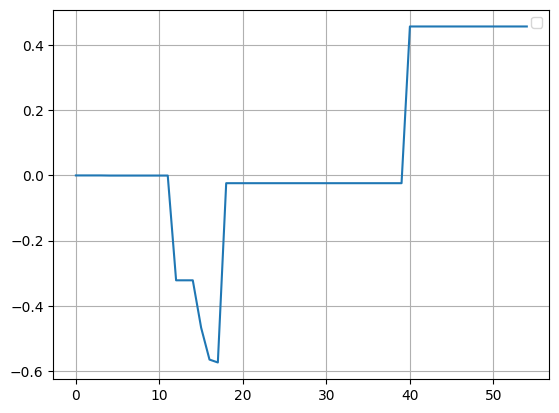

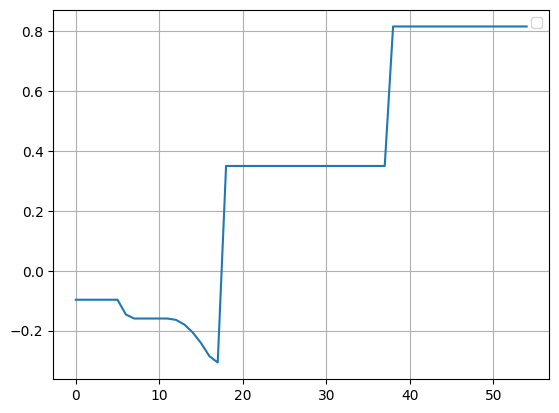

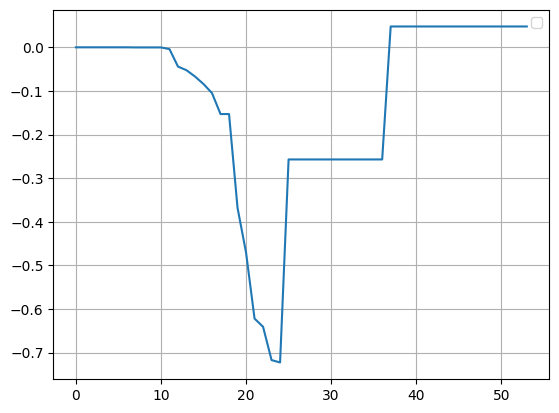

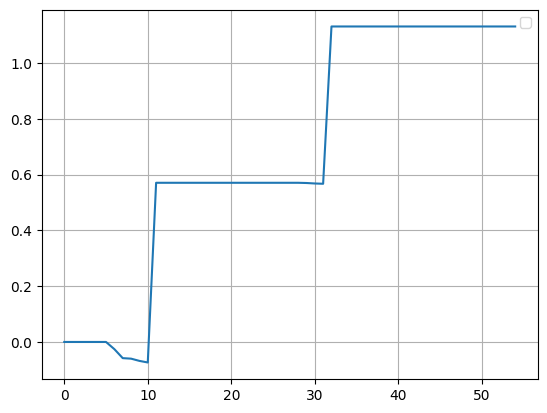

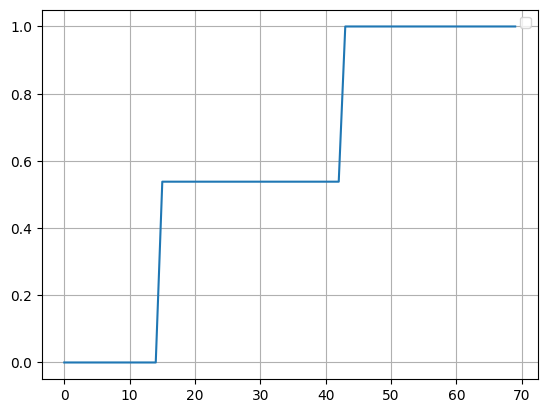

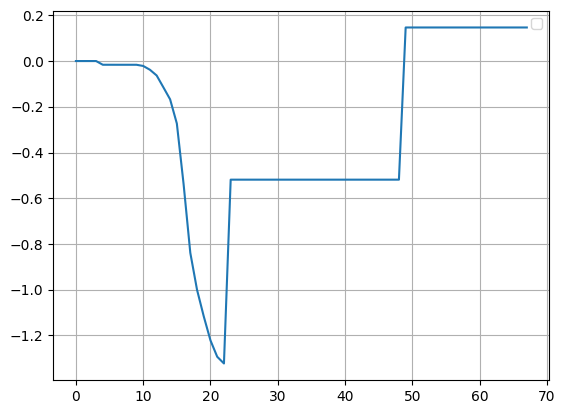

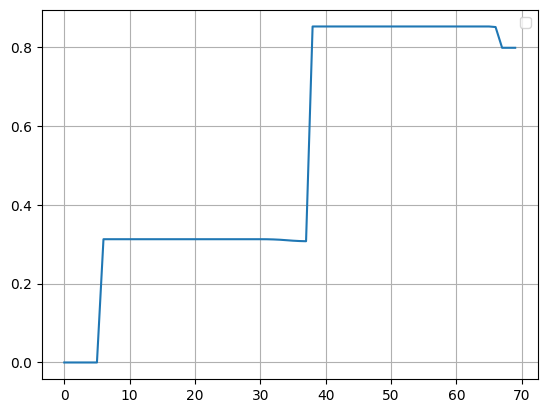

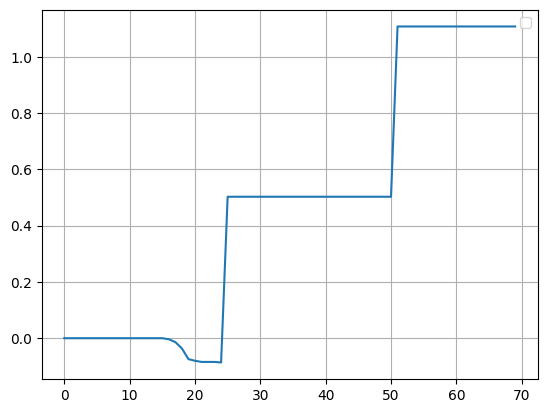

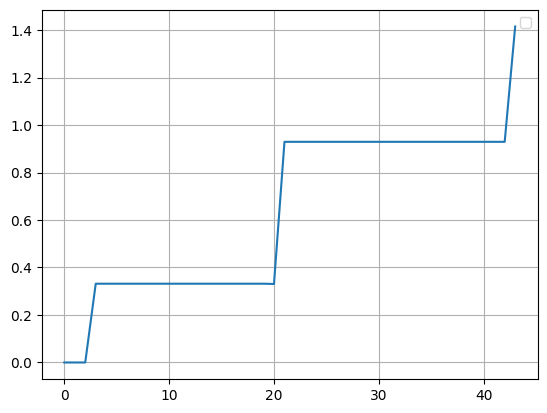

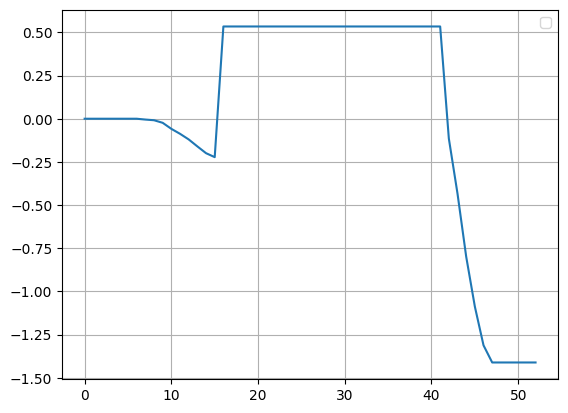

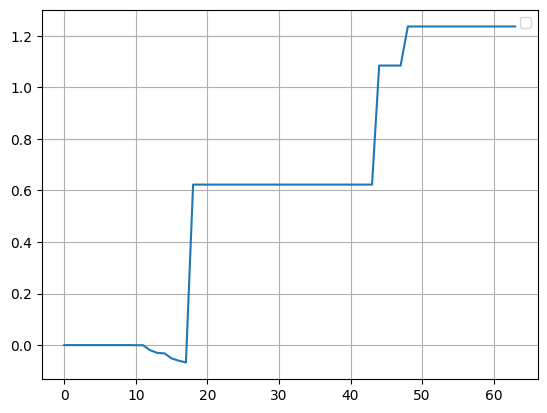

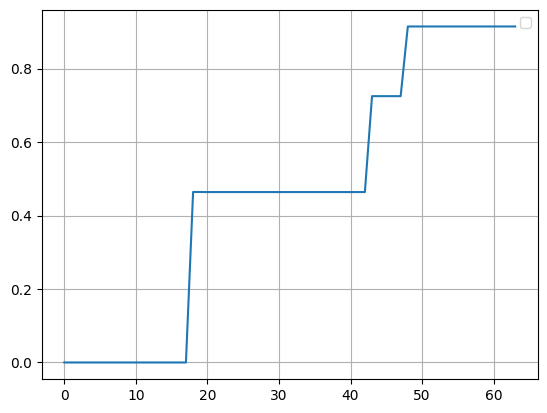

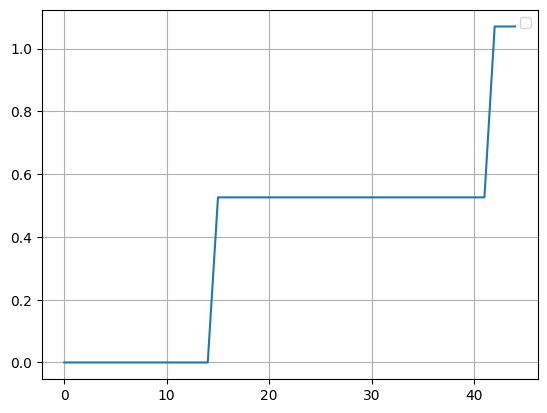

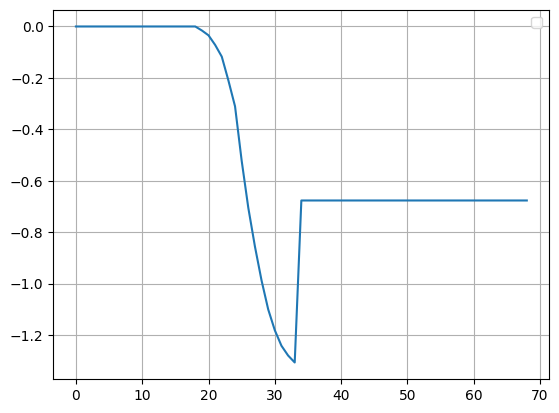

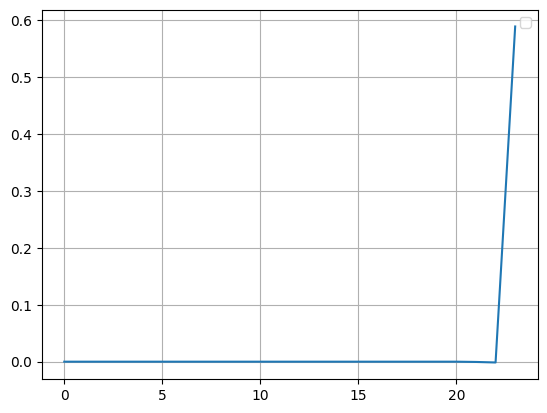

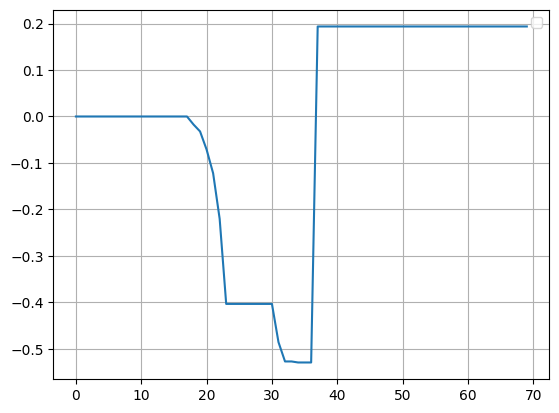

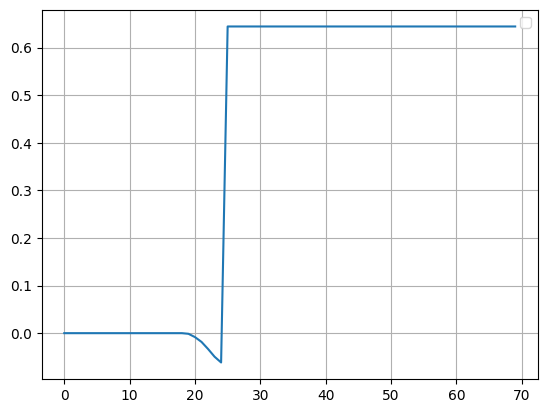

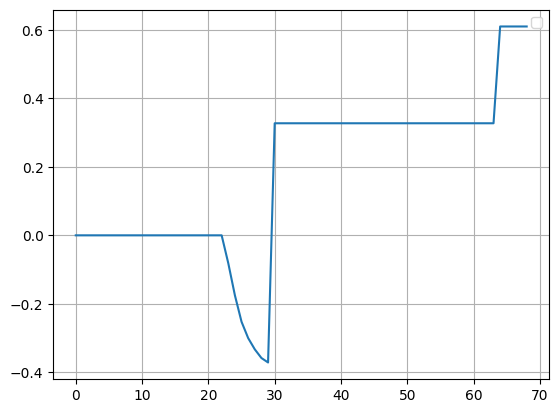

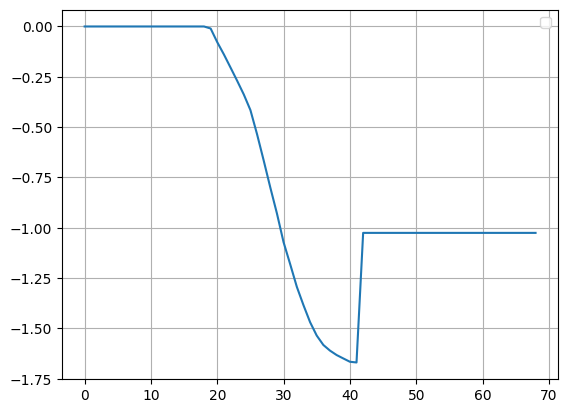

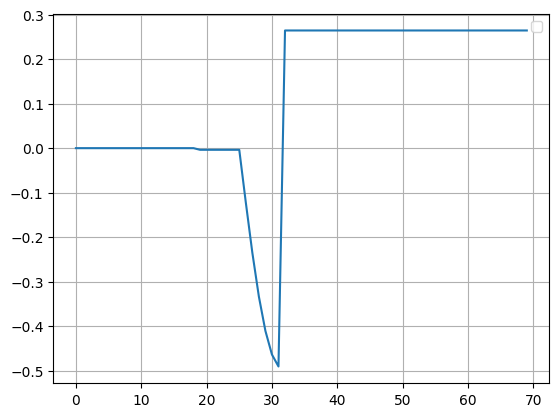

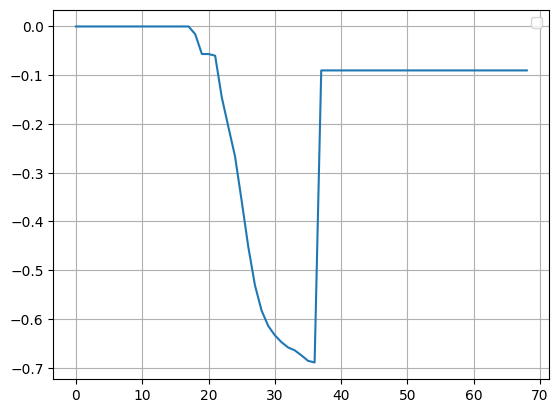

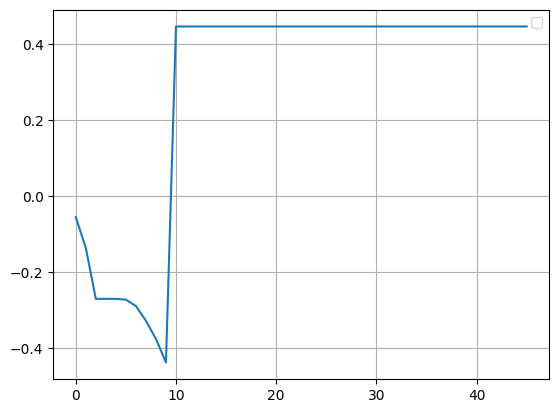

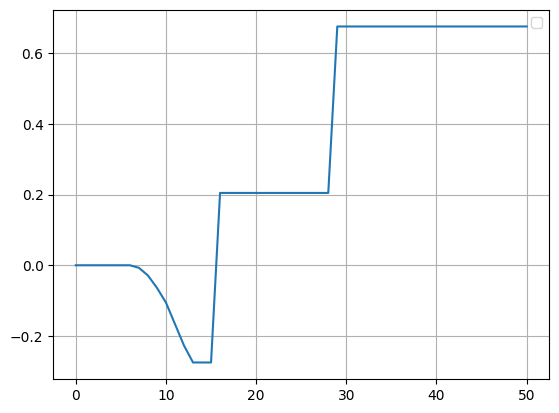

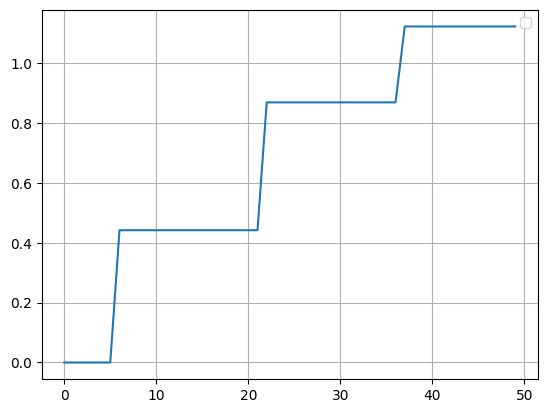

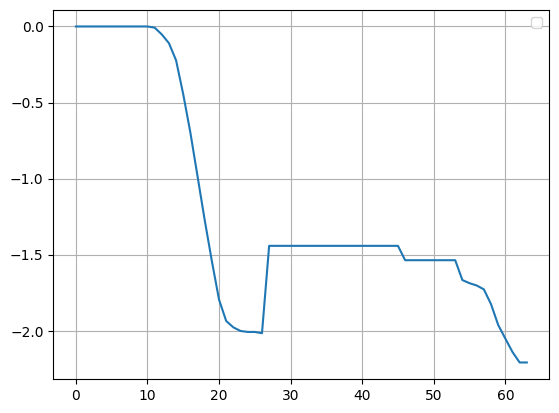

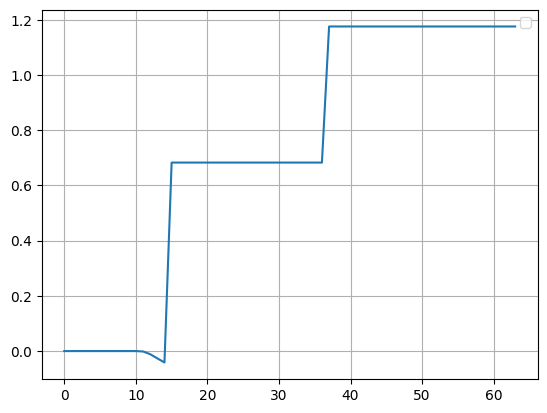

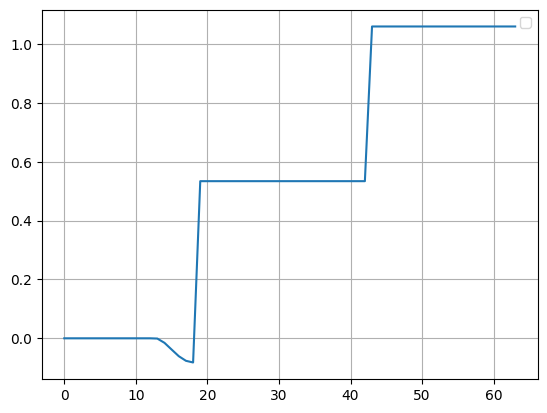

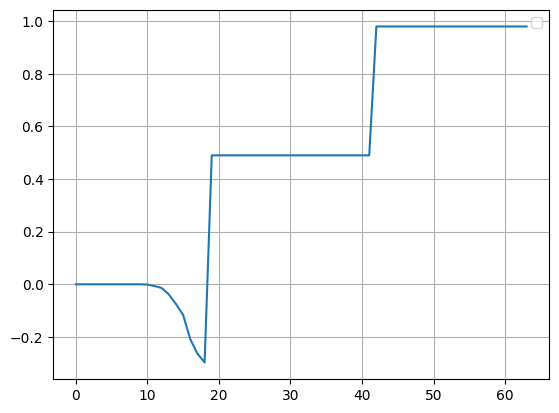

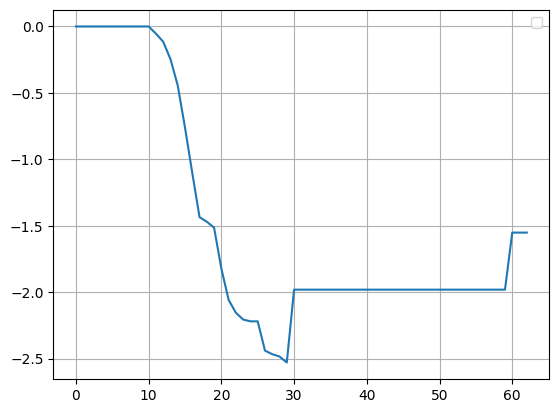

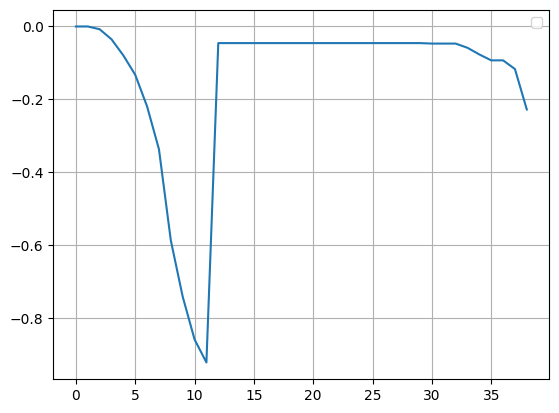

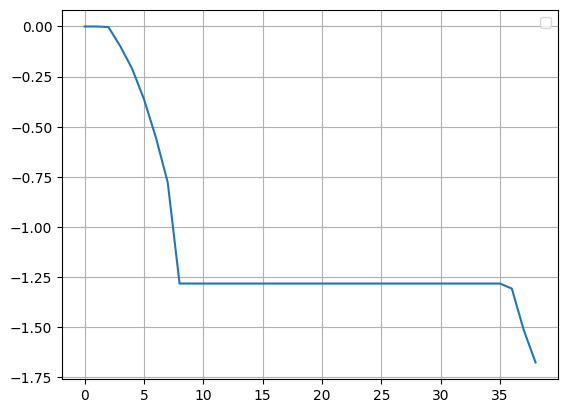

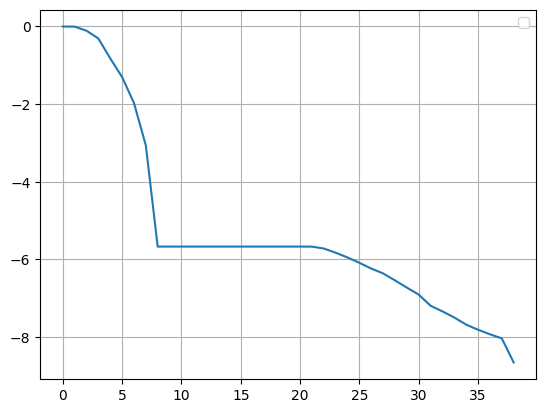

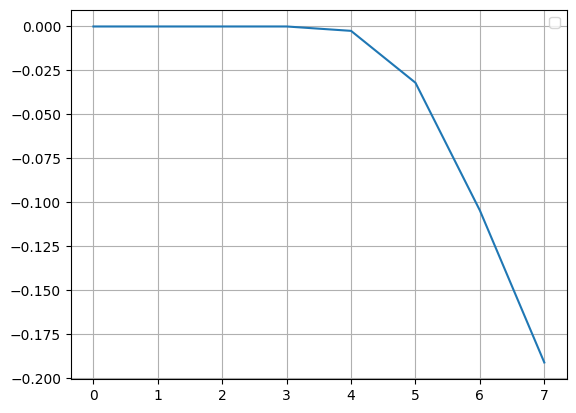

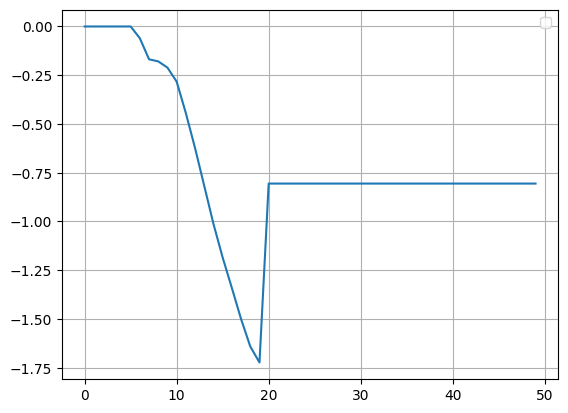

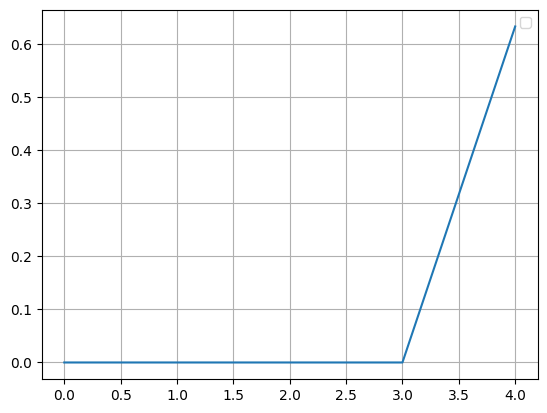

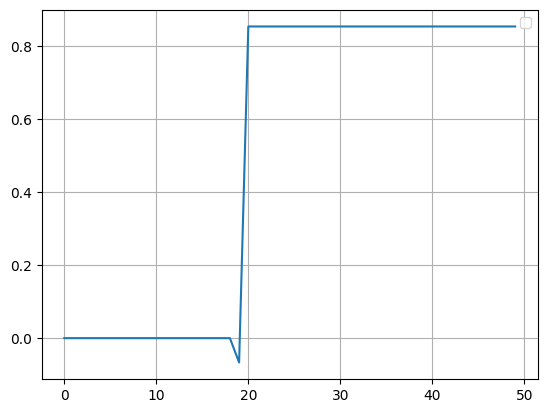

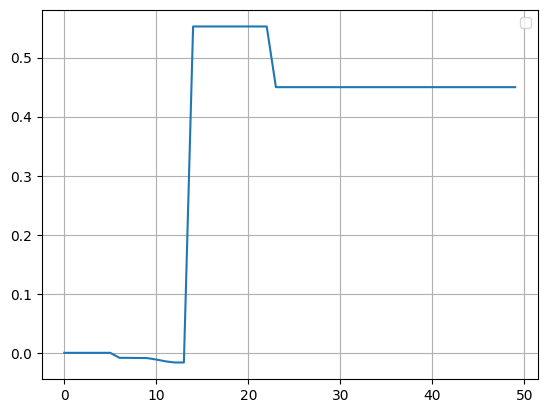

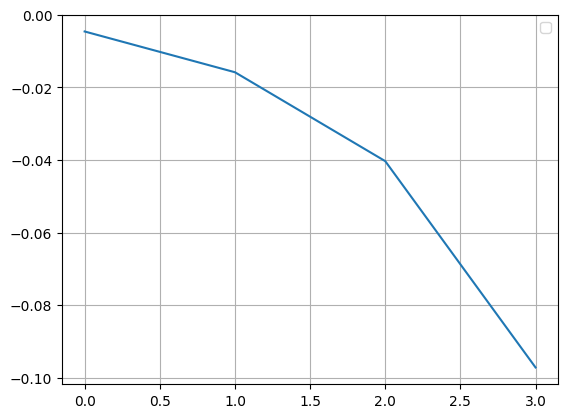

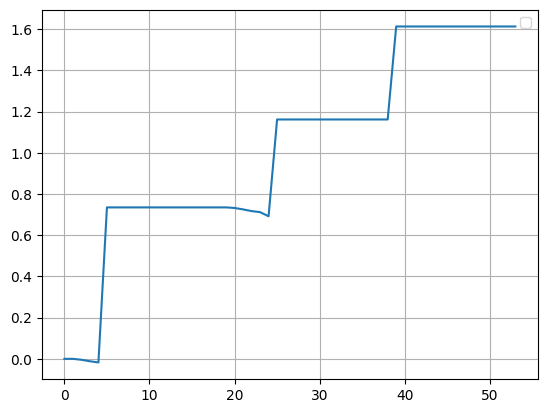

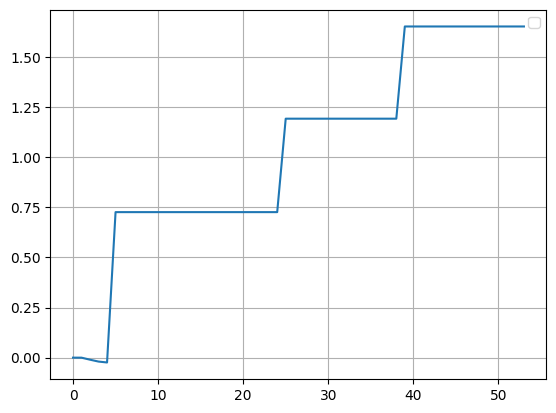

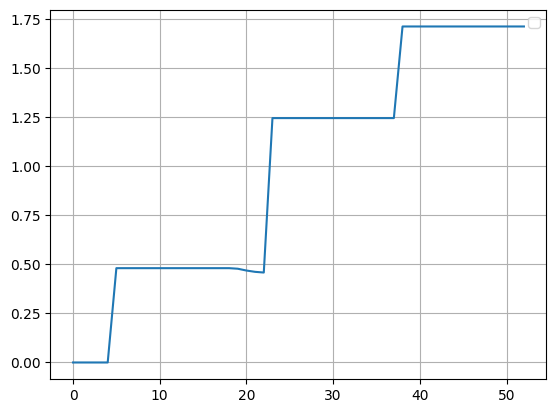

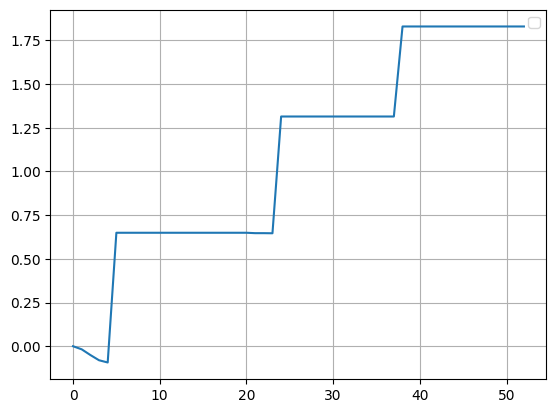

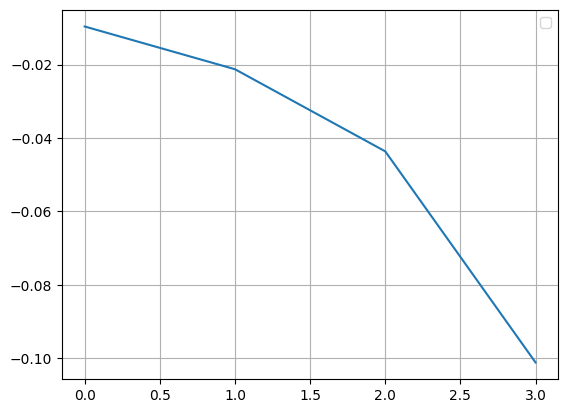

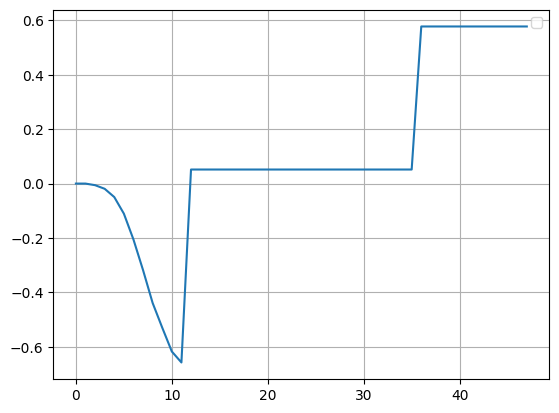

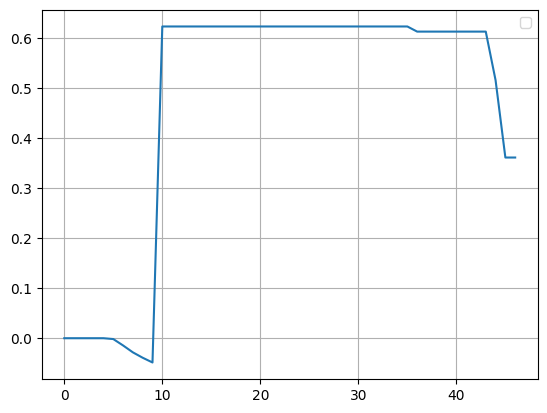

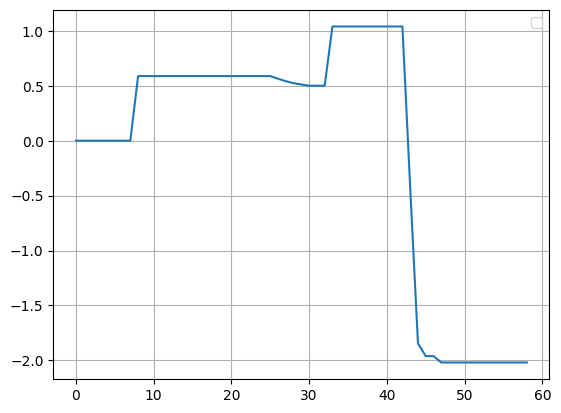

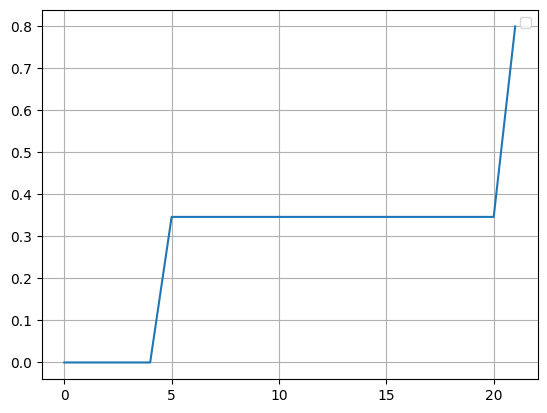

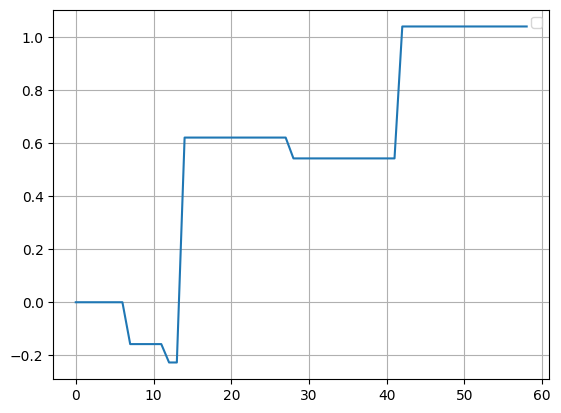

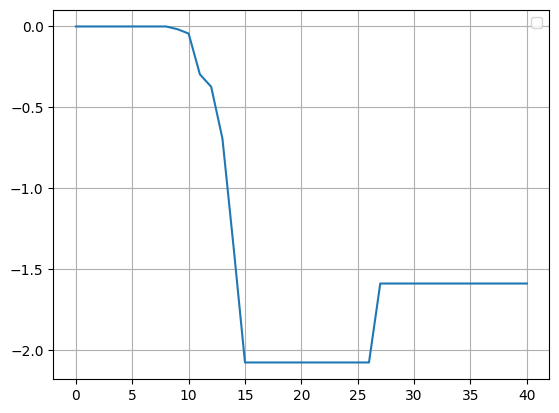

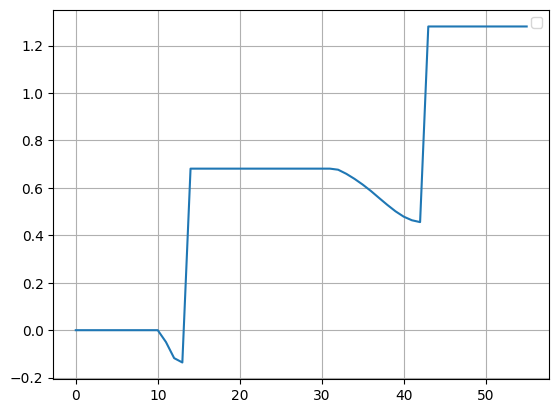

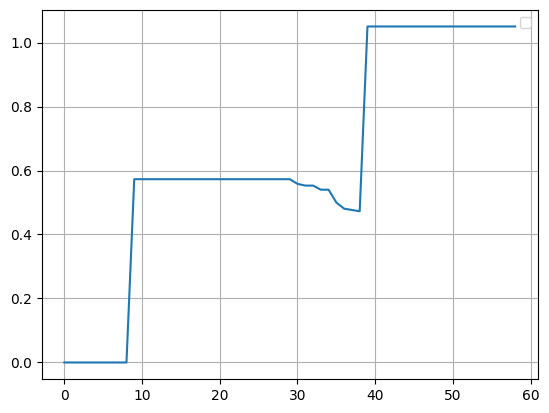

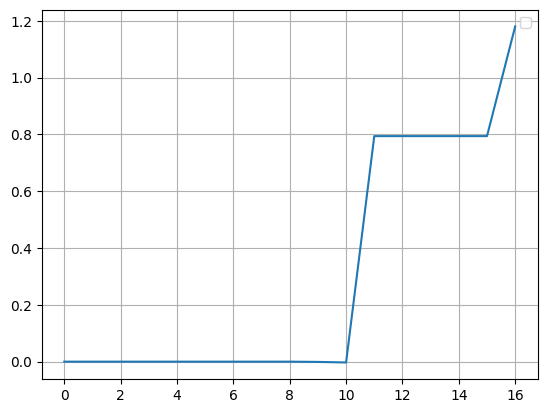

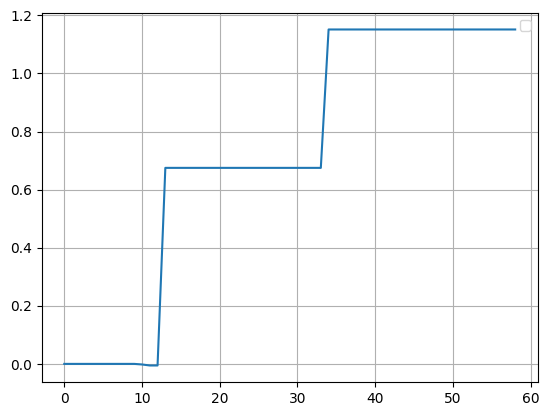

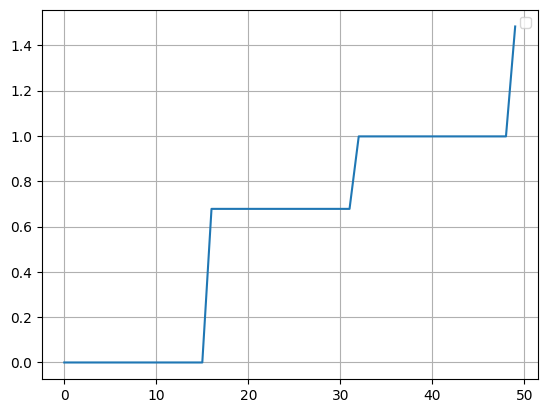

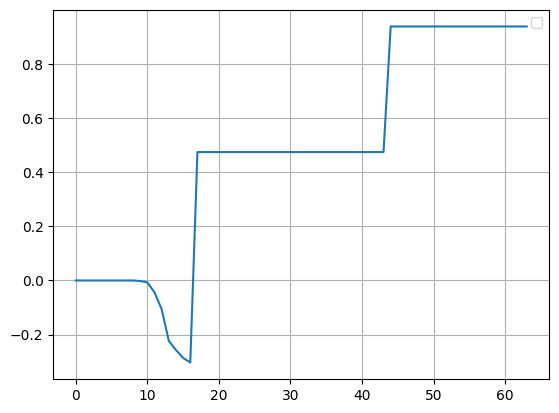

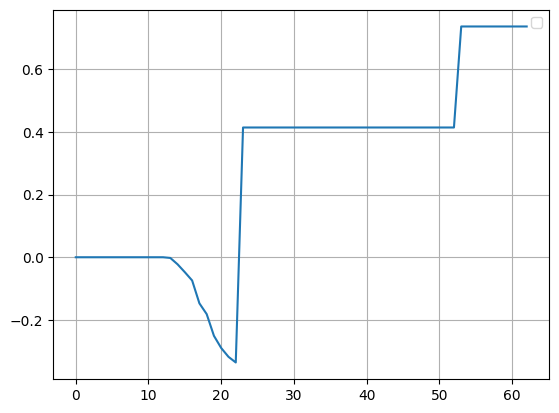

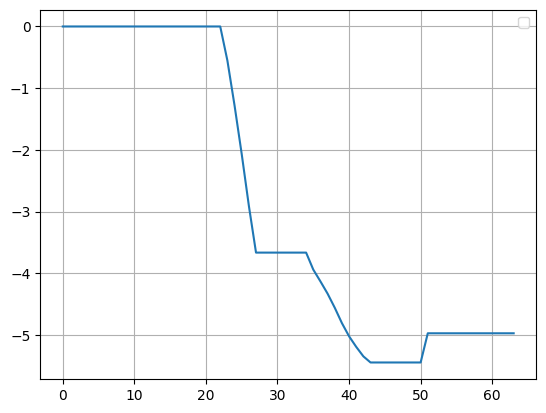

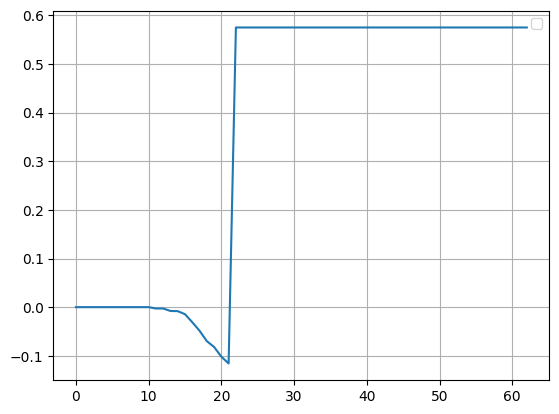

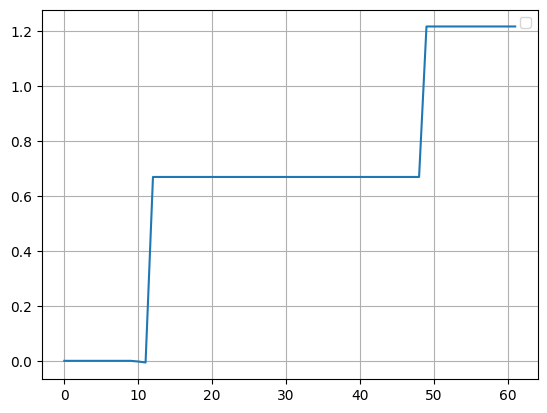

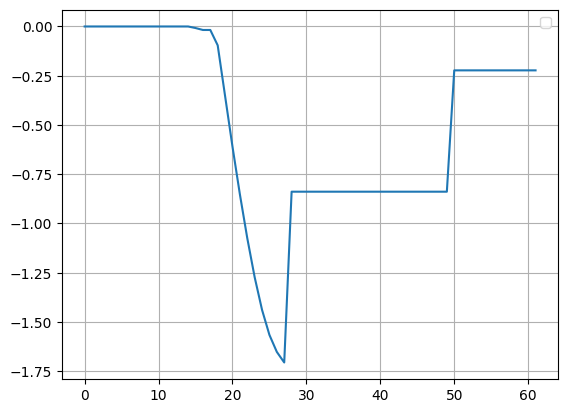

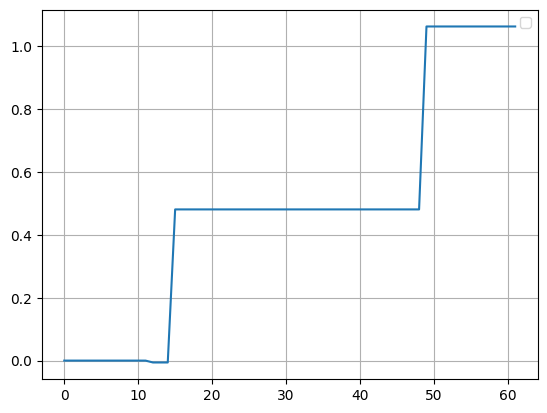

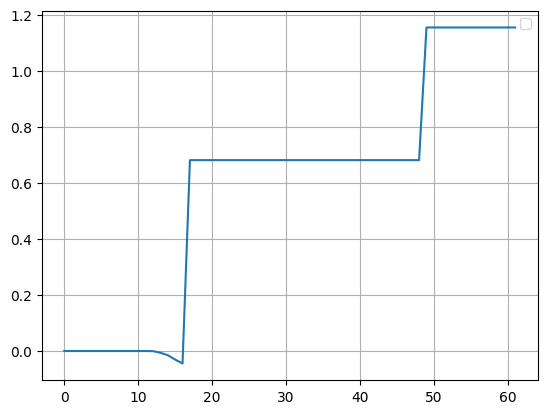

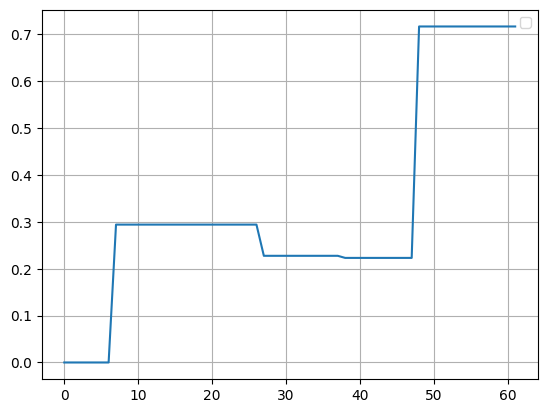

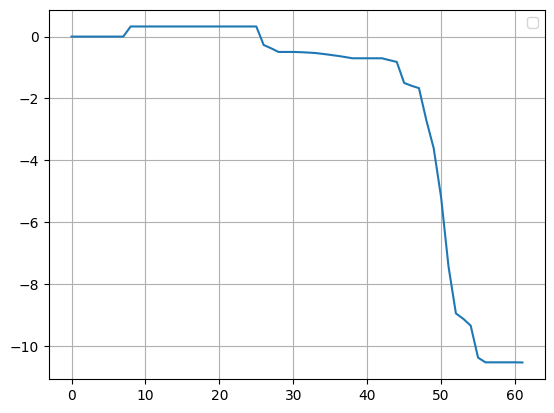

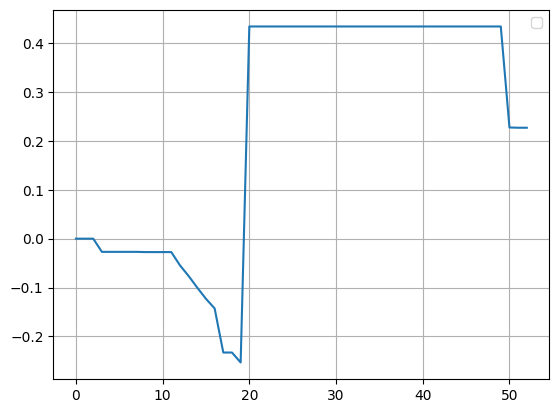

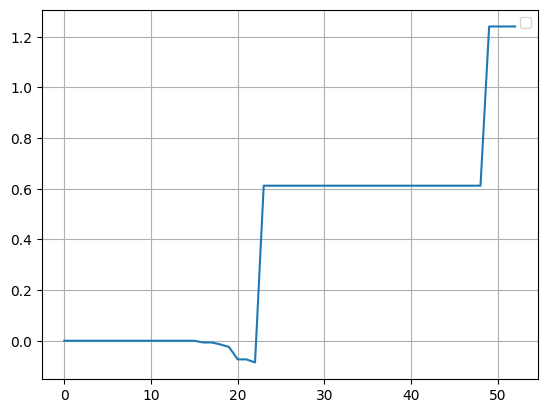

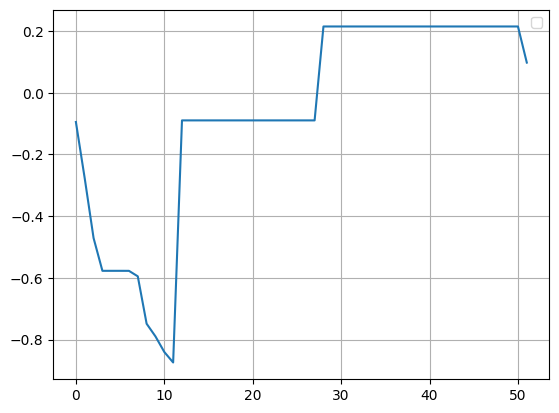

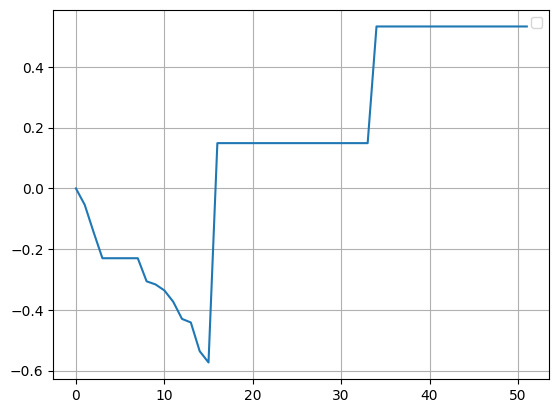

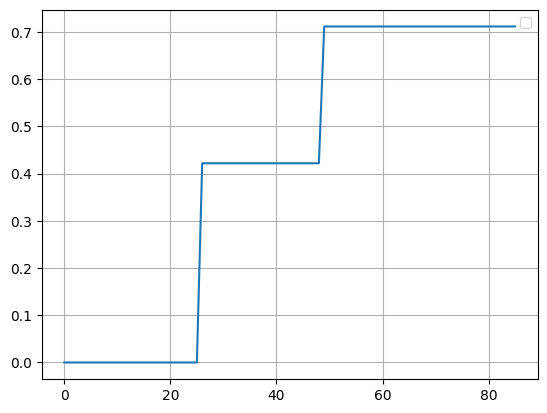

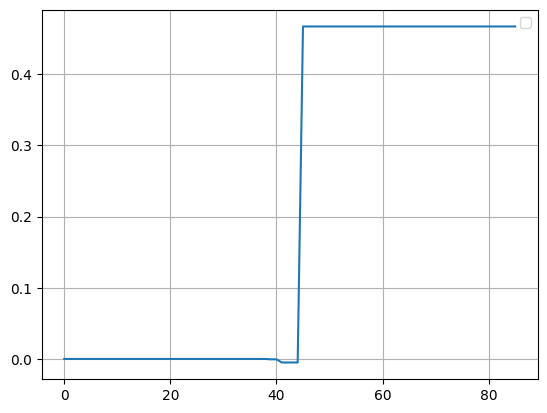

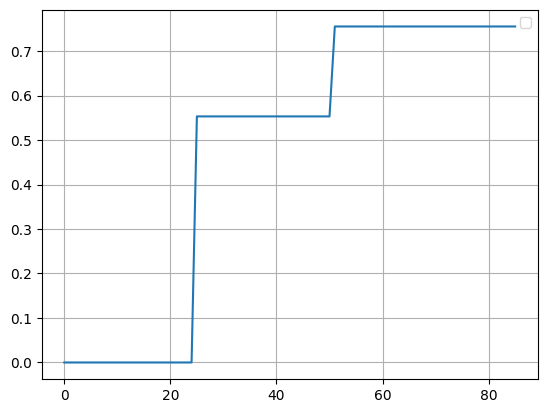

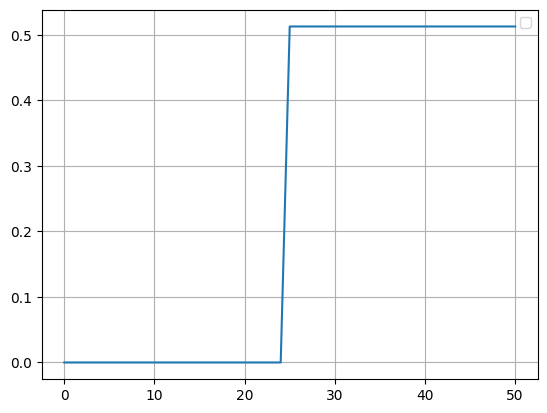

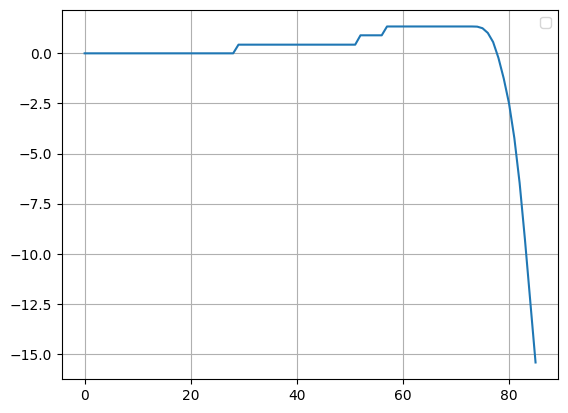

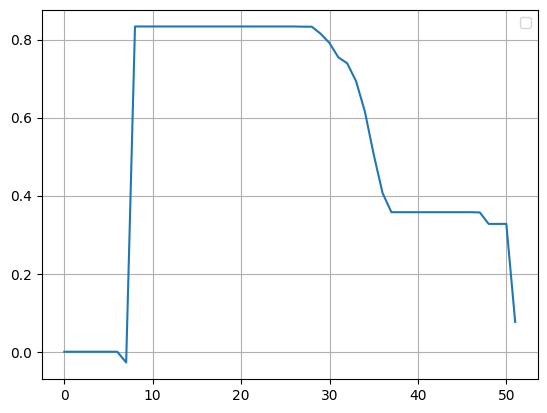

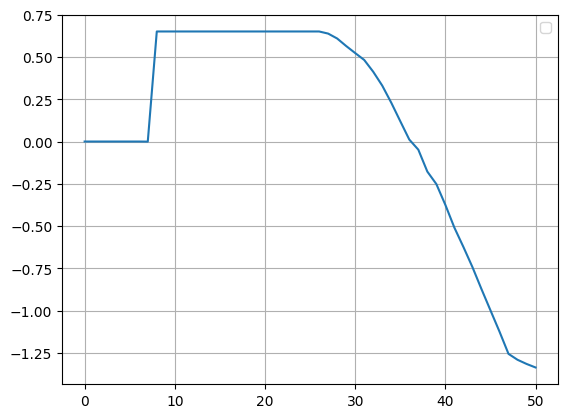

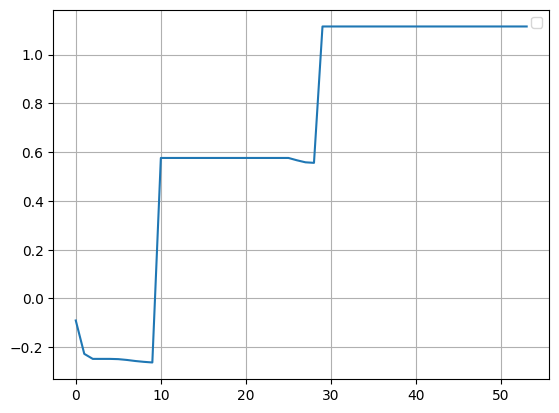

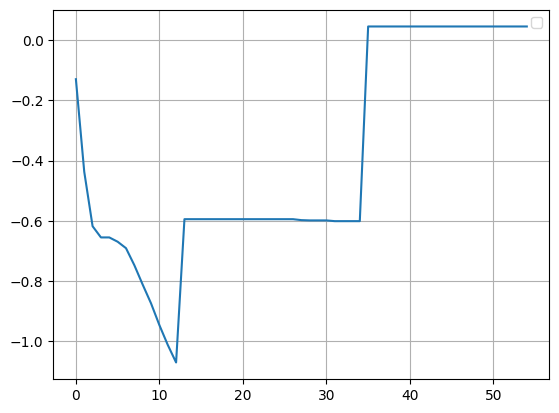

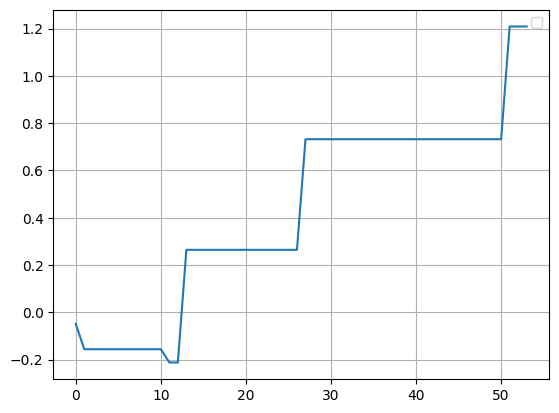

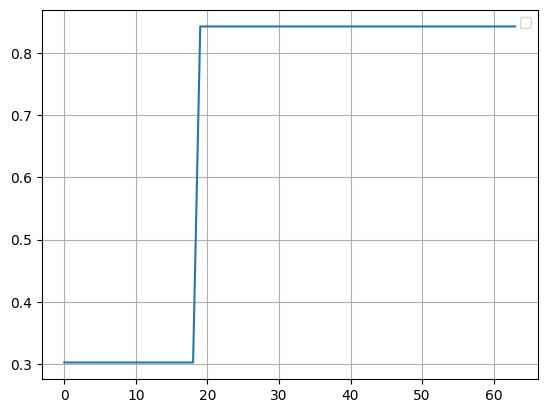

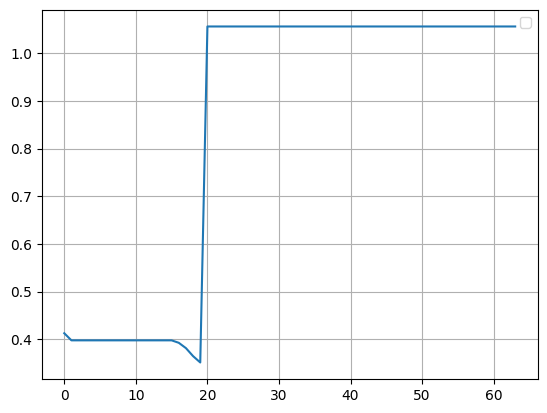

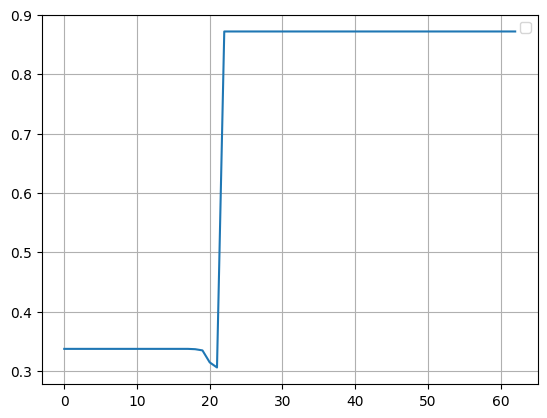

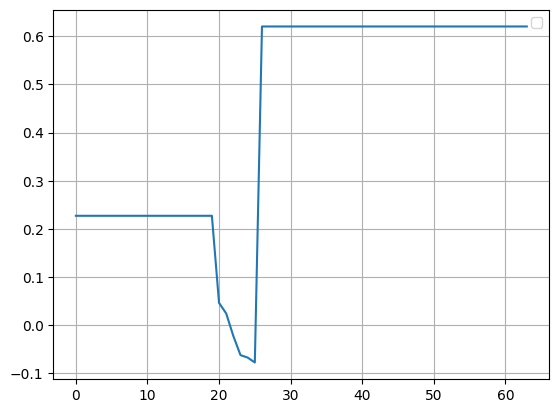

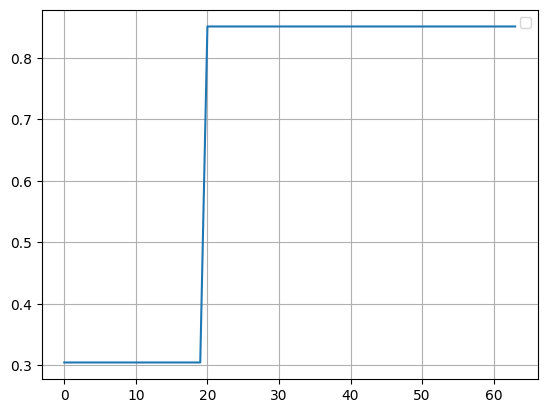

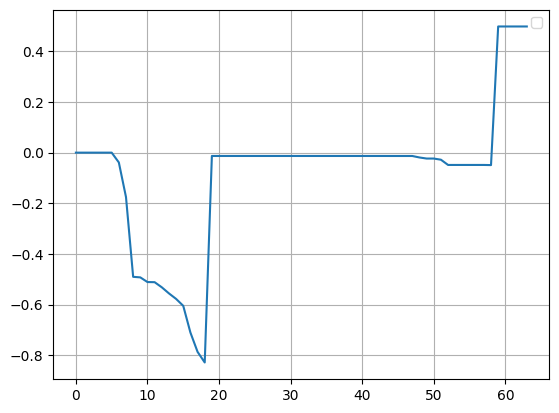

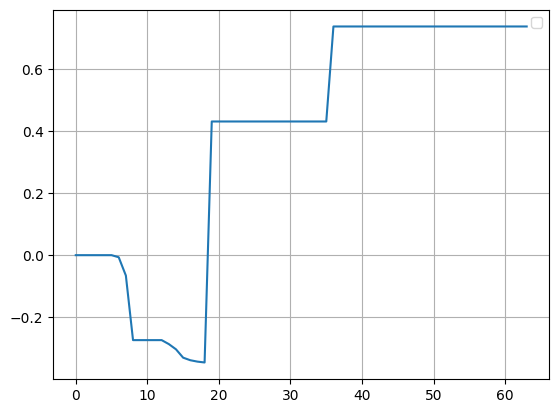

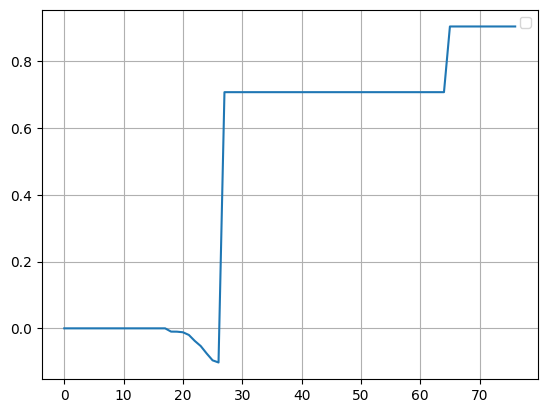

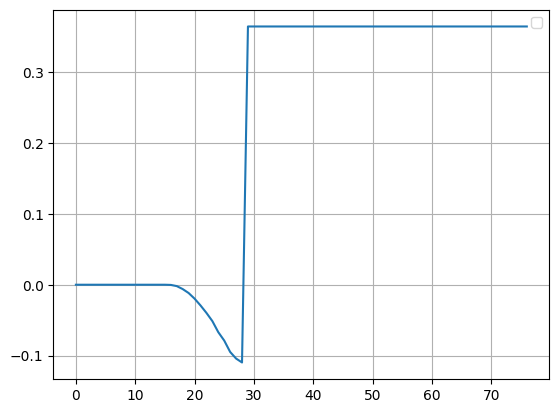

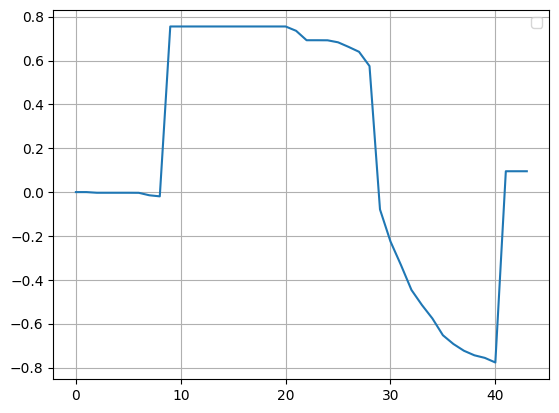

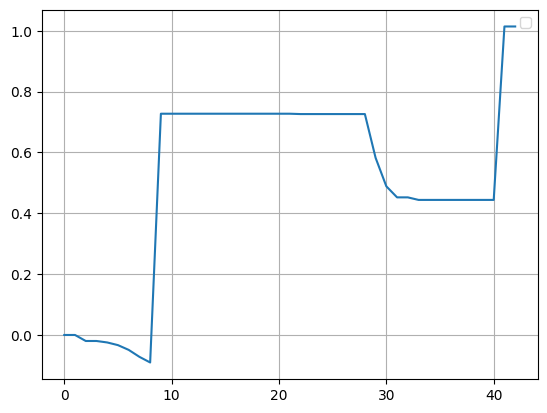

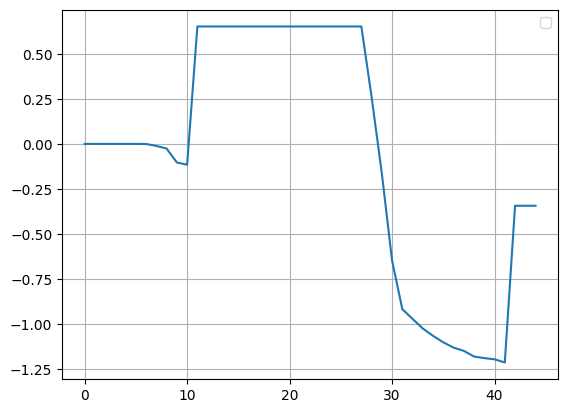

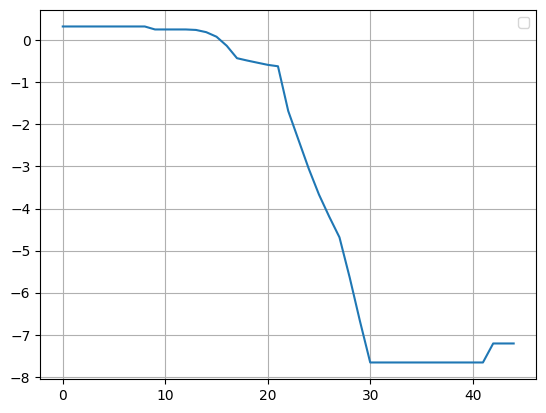

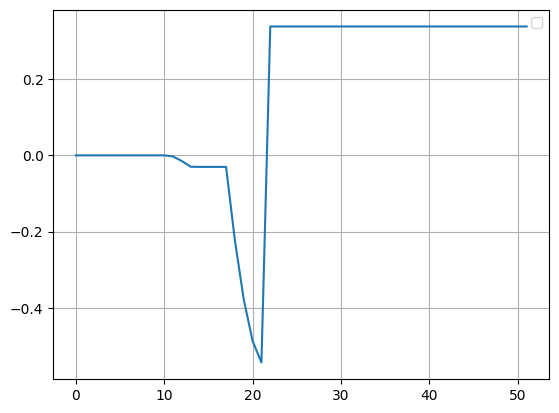

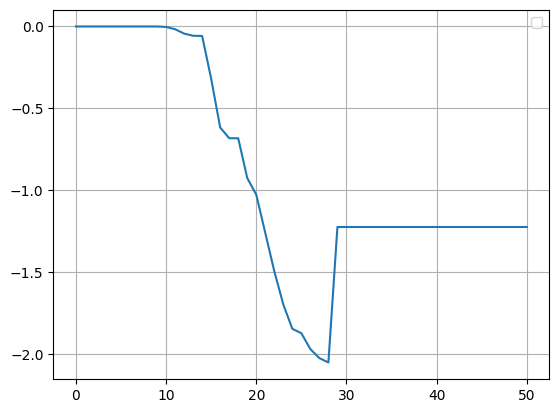

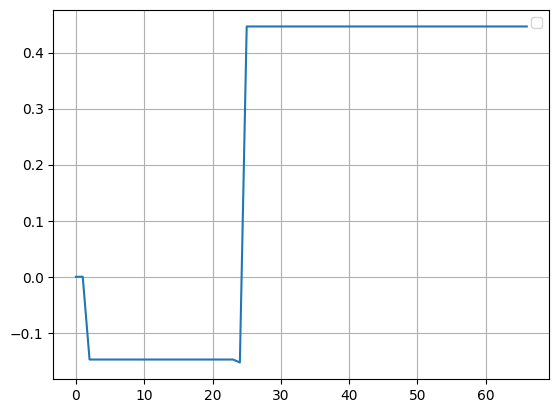

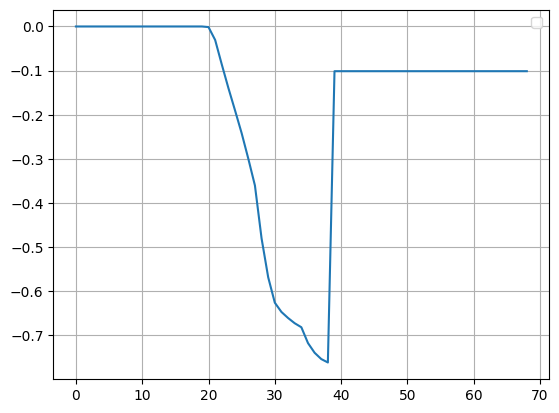

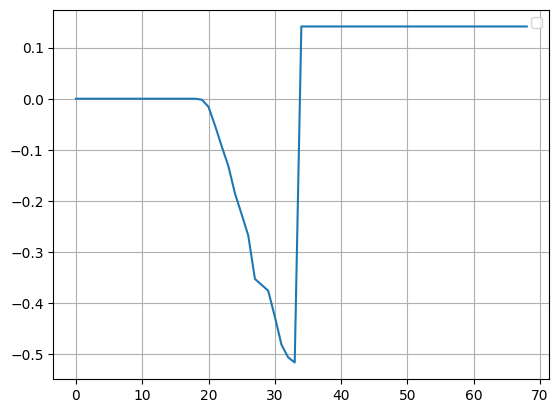

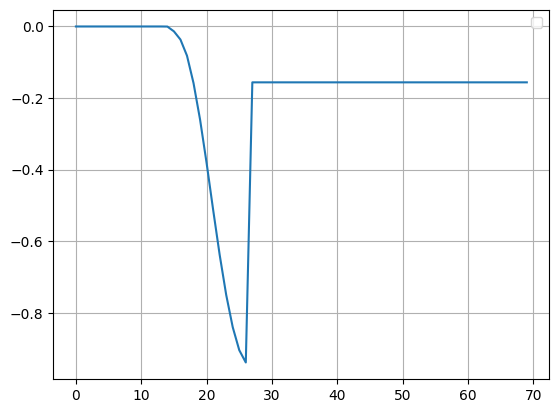

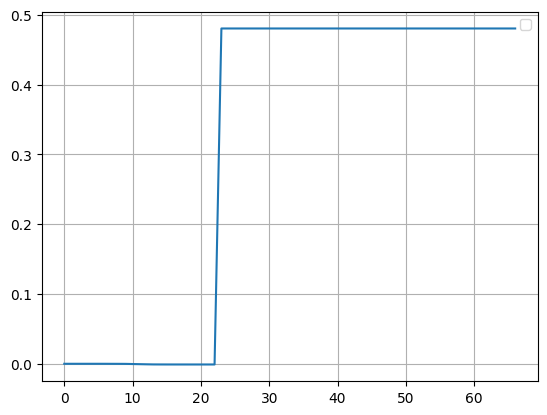

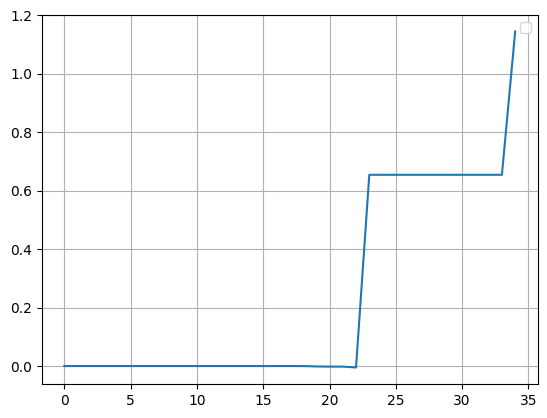

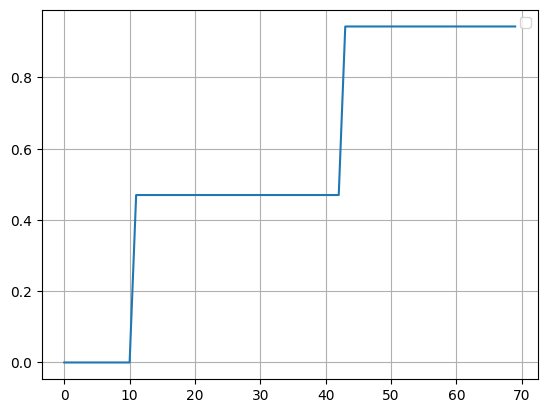

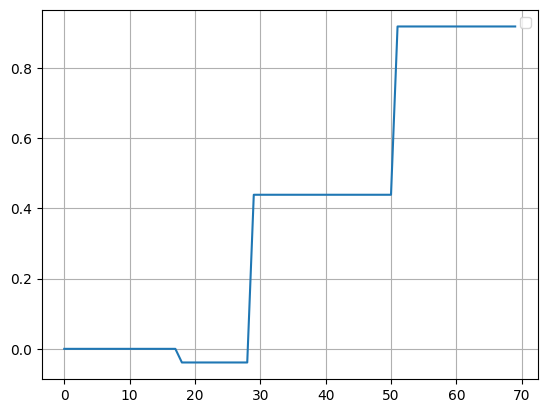

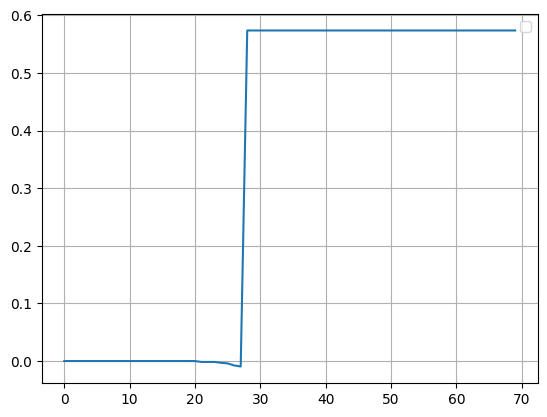

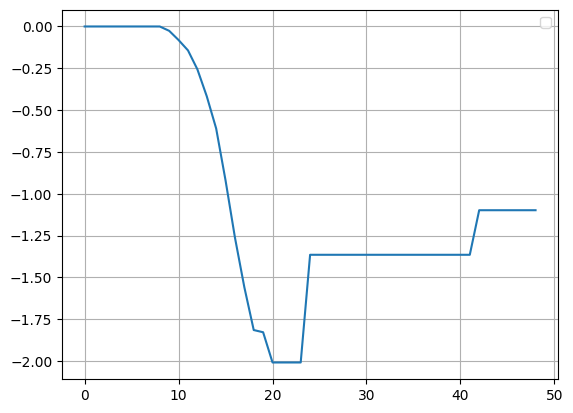

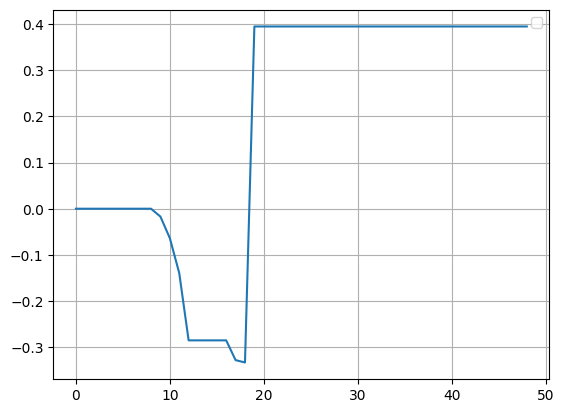

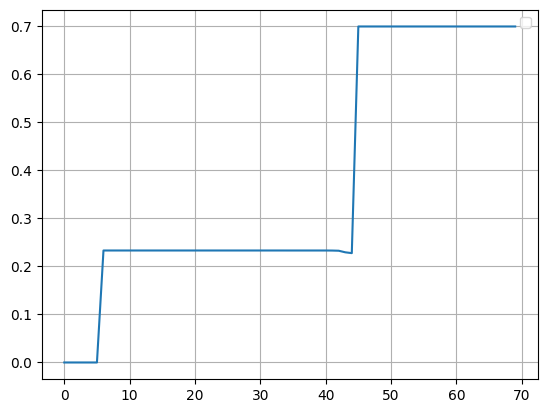

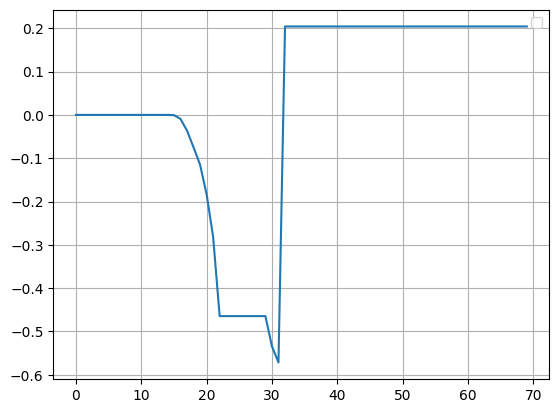

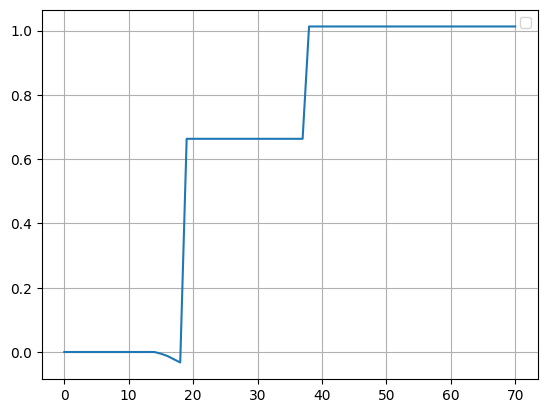

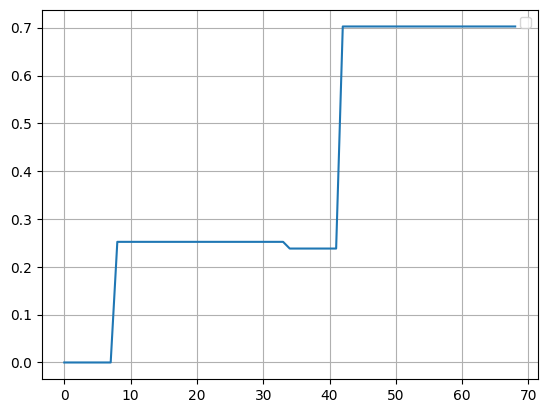

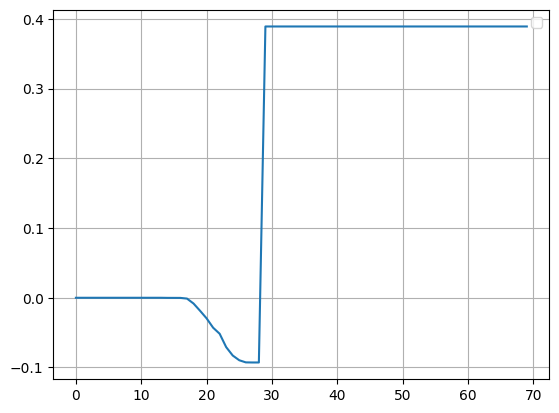

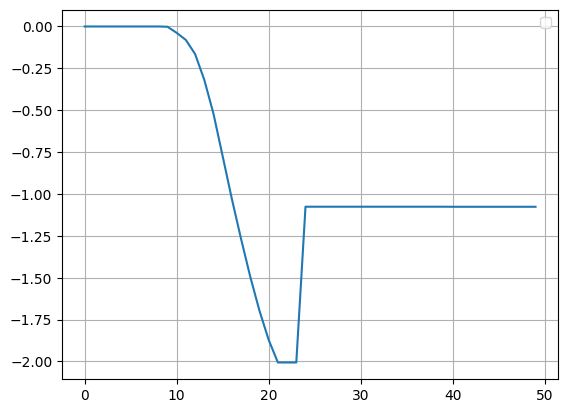

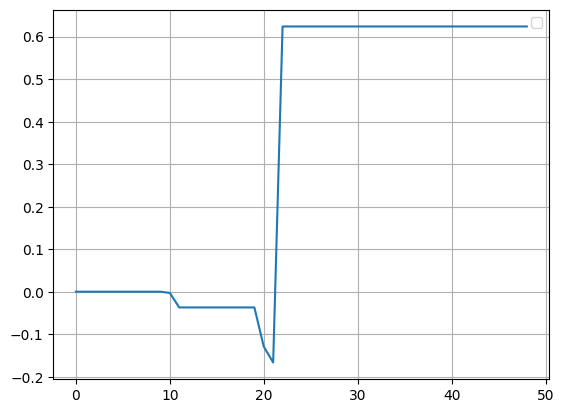

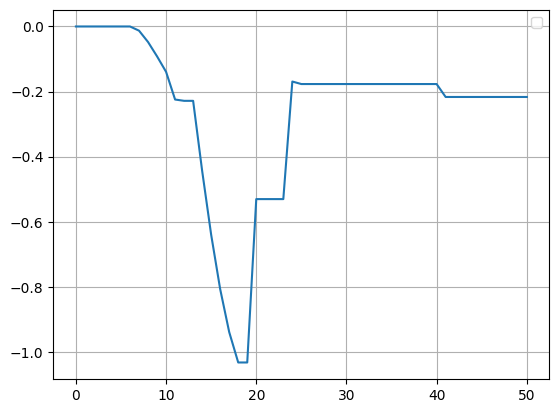

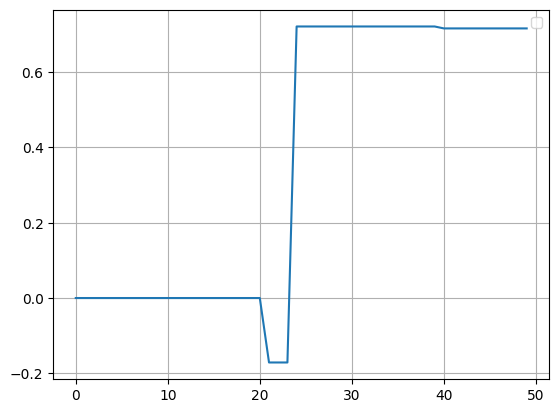

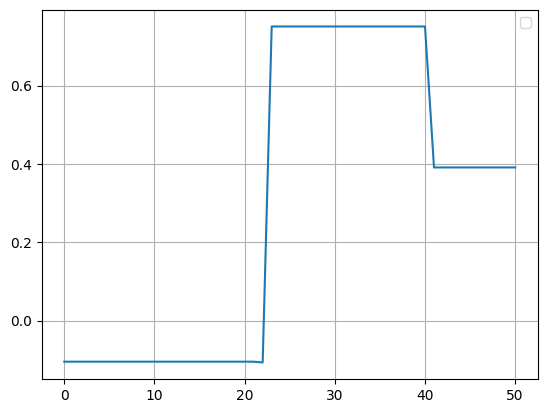

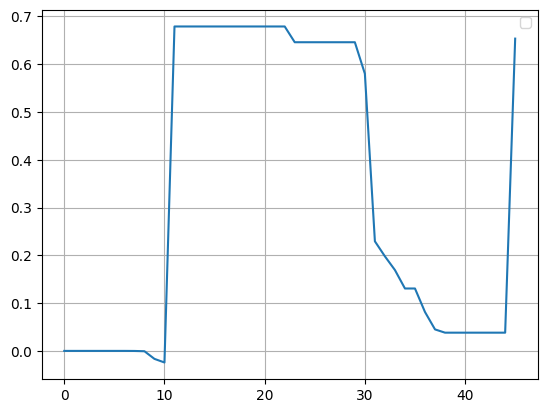

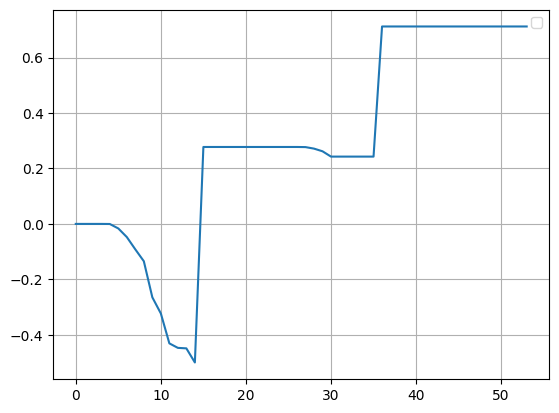

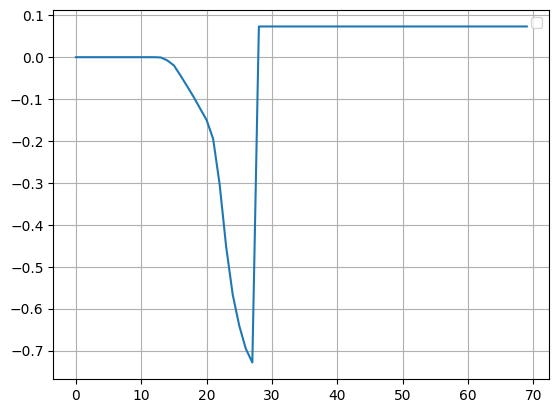

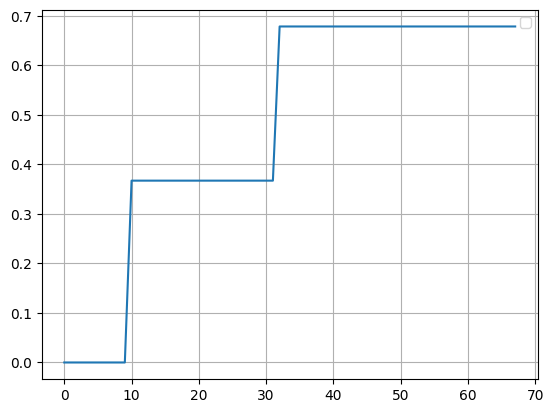

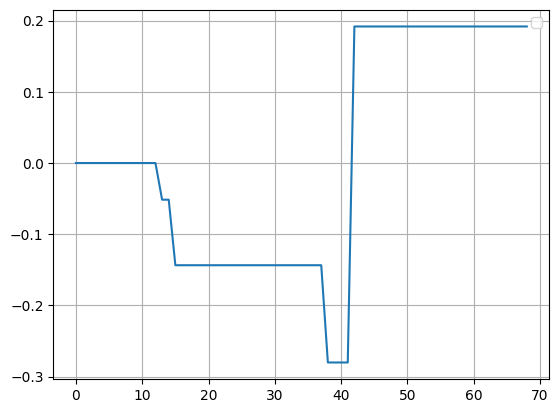

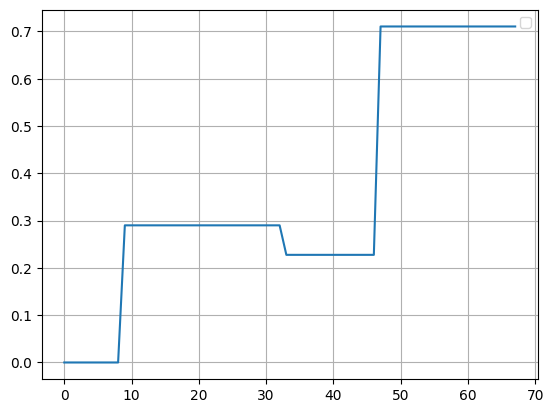

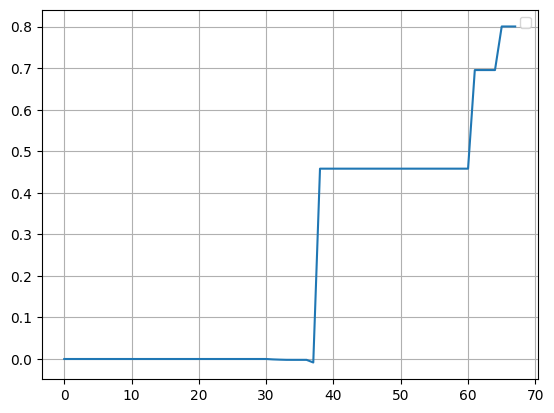

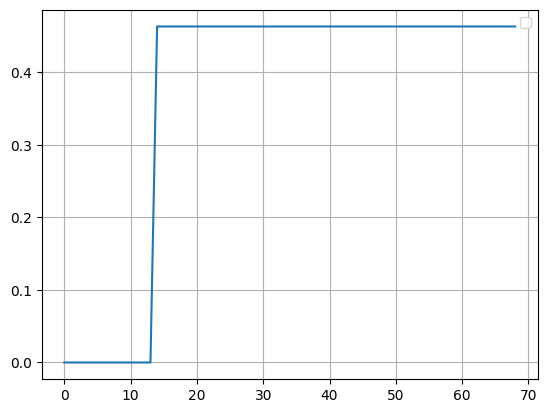

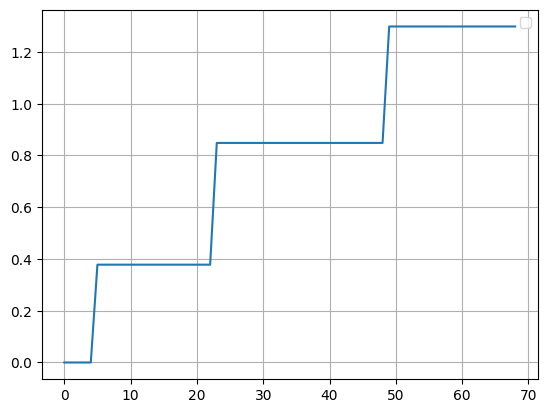

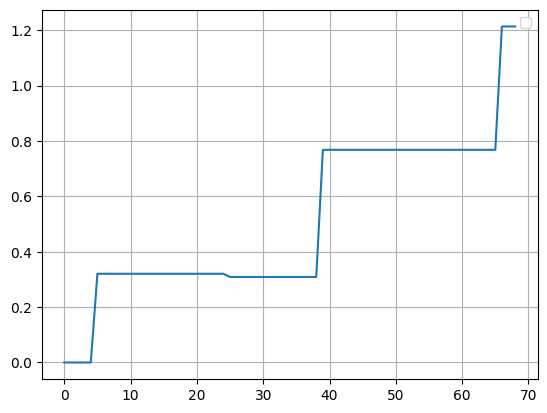

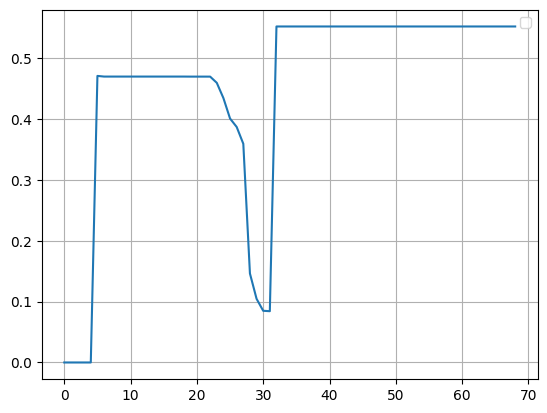

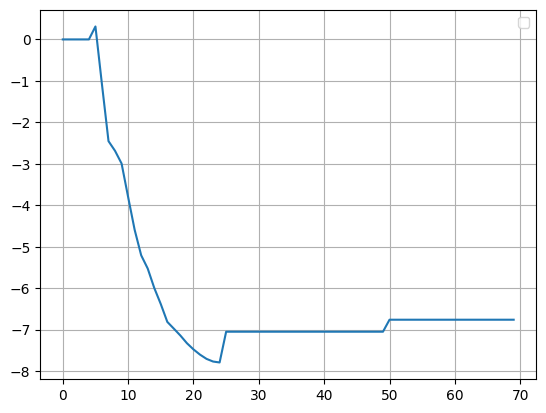

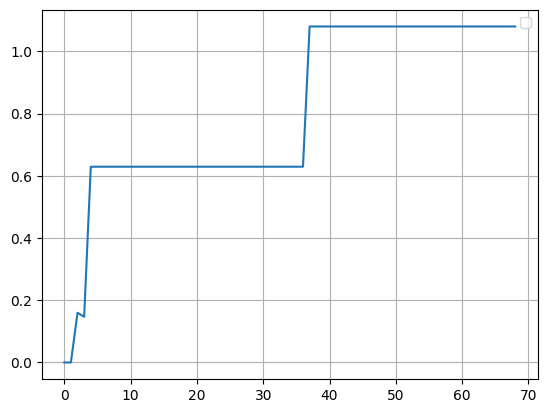

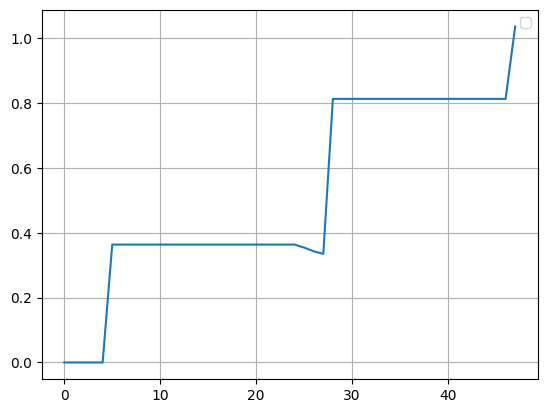

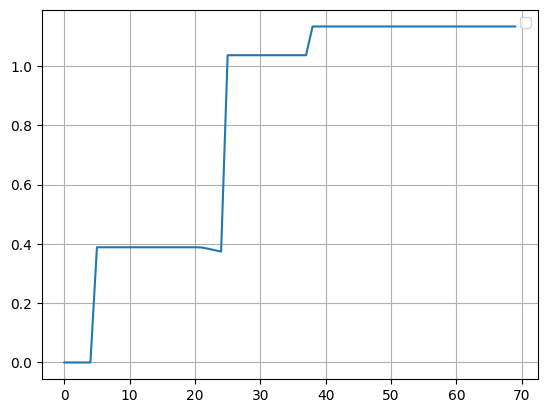

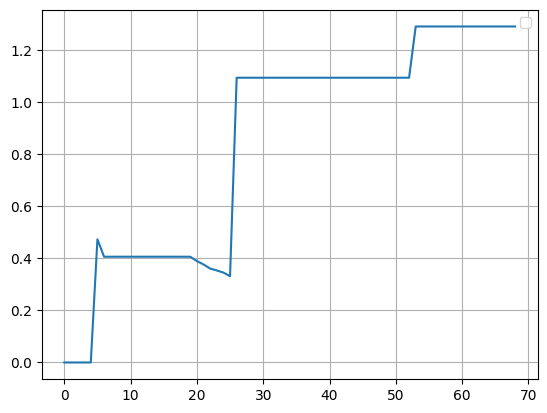

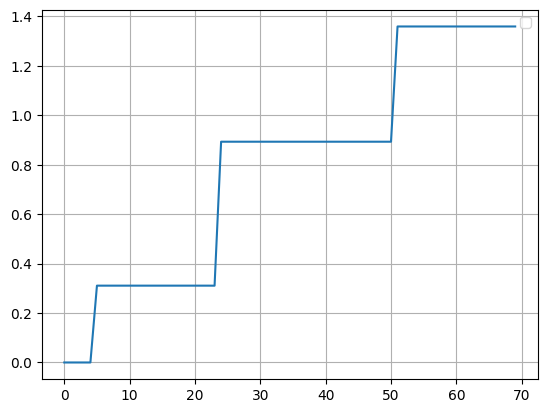

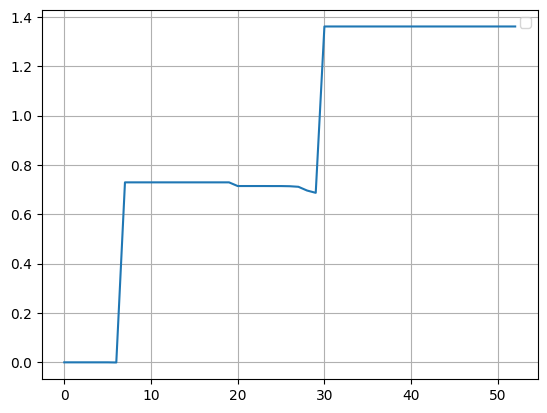

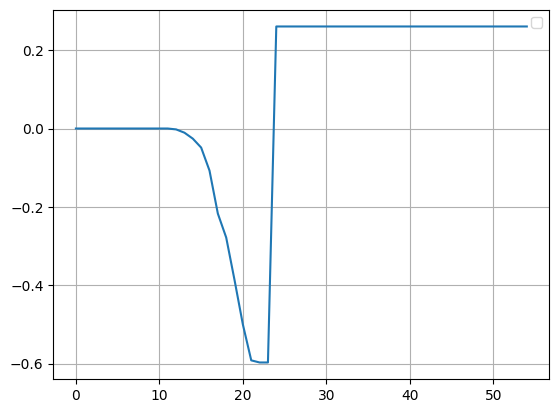

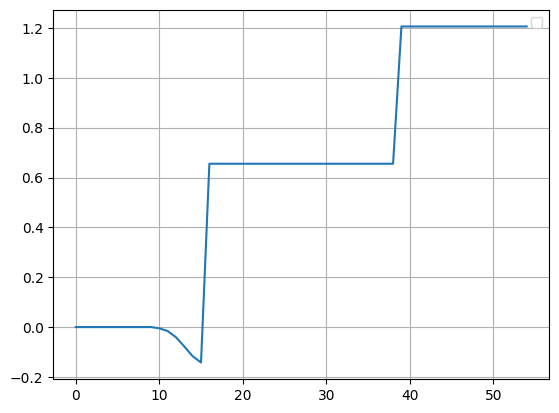

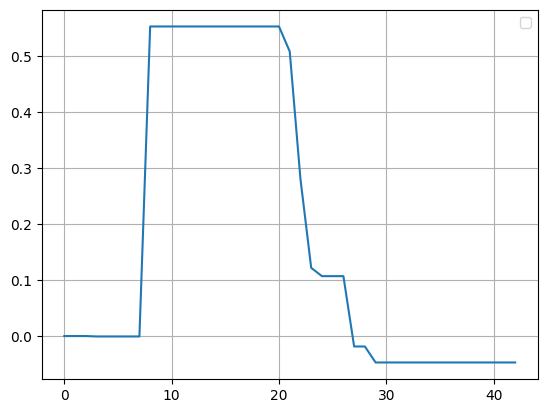

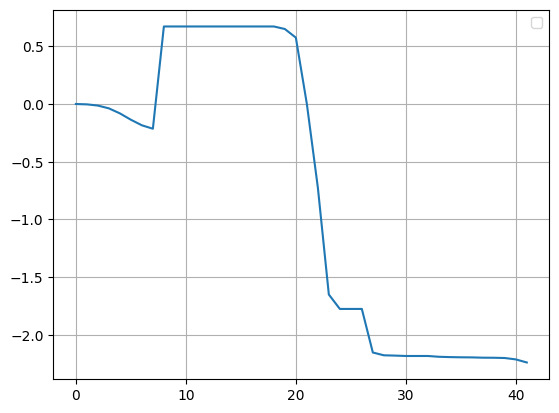

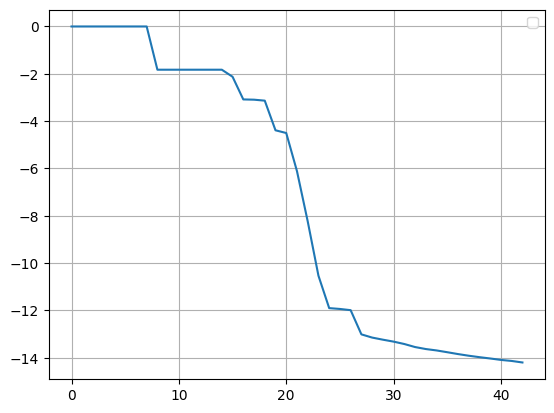

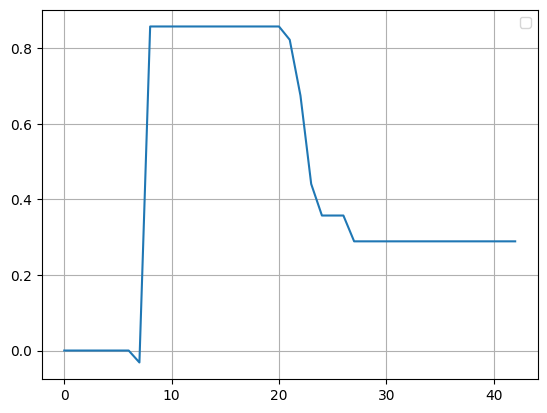

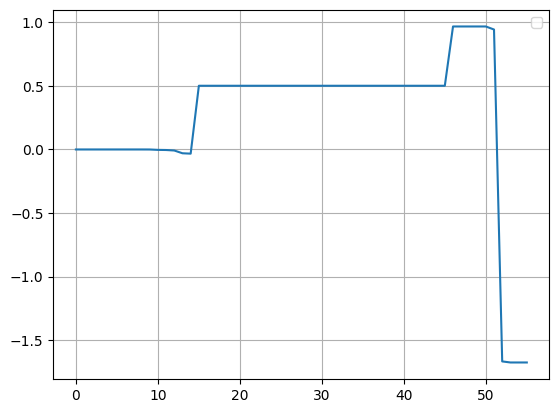

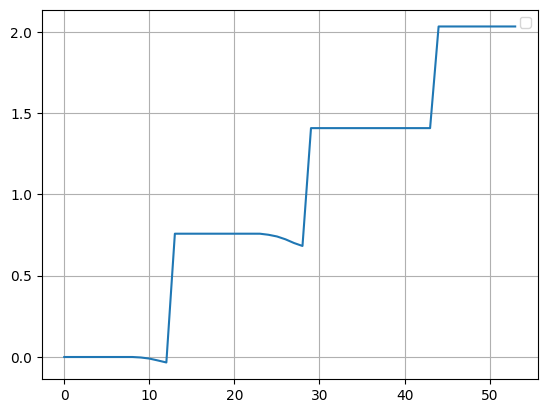

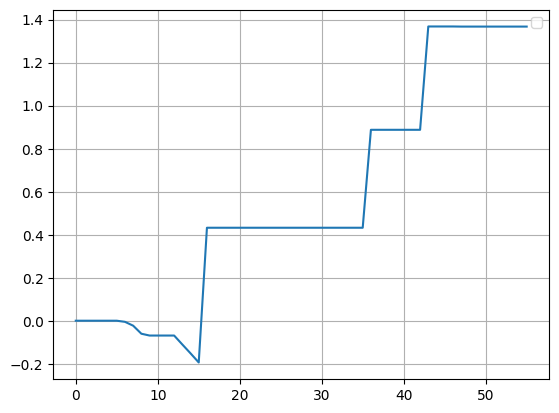

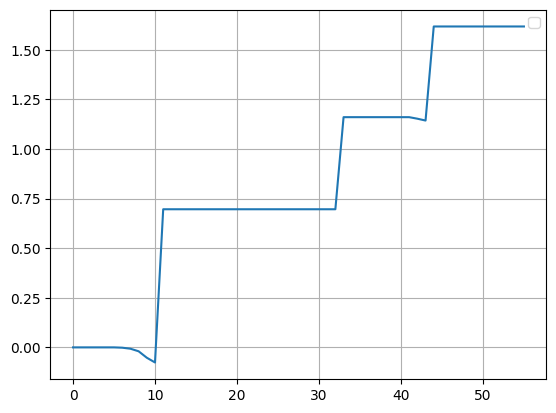

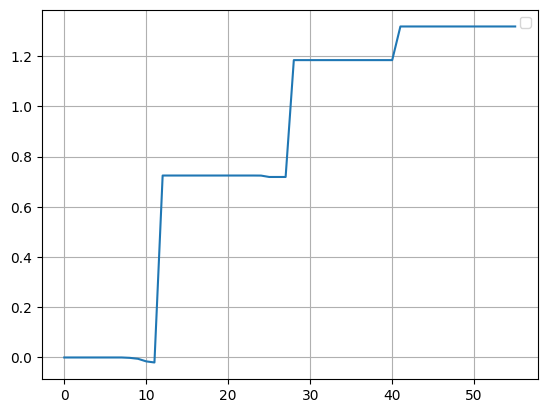

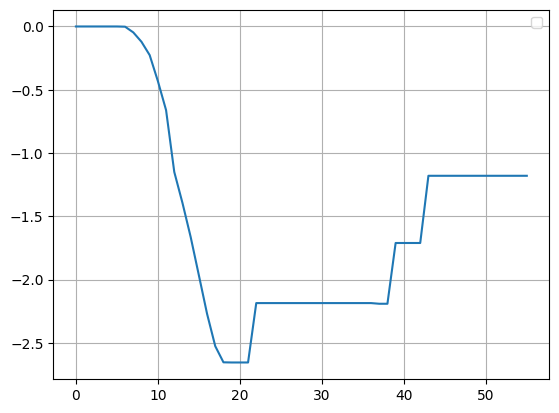

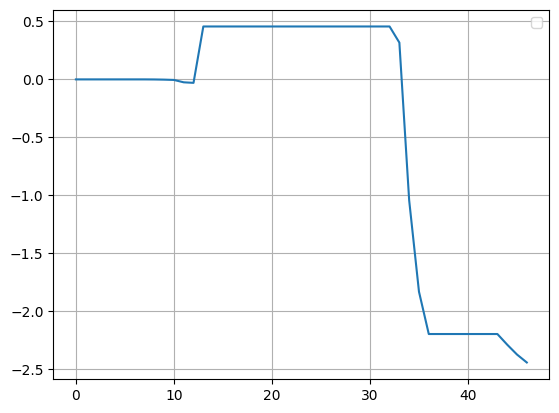

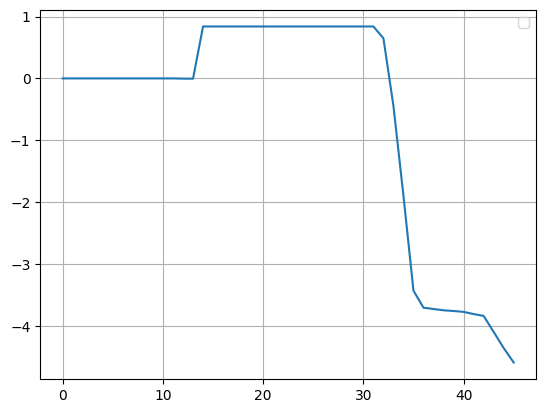

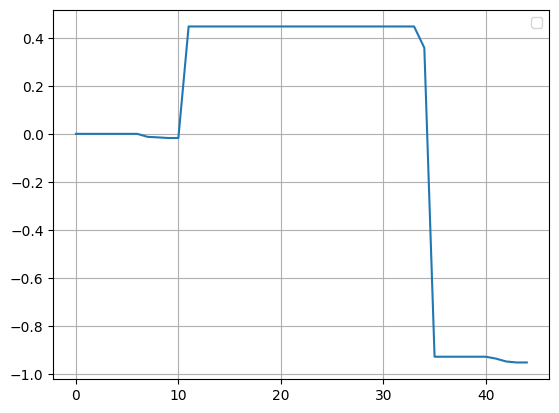

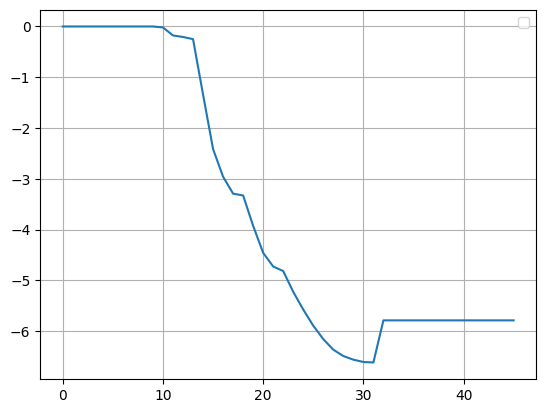

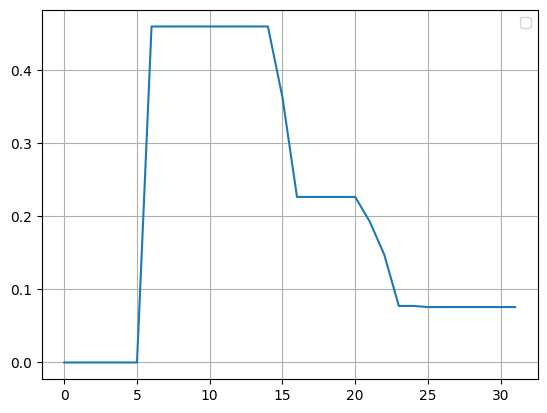

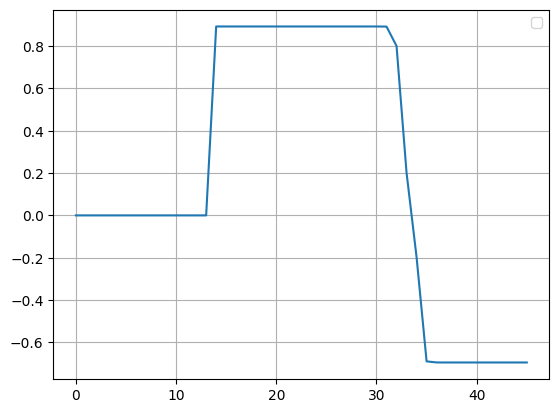

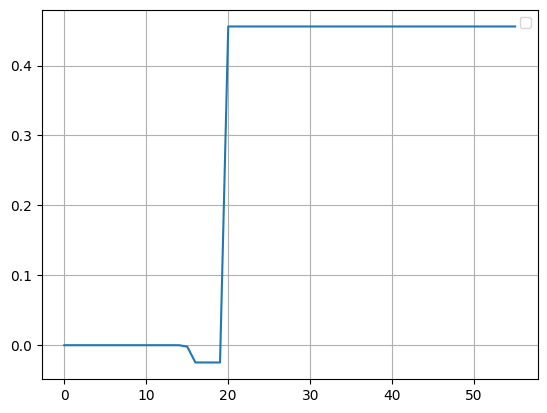

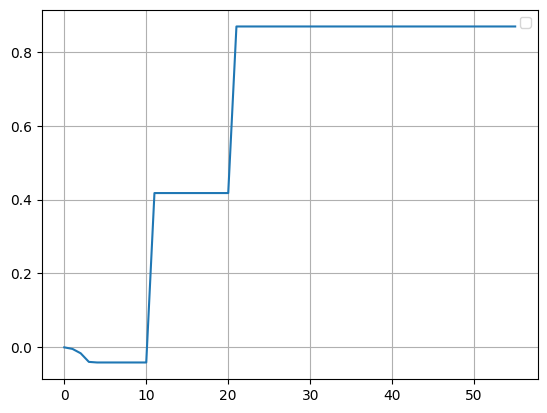

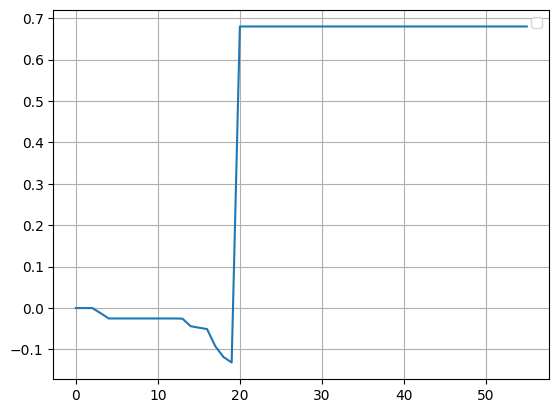

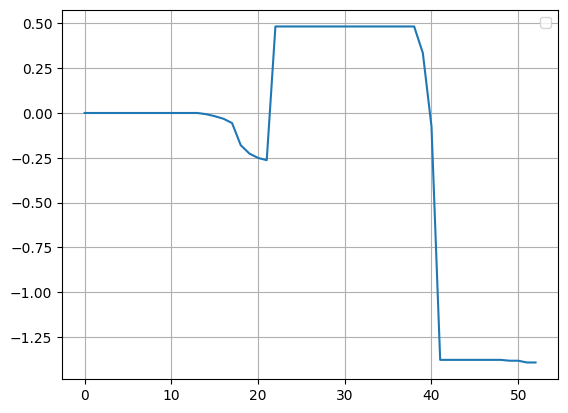

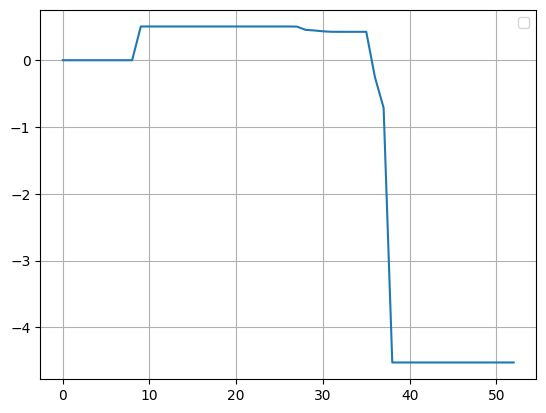

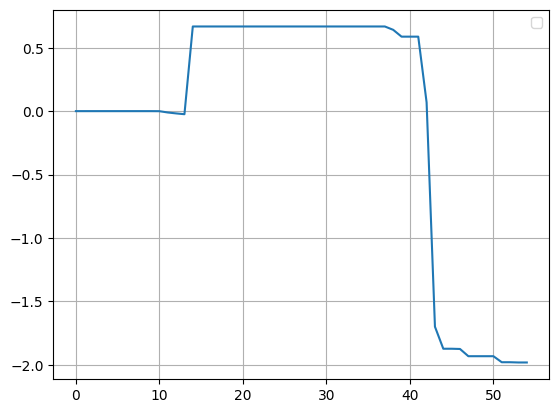

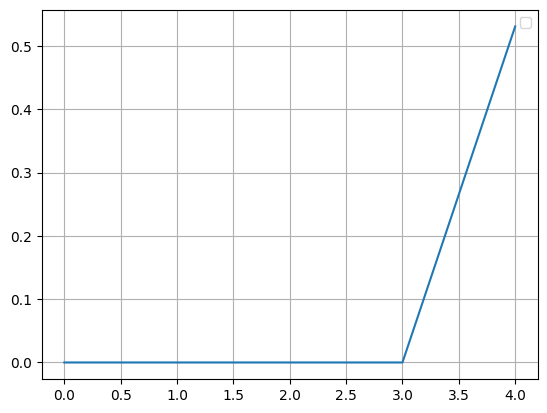

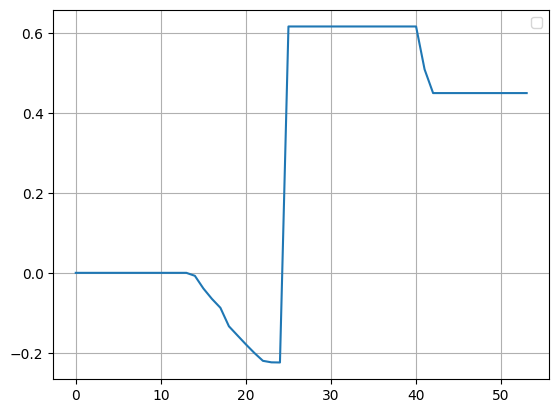

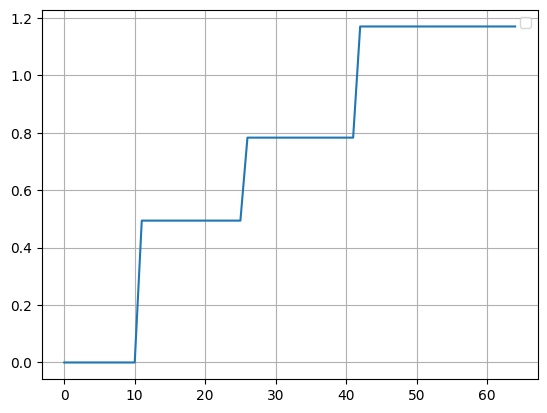

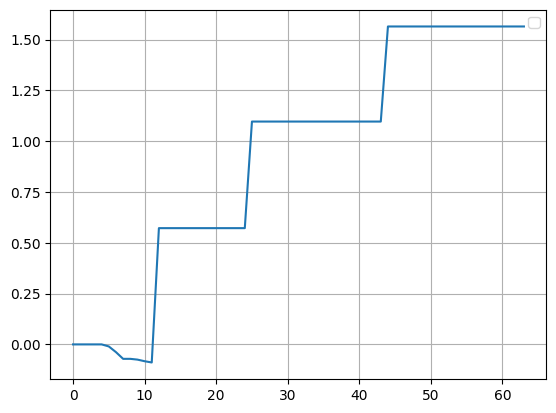

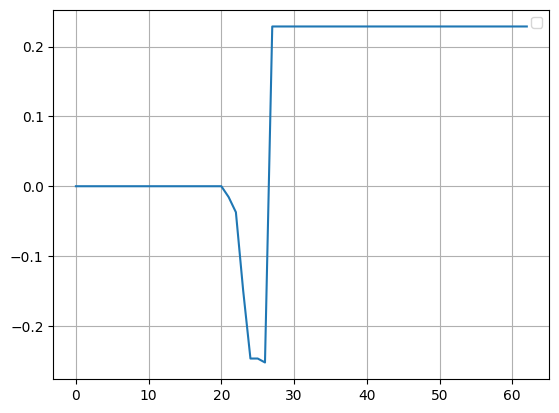

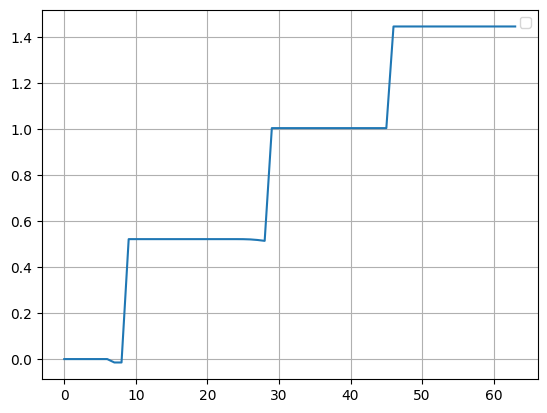

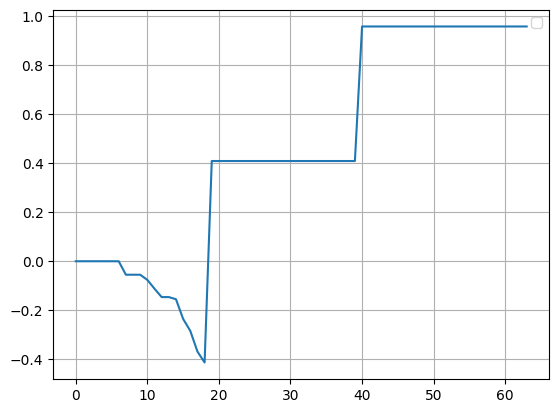

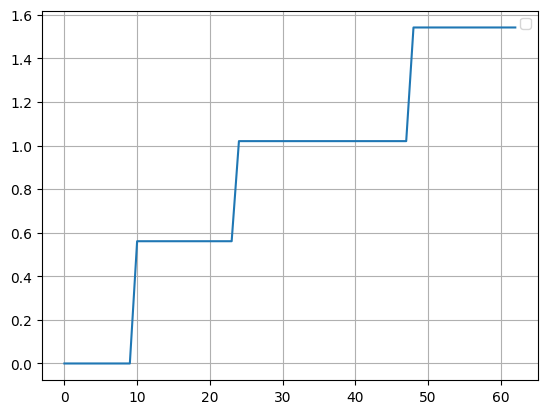

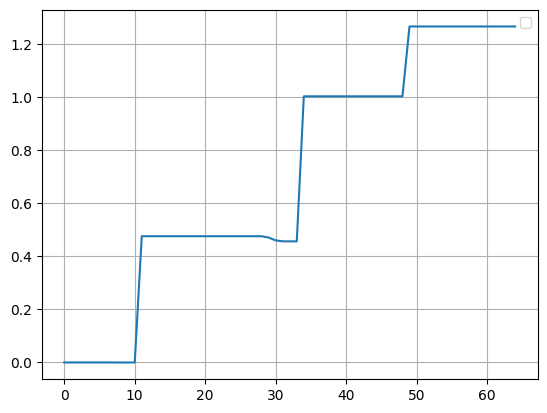

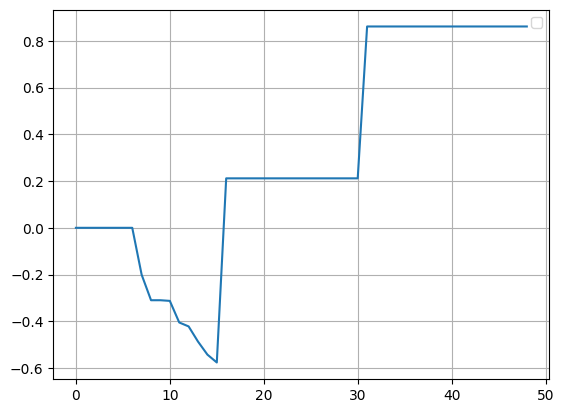

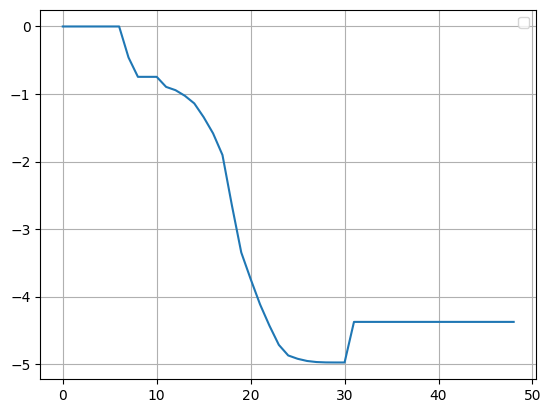

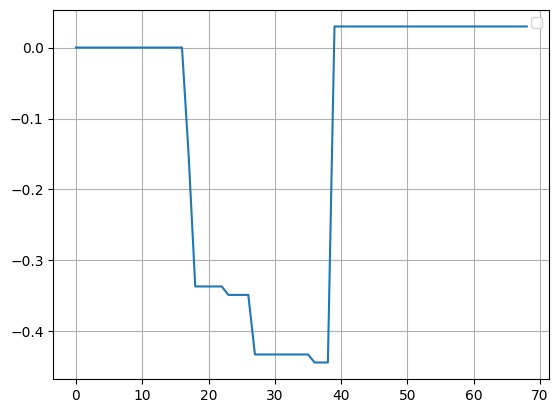

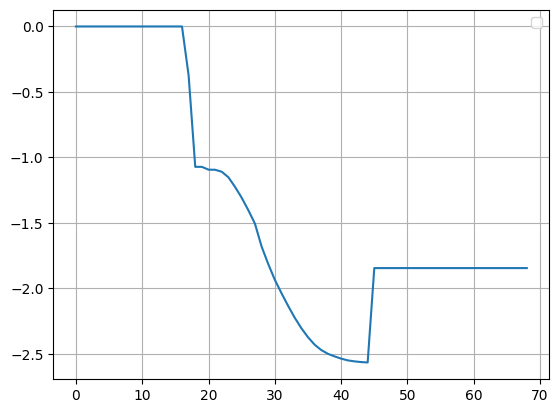

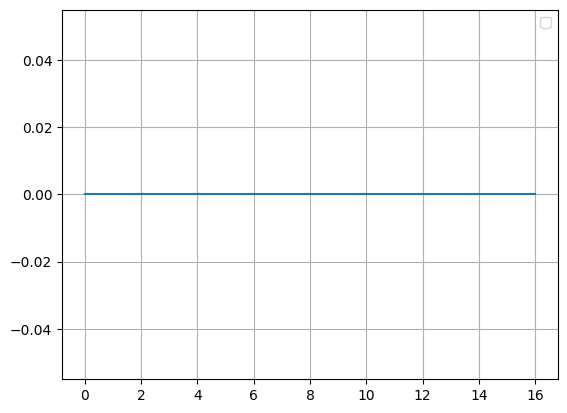

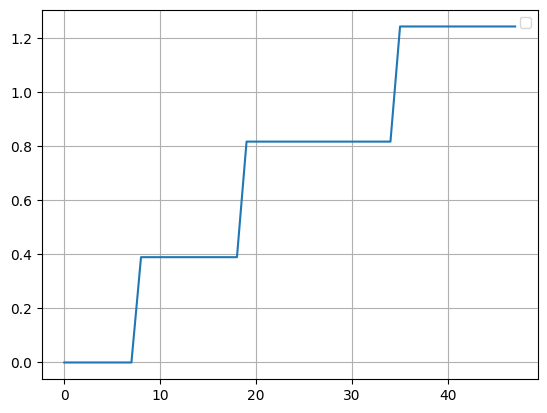

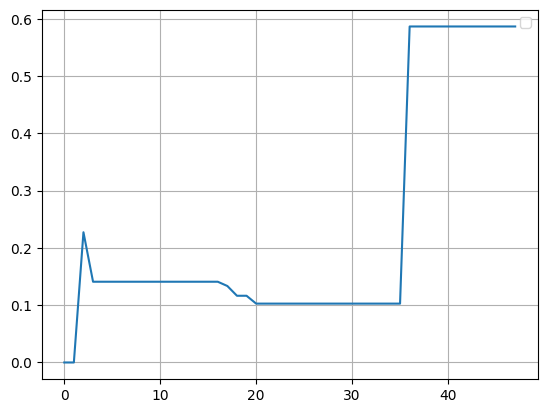

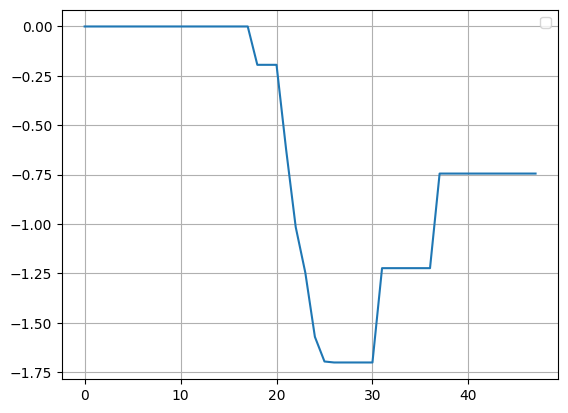

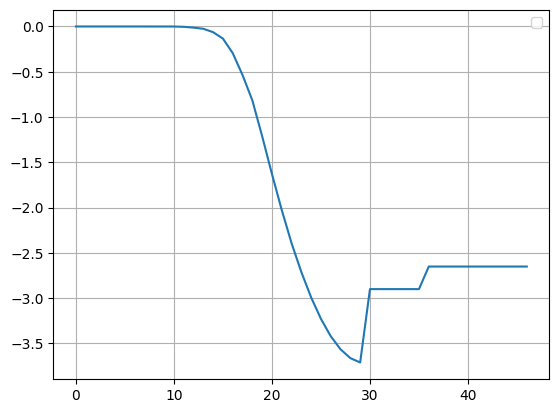

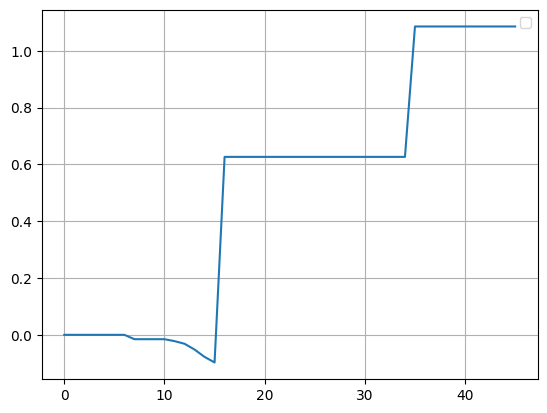

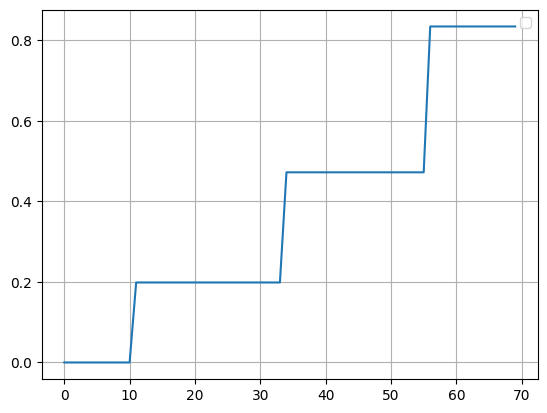

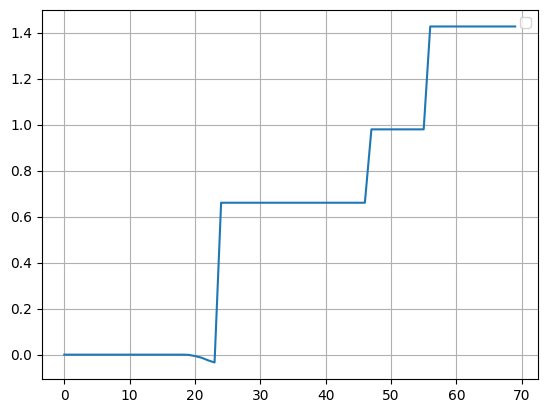

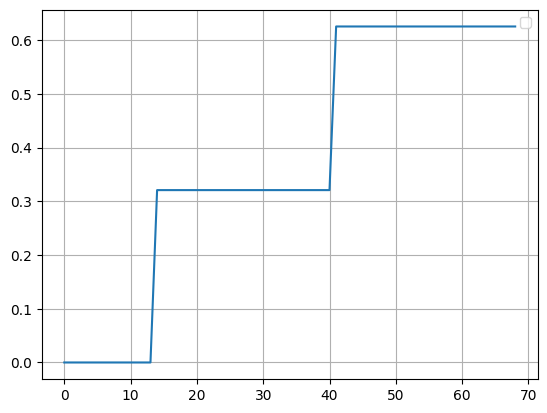

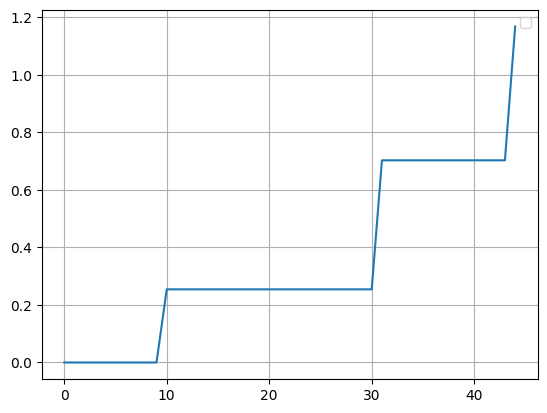

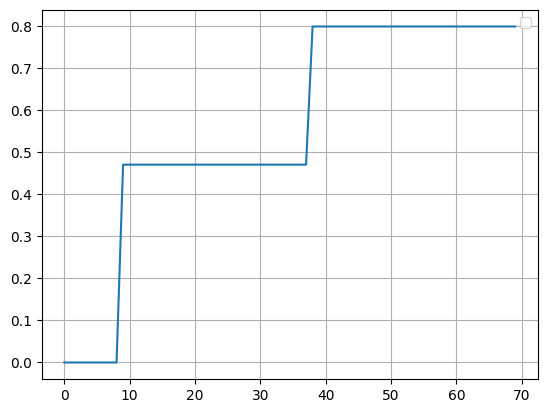

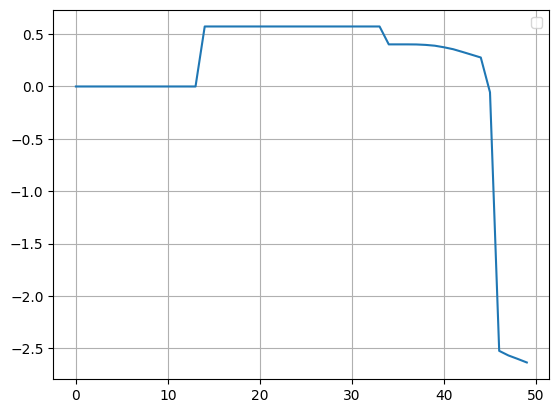

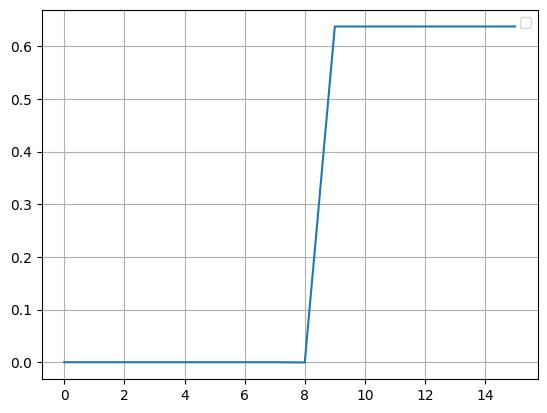

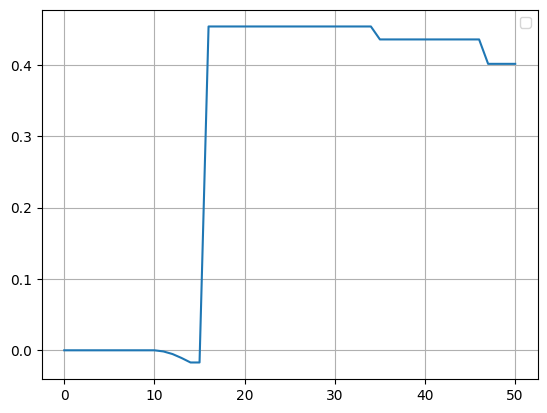

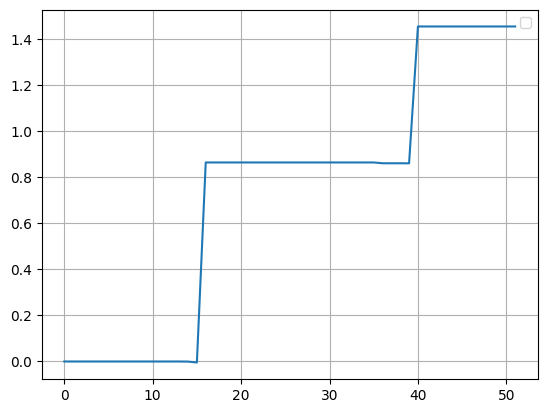

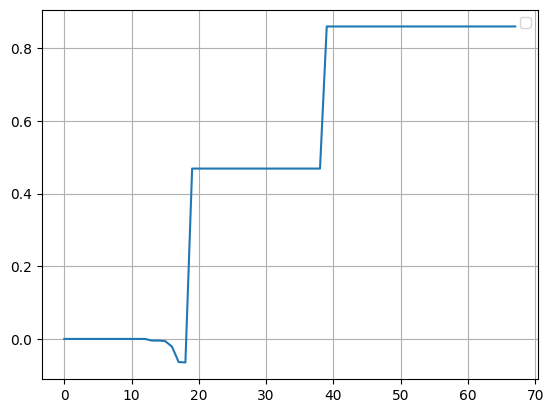

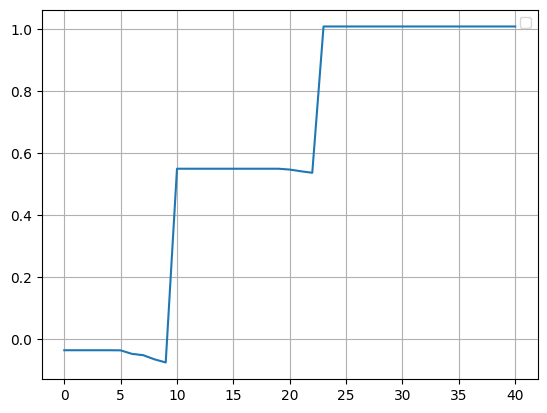

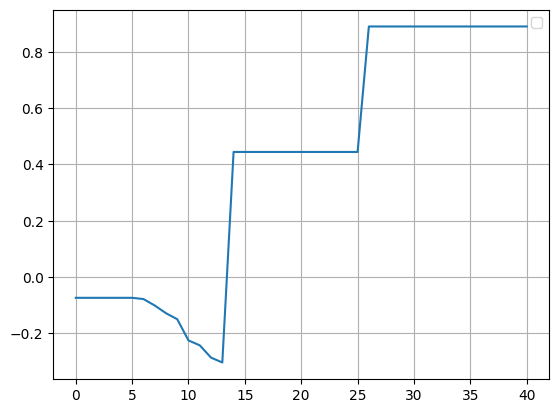

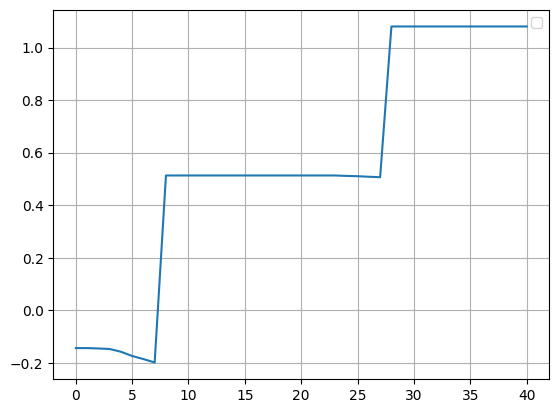

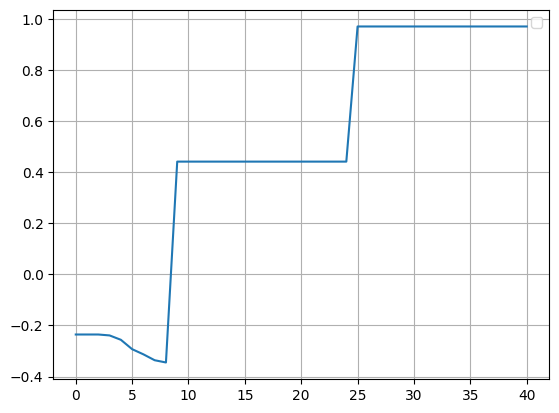

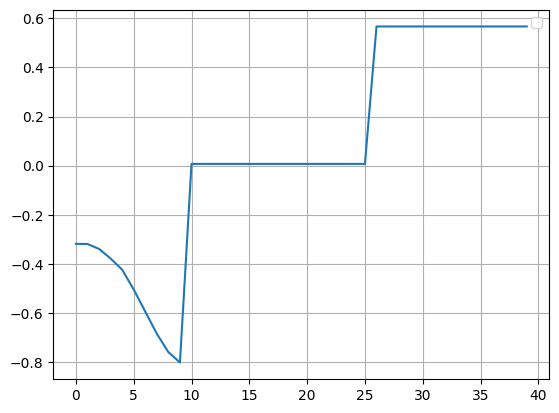

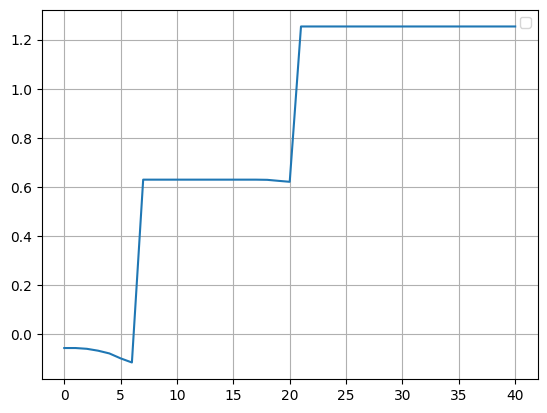

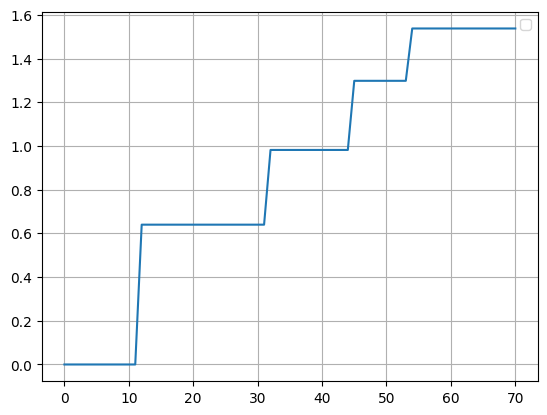

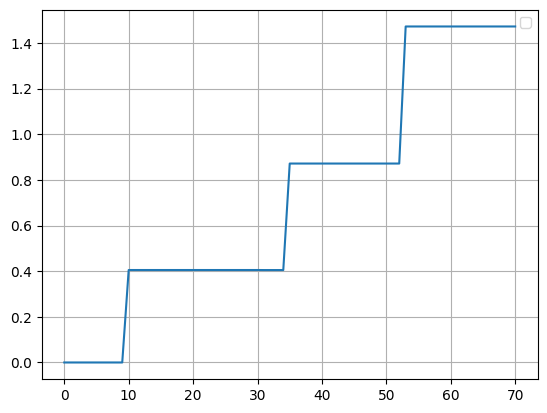

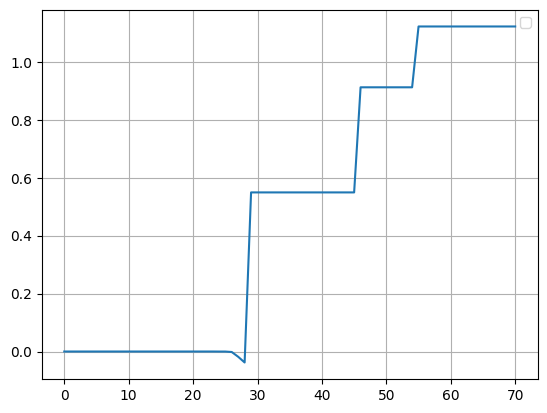

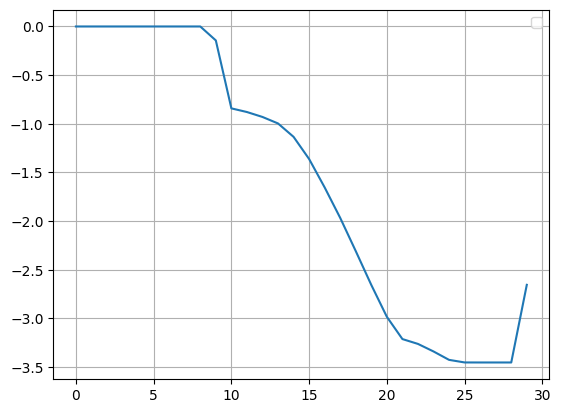

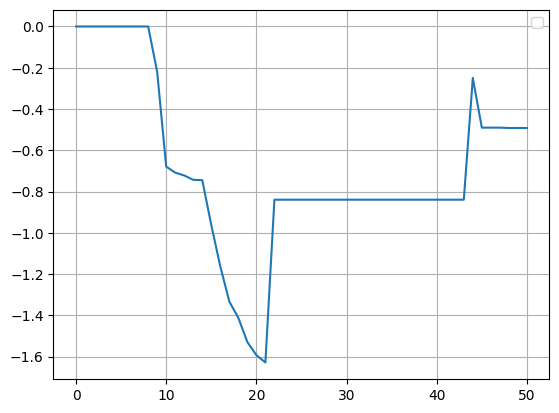

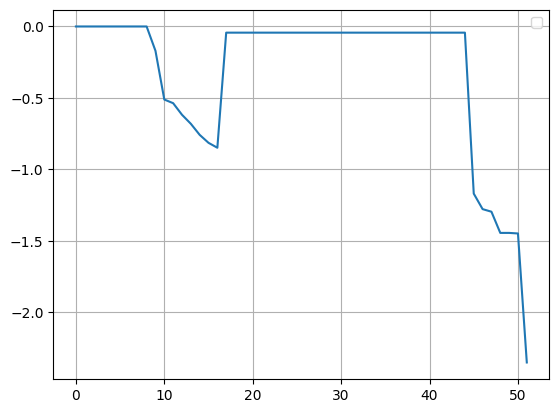

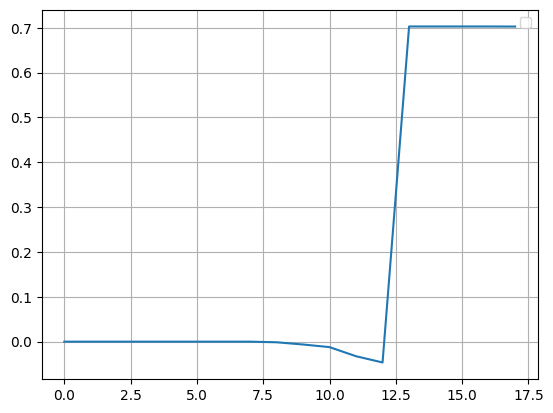

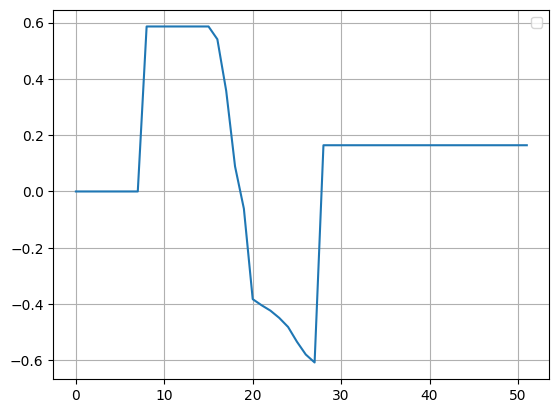

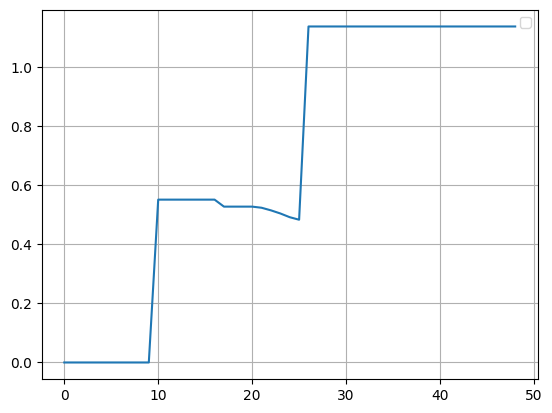

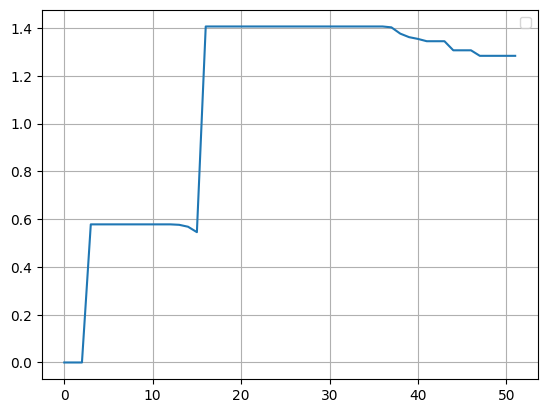

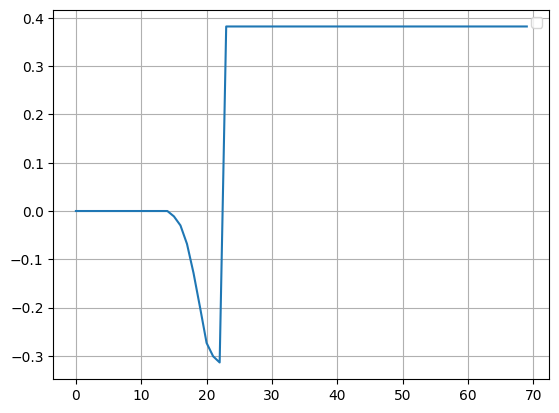

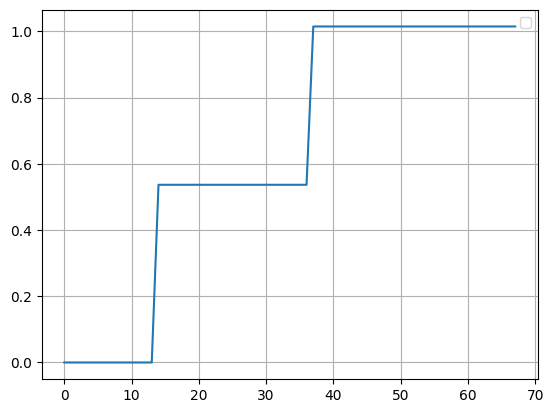

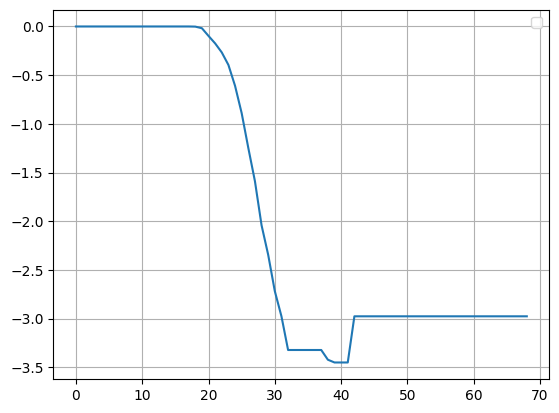

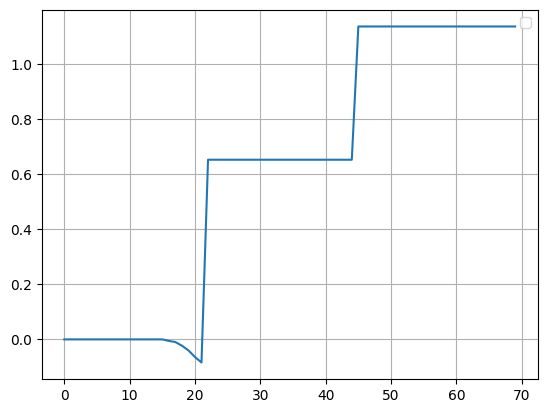

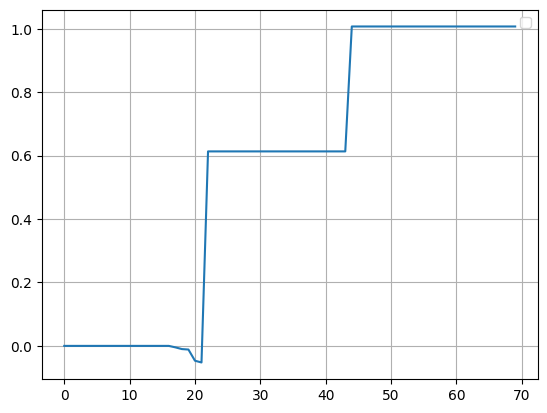

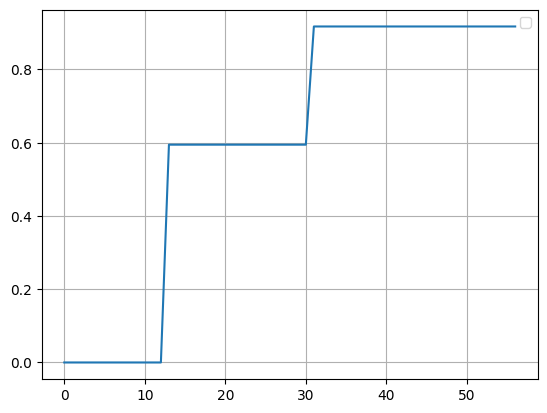

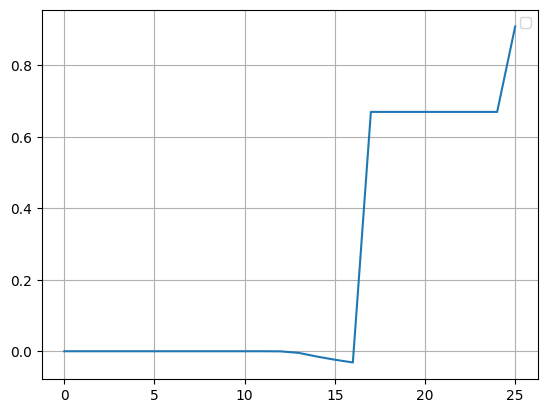

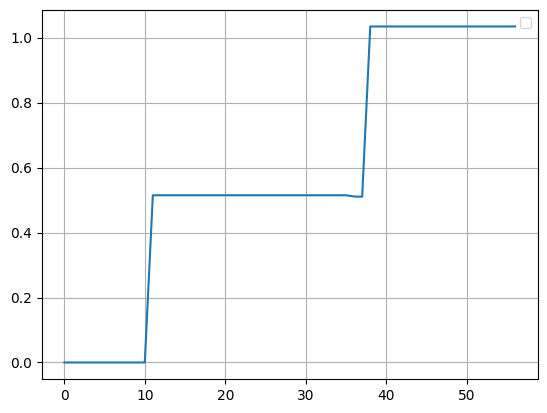

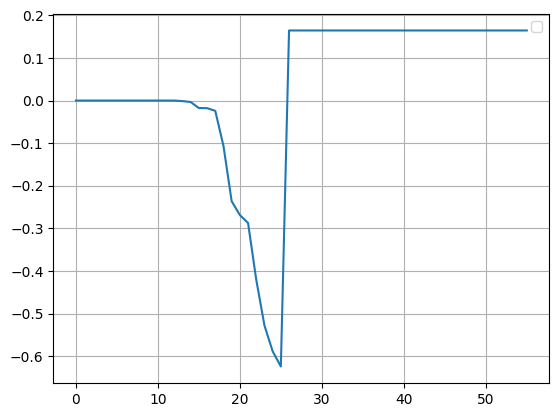

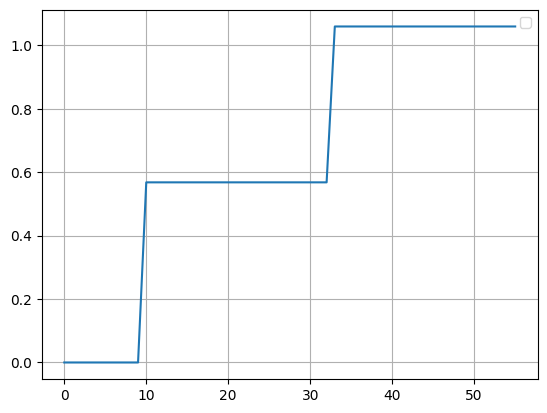

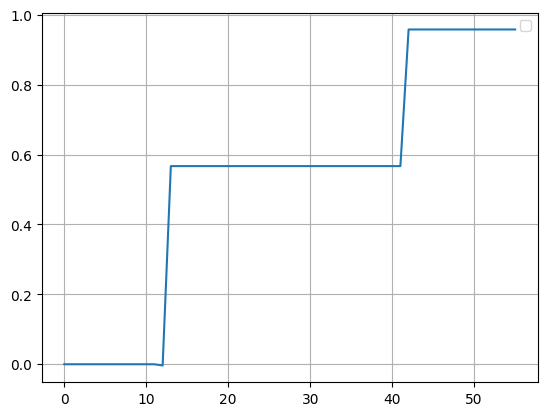

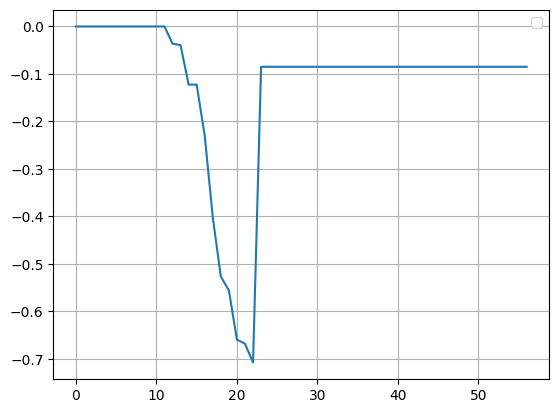

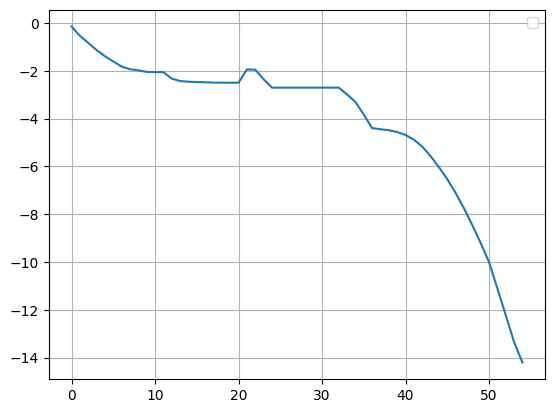

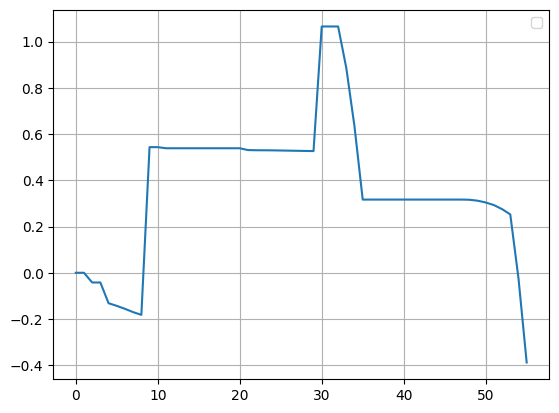

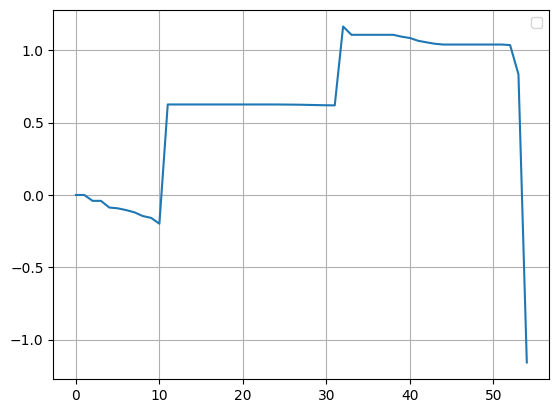

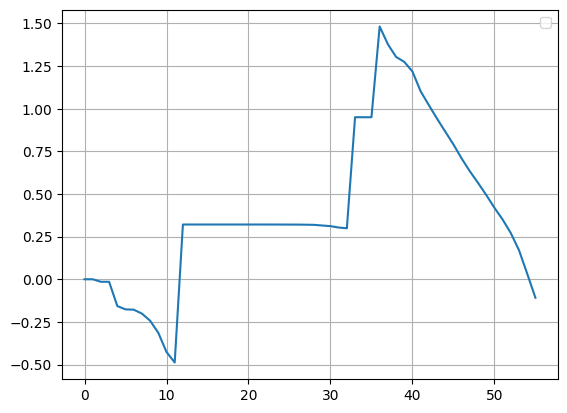

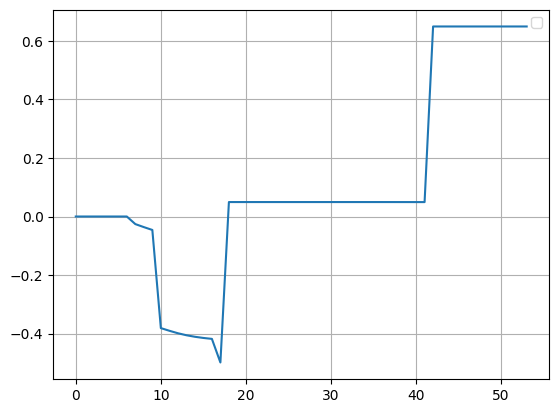

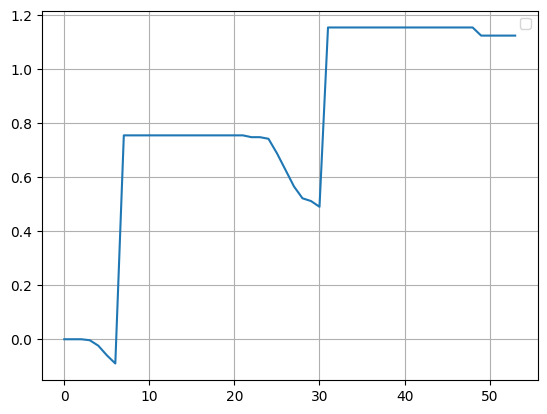

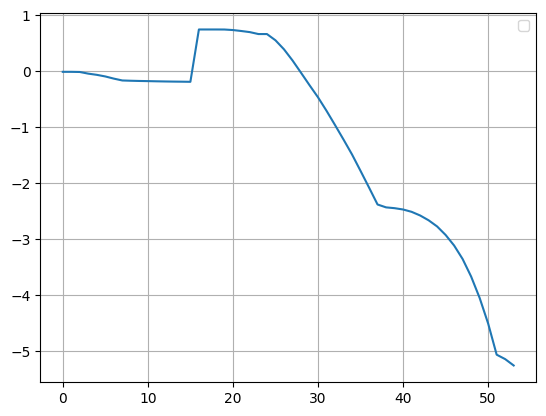

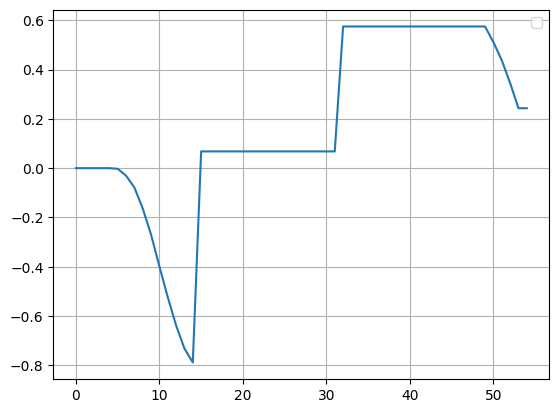

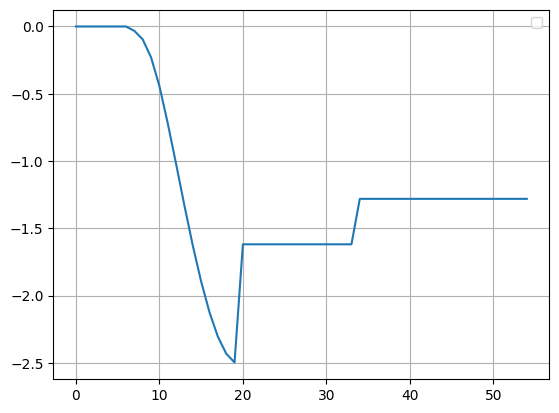

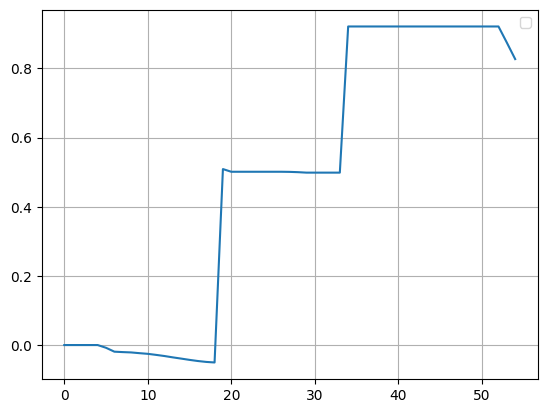

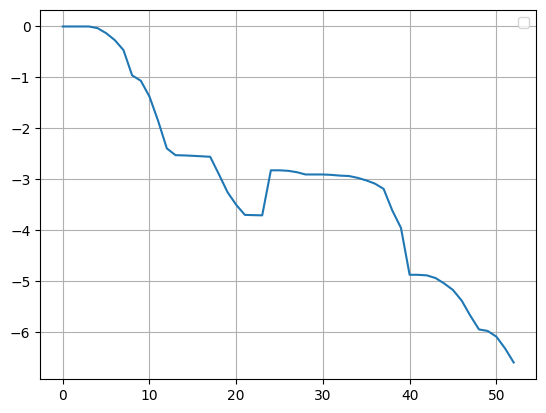

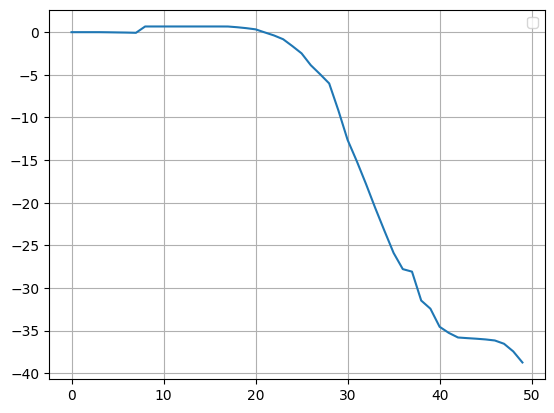

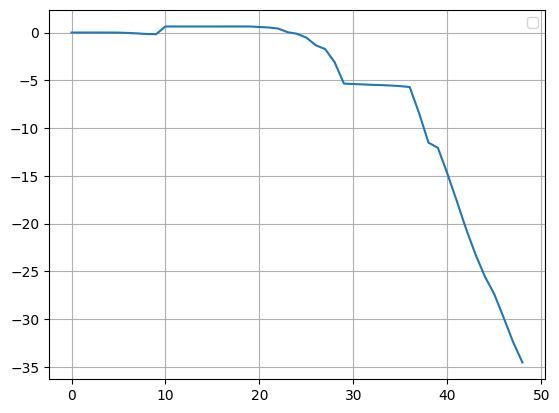

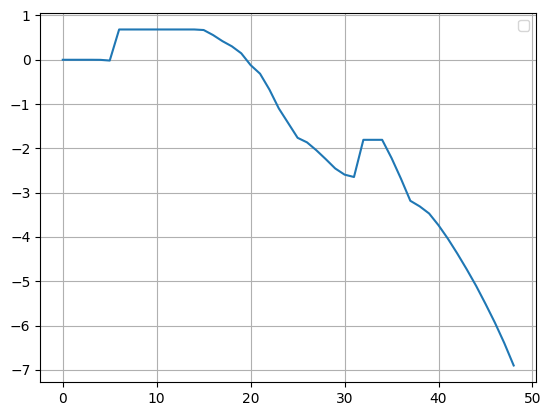

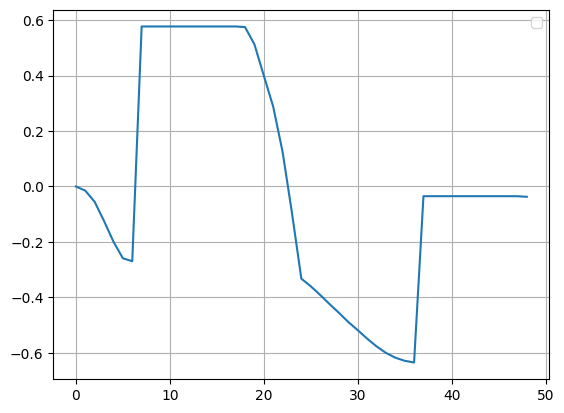

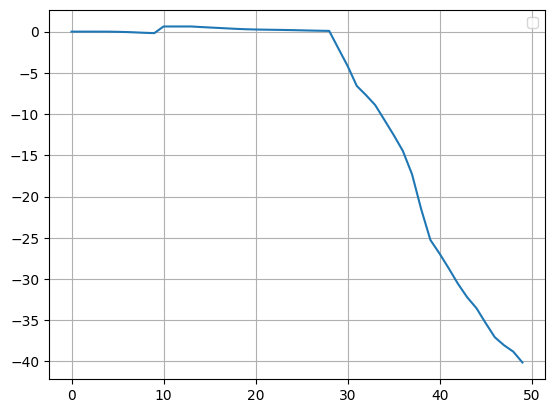

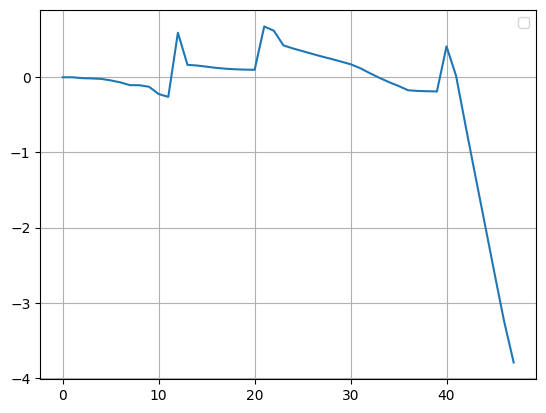

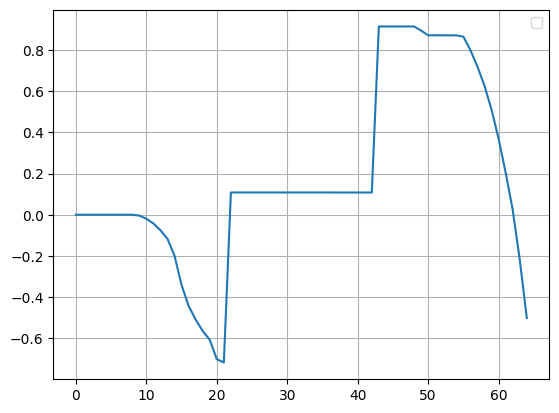

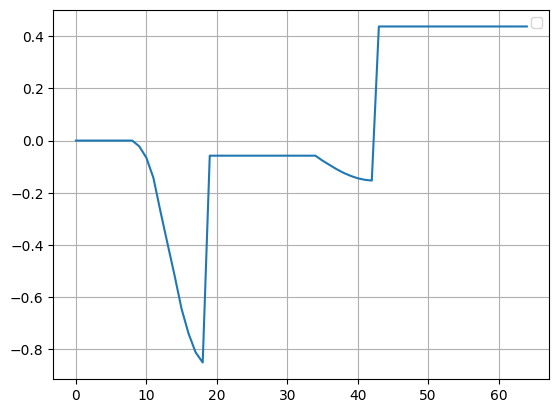

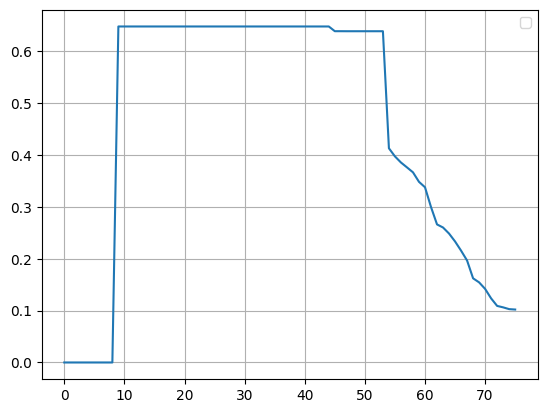

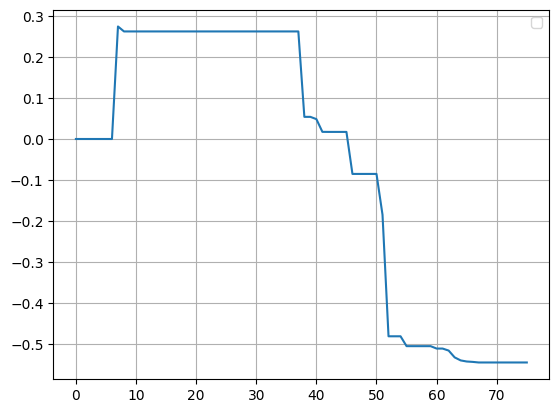

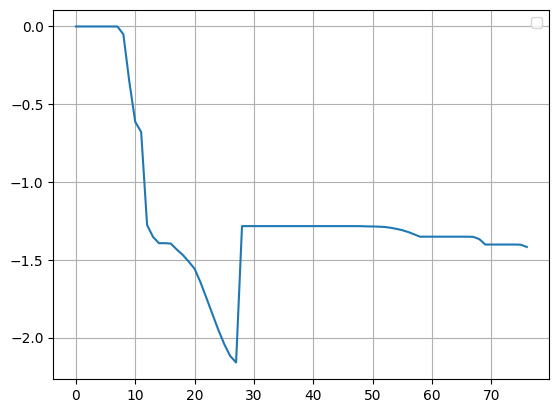

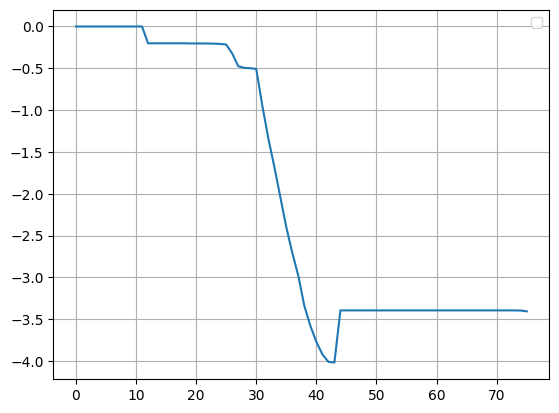

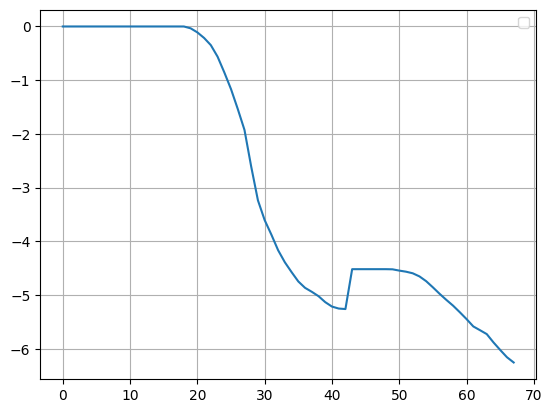

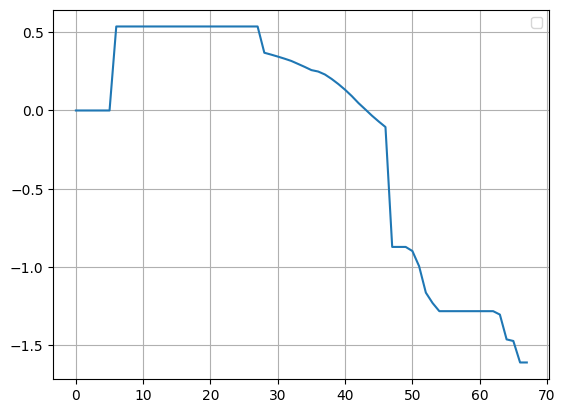

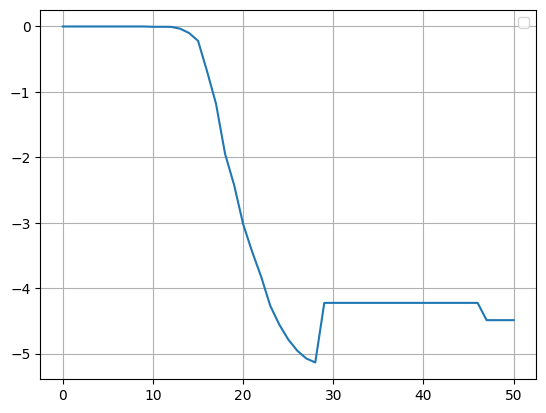

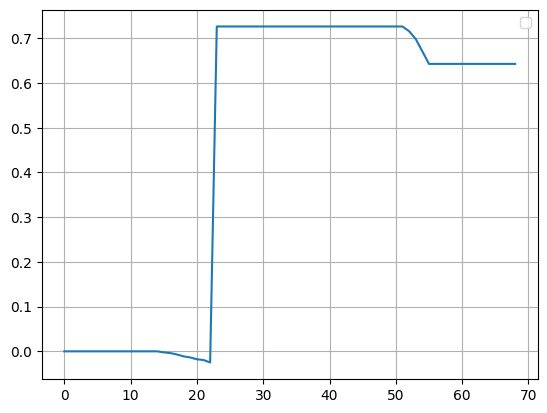

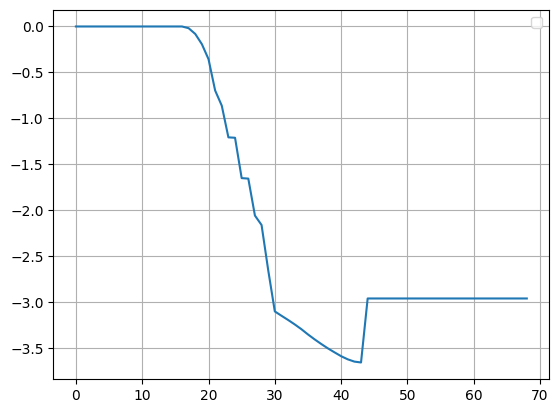

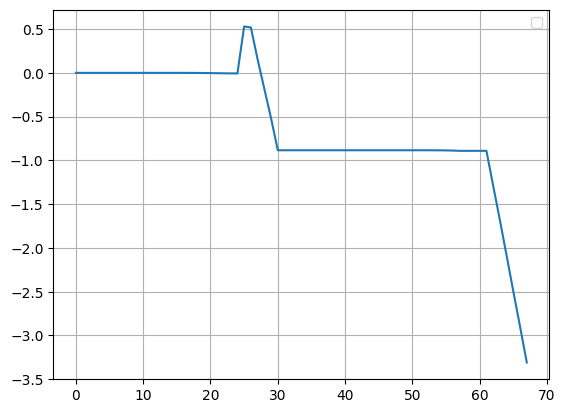

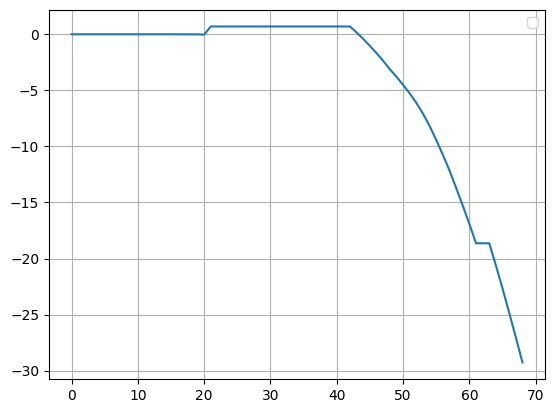

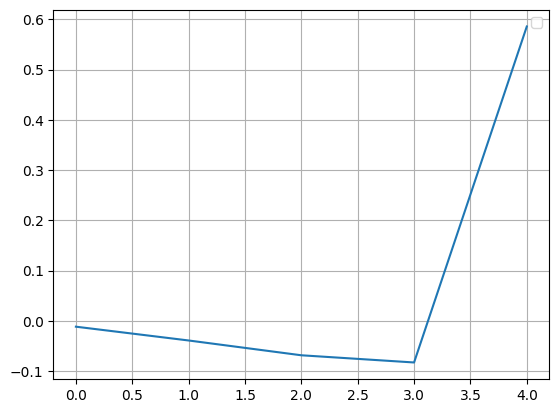

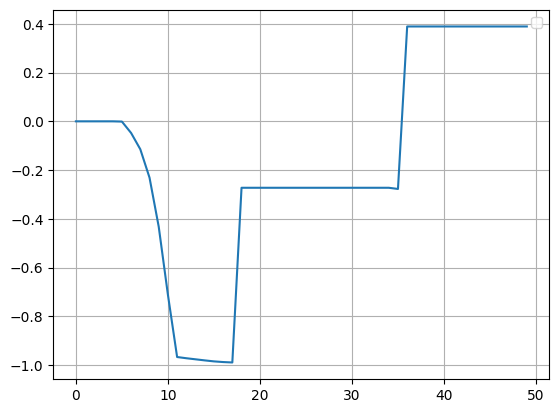

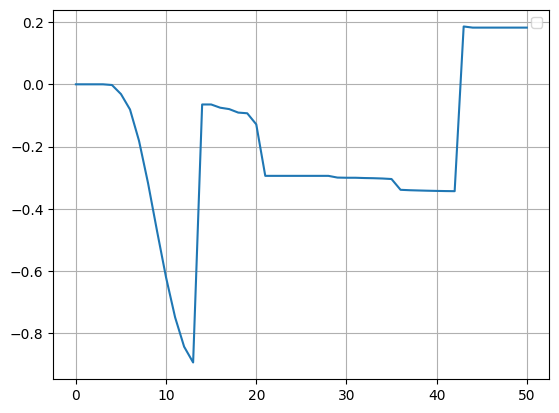

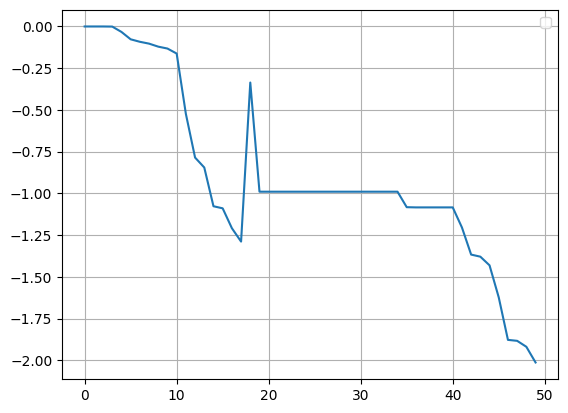

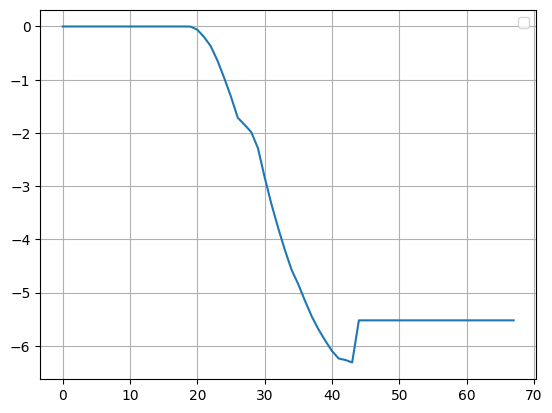

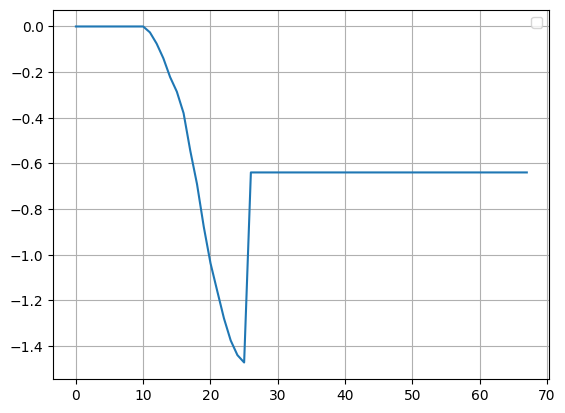

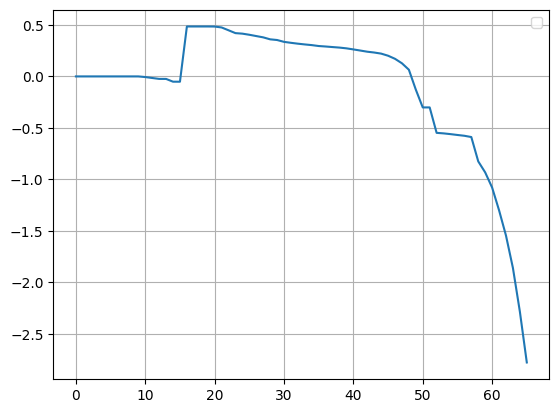

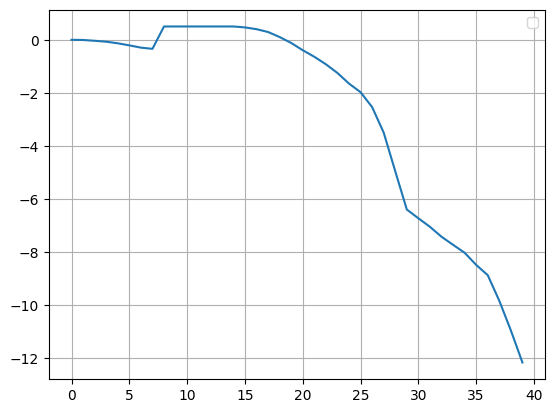

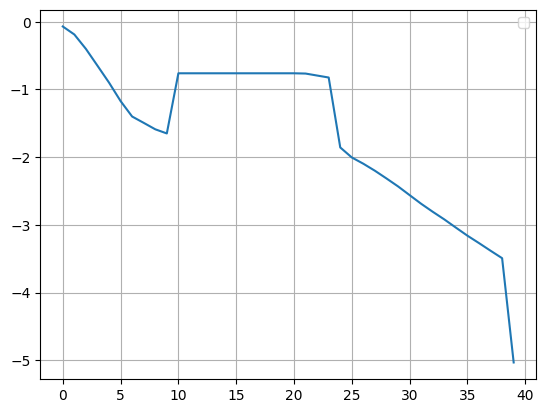

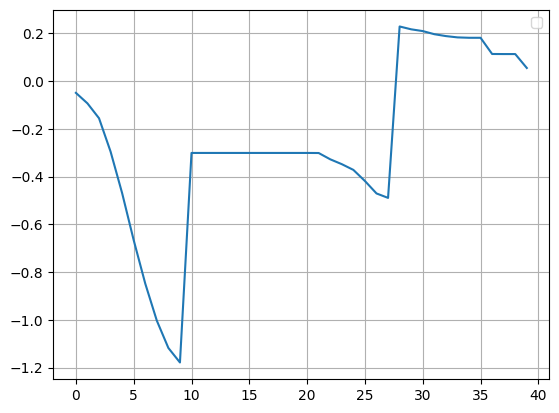

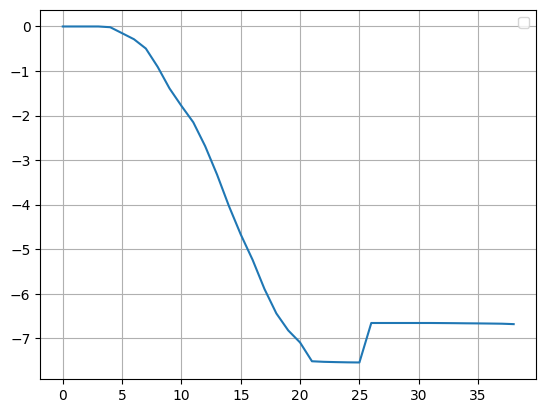

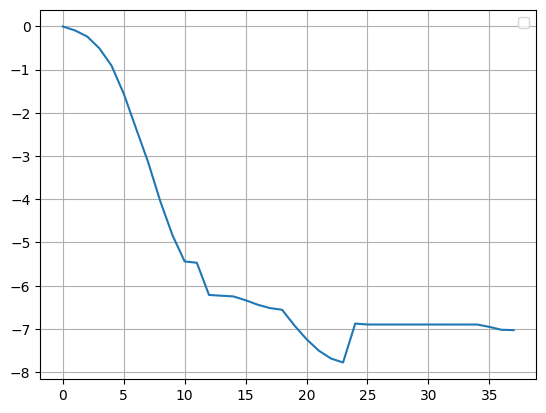

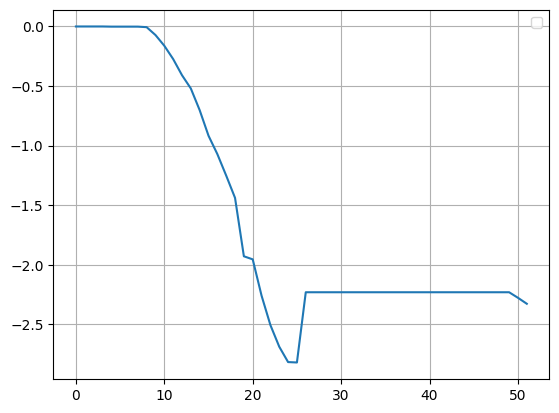

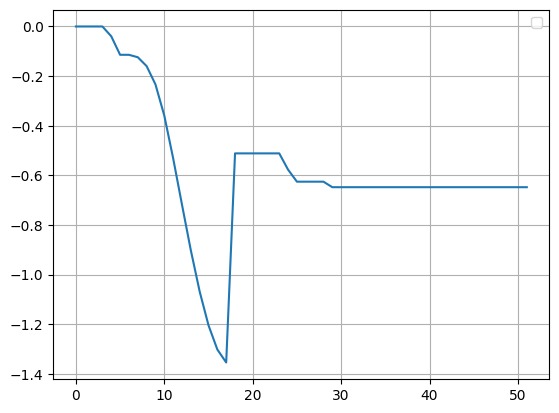

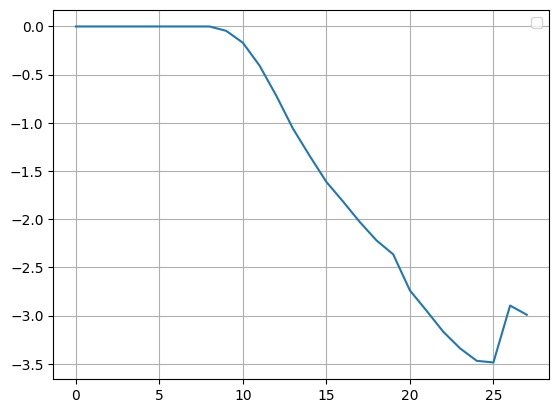

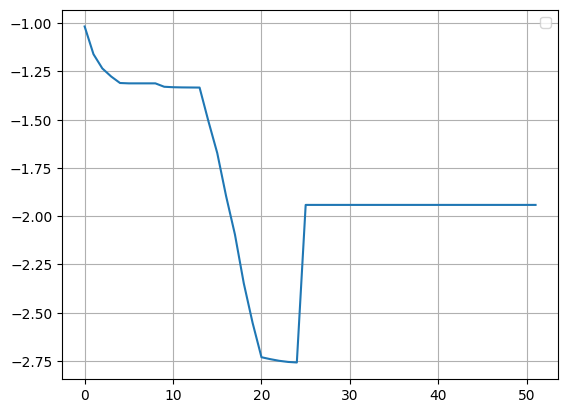

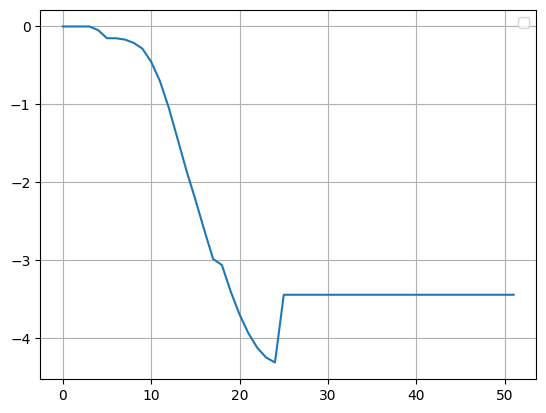

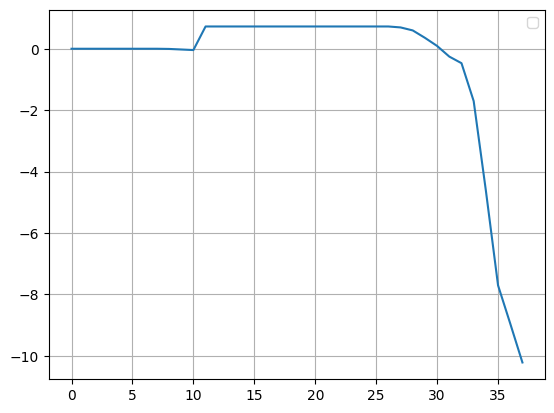

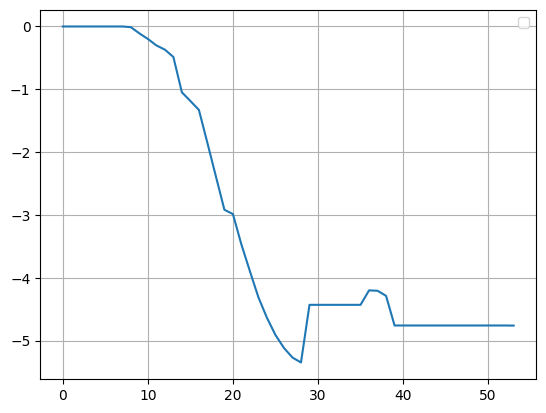

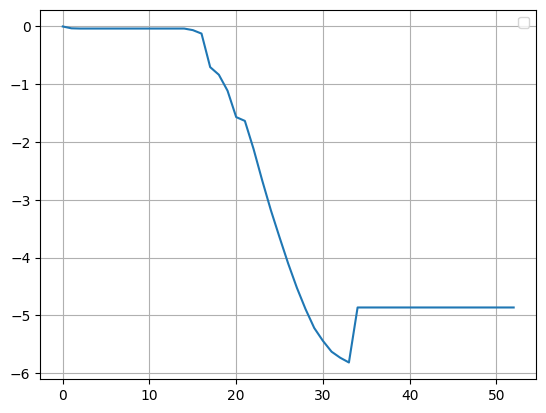

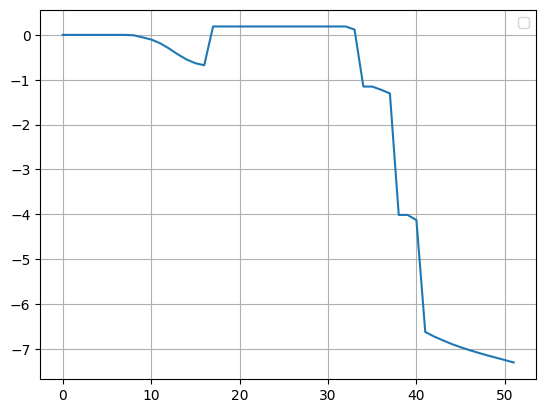

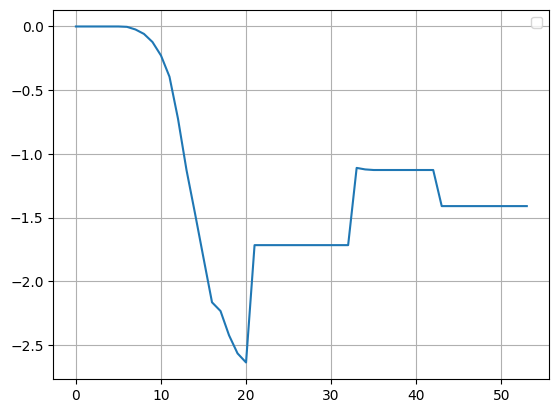

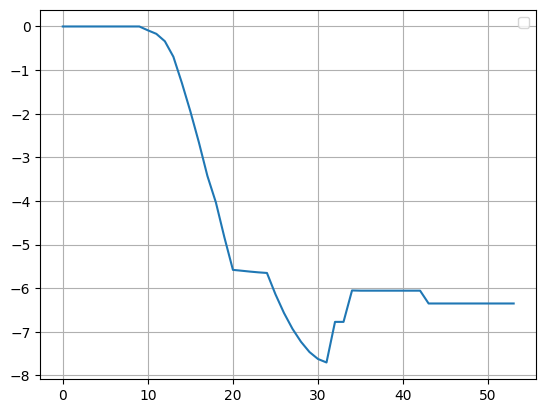

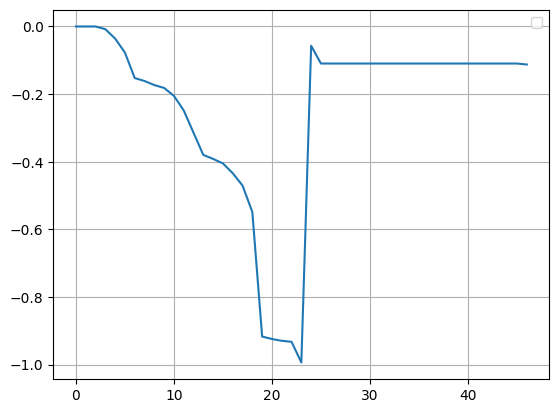

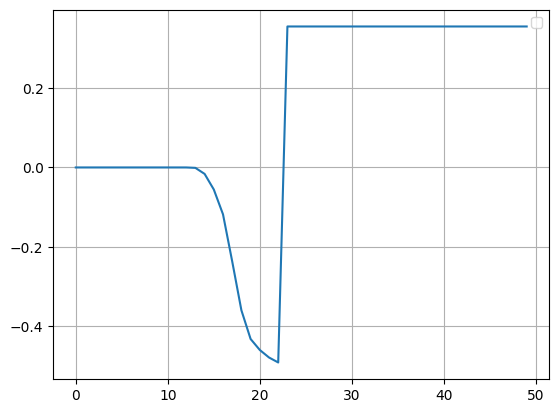

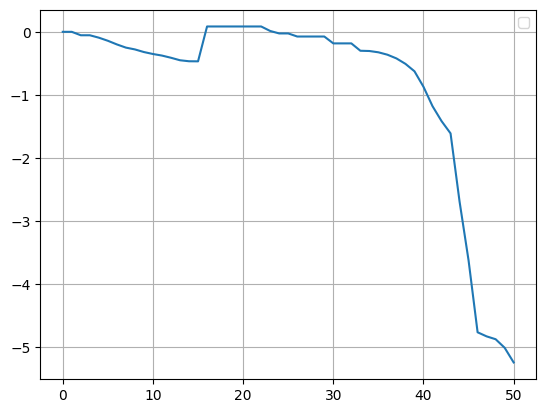

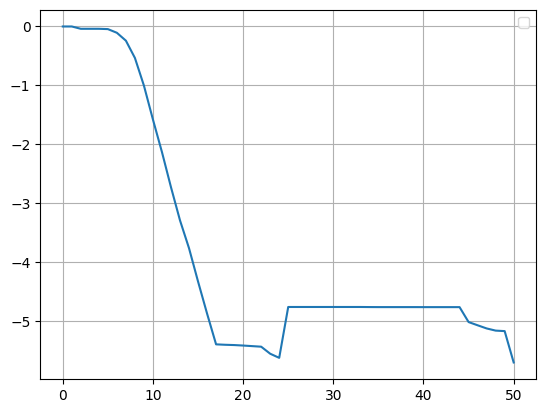

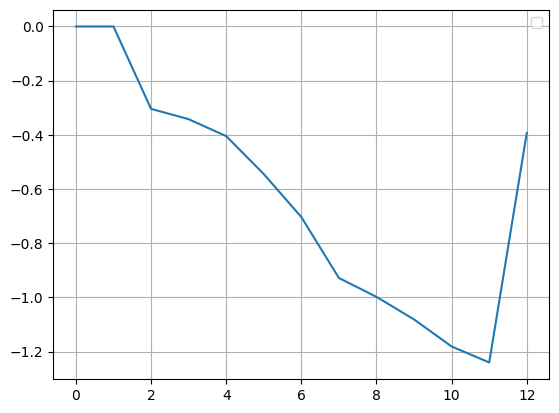

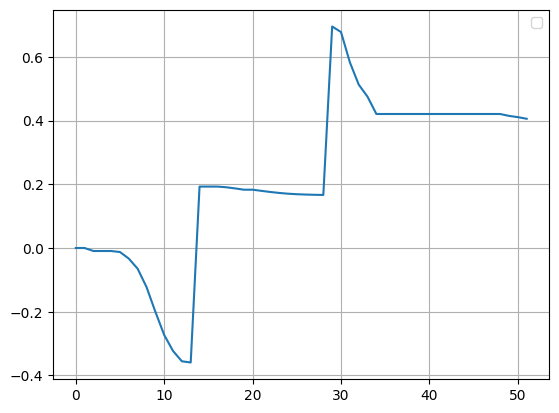

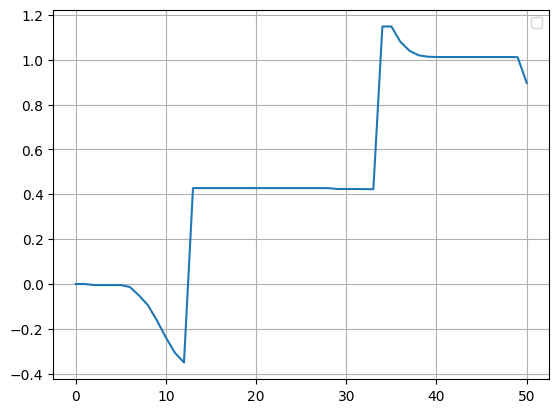

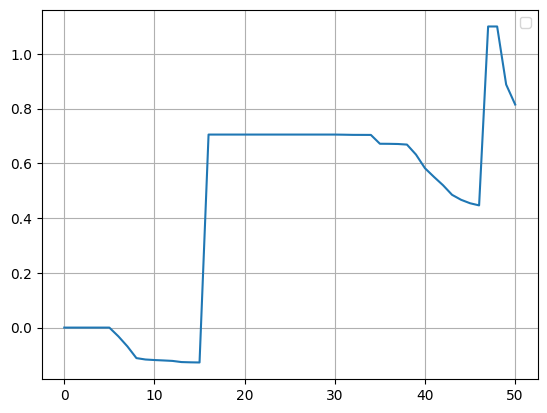

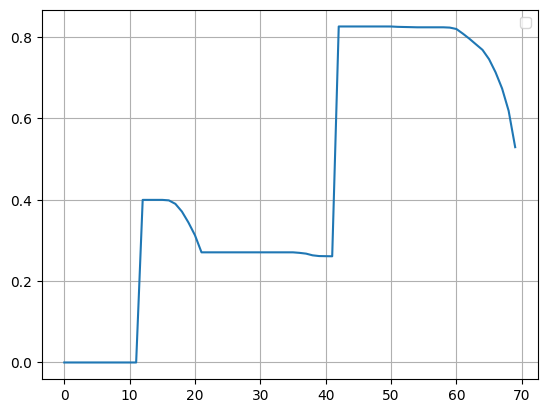

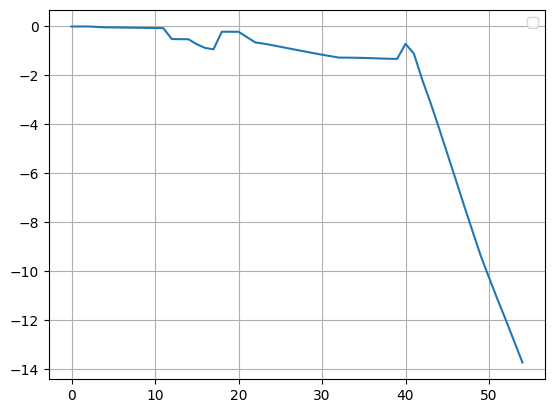

In [541]:
racePerformanceCallback = RacePerformanceMetricCallback(X_test, y_test, test_groups)
hist = model.fit(
    X_train, y_train, 
    epochs=10,
    batch_size=1024,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[racePerformanceCallback],
)

In [53]:
y_pred = model.predict(X_test)

510/510 [==============================] - 1s 1ms/step


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test, y_pred.round()))

[[11390  4417]
 [   57   435]]


              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84     15807
         1.0       0.09      0.88      0.16       492

    accuracy                           0.73     16299
   macro avg       0.54      0.80      0.50     16299
weighted avg       0.97      0.73      0.82     16299



In [55]:
import pickle
# Save model
models_dir = 'models/nn_complexe_big_batch_size_lr05drop2'
os.makedirs(models_dir, exist_ok=True)
model.save(os.path.join(models_dir, 'model.h5'))
encoder_path = os.path.join(models_dir, 'encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder, f)

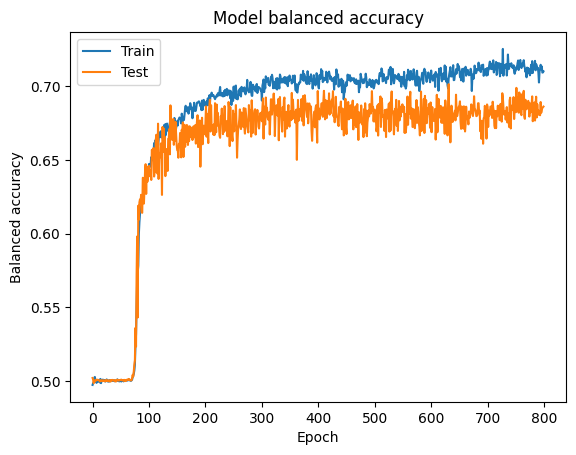

In [56]:
import matplotlib.pyplot as plt

plt.plot(hist.history['balanced_accuracy_loss'])
plt.plot(hist.history['val_balanced_accuracy_loss'])
plt.title('Model balanced accuracy')
plt.ylabel('Balanced accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(models_dir, 'balanced_accuracy.svg'), format='svg')
plt.show()